In [116]:
import re
import numpy as np
import pandas as pd
import tensorflow as tf
from rdflib import Graph
from ampligraph.utils import save_model, restore_model
from ampligraph.evaluation import train_test_split_no_unseen
from ampligraph.latent_features import ScoringBasedEmbeddingModel
from ampligraph.latent_features.loss_functions import get as get_loss
from ampligraph.latent_features.regularizers import get as get_regularizer
from ampligraph.evaluation import mr_score, mrr_score, hits_at_n_score
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import seaborn as sns
from ampligraph.discovery import find_clusters
from sklearn.cluster import KMeans
from sklearn import metrics

%matplotlib inline

In [22]:
tf.test.is_gpu_available()

False

In [23]:
g = Graph()
g.parse("../data/music_graph.ttl")

<Graph identifier=N42a4179eab1944d98ee936fa5a30ff38 (<class 'rdflib.graph.Graph'>)>

In [24]:
data = [triplet for triplet in g]
len(data)

795348

In [25]:
cols = ["subject", "predicate", "object"]
def remove_prefix(x):
    if type(x) == str:
        return re.sub(".+#", "", x)
    return x
triples_df = pd.DataFrame(data, columns=cols)
for c in cols:
    triples_df[c] = triples_df[c].apply(lambda x: x.toPython())
    triples_df[c] = triples_df[c].apply(remove_prefix) 
triples_df

,subject,predicate,object
0,track_34qFmp8HLfrkf3EtcT88F9,danceability,0.768
1,artist_11215,country,US
2,album_0mXof8r6KCrnp7wc2mDpRf,albumType,album
3,track_0DxN6Ywom8nnndyQXdSBPy,partOf,album_24IBCzEJlHBI0ioxlSuSPA
4,track_0EHpJ4uGelHqIxTYyPv106,performedBy,53deL58uye6fCqRK4COtR4
...,...,...,...
795343,track_029EQoB2bbCJGY11hMt8rj,liveness,0.0745
795344,track_1AfdJdGhJGky1HZMQHEWPI,energy,0.797
795345,artist_8929,gender,Male
795346,track_1p14SEOhyuCqYX0hazzdyL,loudness,-14.446


In [26]:
X_train, X_valid = train_test_split_no_unseen(np.array(data), test_size=10000)
print('Train set size: ', X_train.shape)
print('Test set size: ', X_valid.shape)

Train set size:  (785348, 3)
Test set size:  (10000, 3)


In [7]:
model = ScoringBasedEmbeddingModel(
    k=100, eta=1, scoring_type='TransE'
)

2023-12-15 16:24:48.316725: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:894] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-12-15 16:24:48.316892: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:894] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-12-15 16:24:48.317007: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:894] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysf

In [8]:
optim = tf.keras.optimizers.Adam(learning_rate=1e-4)
loss = get_loss('multiclass_nll')
regularizer = get_regularizer('LP', {'p': 3, 'lambda': 1e-5})

In [9]:
model.compile(
    optimizer=optim, loss=loss, entity_relation_regularizer=regularizer
)

In [10]:
# Fit the model
model.fit(
    X_train,
    batch_size=32768, # int(X_train.shape[0] / 50),
    epochs=1000,  # Number of training epochs
    verbose=True  # Enable stdout messages
)

Epoch 1/1000


2023-12-15 16:25:01.827840: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x7fd4e82080c0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2023-12-15 16:25:01.827858: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA GeForce GTX 1060 6GB, Compute Capability 6.1
2023-12-15 16:25:01.830688: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.


      2/Unknown - 3s 1s/step - loss: 22739.9688

2023-12-15 16:25:02.057343: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:442] Loaded cuDNN version 8700
2023-12-15 16:25:02.135518: I ./tensorflow/compiler/jit/device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


25/25 [==============================] - 3s 134ms/step - loss: 22335.2812
Epoch 2/1000
 6/25 [======>.......................] - ETA: 0s - loss: 22234.8184

2023-12-15 16:25:02.950697: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 4846852865060085533


25/25 [==============================] - 1s 31ms/step - loss: 21915.1562
Epoch 3/1000
 6/25 [======>.......................] - ETA: 0s - loss: 21827.8320

2023-12-15 16:25:03.752082: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 4846852865060085533


25/25 [==============================] - 1s 31ms/step - loss: 21532.5625
Epoch 4/1000
 6/25 [======>.......................] - ETA: 0s - loss: 21453.7637

2023-12-15 16:25:04.547385: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 4846852865060085533


25/25 [==============================] - 1s 31ms/step - loss: 21180.9121
Epoch 5/1000
 6/25 [======>.......................] - ETA: 0s - loss: 21108.7422

2023-12-15 16:25:05.334080: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 4846852865060085533


25/25 [==============================] - 1s 30ms/step - loss: 20853.9004
Epoch 6/1000
 6/25 [======>.......................] - ETA: 0s - loss: 20787.5254

2023-12-15 16:25:06.122310: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 4846852865060085533


25/25 [==============================] - 1s 30ms/step - loss: 20550.7832
Epoch 7/1000
 6/25 [======>.......................] - ETA: 0s - loss: 20488.9375

2023-12-15 16:25:06.907381: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 4846852865060085533


25/25 [==============================] - 1s 31ms/step - loss: 20269.1621
Epoch 8/1000
 6/25 [======>.......................] - ETA: 0s - loss: 20211.7949

2023-12-15 16:25:07.702179: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 4846852865060085533


25/25 [==============================] - 1s 30ms/step - loss: 20004.0137
Epoch 9/1000
 6/25 [======>.......................] - ETA: 0s - loss: 19950.1719

2023-12-15 16:25:08.479875: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 4846852865060085533


25/25 [==============================] - 1s 30ms/step - loss: 19754.5117
Epoch 10/1000
 6/25 [======>.......................] - ETA: 0s - loss: 19703.5117

2023-12-15 16:25:09.243826: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 4846852865060085533


25/25 [==============================] - 1s 29ms/step - loss: 19519.0039
Epoch 11/1000
 6/25 [======>.......................] - ETA: 0s - loss: 19470.6836

2023-12-15 16:25:09.987685: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 4846852865060085533


25/25 [==============================] - 1s 29ms/step - loss: 19294.4160
Epoch 12/1000
 6/25 [======>.......................] - ETA: 0s - loss: 19248.1875

2023-12-15 16:25:10.741933: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 4846852865060085533


25/25 [==============================] - 1s 30ms/step - loss: 19079.4121
Epoch 13/1000
 6/25 [======>.......................] - ETA: 0s - loss: 19035.0508

2023-12-15 16:25:11.533940: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 4846852865060085533


25/25 [==============================] - 1s 31ms/step - loss: 18873.0410
Epoch 14/1000
 6/25 [======>.......................] - ETA: 0s - loss: 18830.5996

2023-12-15 16:25:12.326714: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 4846852865060085533


25/25 [==============================] - 1s 31ms/step - loss: 18673.7402
Epoch 15/1000
 6/25 [======>.......................] - ETA: 0s - loss: 18632.7832

2023-12-15 16:25:13.120059: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 4846852865060085533


25/25 [==============================] - 1s 30ms/step - loss: 18481.9844
Epoch 16/1000
 6/25 [======>.......................] - ETA: 0s - loss: 18442.0273

2023-12-15 16:25:13.904251: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 4846852865060085533


25/25 [==============================] - 1s 30ms/step - loss: 18295.7988
Epoch 17/1000
 6/25 [======>.......................] - ETA: 0s - loss: 18257.5703

2023-12-15 16:25:14.688233: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 4846852865060085533


25/25 [==============================] - 1s 30ms/step - loss: 18115.6953
Epoch 18/1000
 6/25 [======>.......................] - ETA: 0s - loss: 18078.5547

2023-12-15 16:25:15.471587: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 4846852865060085533


25/25 [==============================] - 1s 31ms/step - loss: 17940.5840
Epoch 19/1000
 6/25 [======>.......................] - ETA: 0s - loss: 17904.5879

2023-12-15 16:25:16.262914: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 4846852865060085533


25/25 [==============================] - 1s 31ms/step - loss: 17770.7070
Epoch 20/1000
 6/25 [======>.......................] - ETA: 0s - loss: 17735.3320

2023-12-15 16:25:17.055975: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 4846852865060085533


25/25 [==============================] - 1s 31ms/step - loss: 17604.9902
Epoch 21/1000
 6/25 [======>.......................] - ETA: 0s - loss: 17570.8066

2023-12-15 16:25:17.852718: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 4846852865060085533


25/25 [==============================] - 1s 30ms/step - loss: 17443.4062
Epoch 22/1000
 6/25 [======>.......................] - ETA: 0s - loss: 17410.0039

2023-12-15 16:25:18.639843: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 4846852865060085533


25/25 [==============================] - 1s 30ms/step - loss: 17285.6426
Epoch 23/1000
 6/25 [======>.......................] - ETA: 0s - loss: 17253.1211

2023-12-15 16:25:19.425509: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 4846852865060085533


25/25 [==============================] - 1s 30ms/step - loss: 17131.3184
Epoch 24/1000
 6/25 [======>.......................] - ETA: 0s - loss: 17099.5645

2023-12-15 16:25:20.208724: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 4846852865060085533


25/25 [==============================] - 1s 30ms/step - loss: 16980.2285
Epoch 25/1000
 6/25 [======>.......................] - ETA: 0s - loss: 16949.0645

2023-12-15 16:25:20.996321: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 4846852865060085533


25/25 [==============================] - 1s 30ms/step - loss: 16832.4141
Epoch 26/1000
 6/25 [======>.......................] - ETA: 0s - loss: 16801.7578

2023-12-15 16:25:21.780889: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 4846852865060085533


25/25 [==============================] - 1s 30ms/step - loss: 16687.3535
Epoch 27/1000
 6/25 [======>.......................] - ETA: 0s - loss: 16657.4043

2023-12-15 16:25:22.565450: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 4846852865060085533


25/25 [==============================] - 1s 30ms/step - loss: 16545.3926
Epoch 28/1000
 6/25 [======>.......................] - ETA: 0s - loss: 16516.1855

2023-12-15 16:25:23.348783: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 4846852865060085533


25/25 [==============================] - 1s 30ms/step - loss: 16406.2461
Epoch 29/1000
 6/25 [======>.......................] - ETA: 0s - loss: 16377.5068

2023-12-15 16:25:24.133758: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 4846852865060085533


25/25 [==============================] - 1s 30ms/step - loss: 16269.8506
Epoch 30/1000
 6/25 [======>.......................] - ETA: 0s - loss: 16241.6045

2023-12-15 16:25:24.922439: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 4846852865060085533


25/25 [==============================] - 1s 30ms/step - loss: 16135.9277
Epoch 31/1000
 6/25 [======>.......................] - ETA: 0s - loss: 16108.2832

2023-12-15 16:25:25.703719: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 4846852865060085533


25/25 [==============================] - 1s 30ms/step - loss: 16004.3525
Epoch 32/1000
 6/25 [======>.......................] - ETA: 0s - loss: 15977.1260

2023-12-15 16:25:26.488712: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 4846852865060085533


25/25 [==============================] - 1s 30ms/step - loss: 15874.6807
Epoch 33/1000
 6/25 [======>.......................] - ETA: 0s - loss: 15847.9570

2023-12-15 16:25:27.272363: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 4846852865060085533


25/25 [==============================] - 1s 30ms/step - loss: 15746.9189
Epoch 34/1000
 6/25 [======>.......................] - ETA: 0s - loss: 15720.5146

2023-12-15 16:25:28.053877: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 4846852865060085533


25/25 [==============================] - 1s 31ms/step - loss: 15621.6309
Epoch 35/1000
25/25 [==============================] - 1s 30ms/step - loss: 15497.6074
Epoch 36/1000
 6/25 [======>.......................] - ETA: 0s - loss: 15471.9424

2023-12-15 16:25:29.630719: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 4846852865060085533


25/25 [==============================] - 1s 30ms/step - loss: 15375.1113
Epoch 37/1000
 6/25 [======>.......................] - ETA: 0s - loss: 15349.6943

2023-12-15 16:25:30.412794: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 4846852865060085533


25/25 [==============================] - 1s 30ms/step - loss: 15254.2588
Epoch 38/1000
 6/25 [======>.......................] - ETA: 0s - loss: 15229.1543

2023-12-15 16:25:31.199309: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 4846852865060085533


25/25 [==============================] - 1s 30ms/step - loss: 15134.9141
Epoch 39/1000
 6/25 [======>.......................] - ETA: 0s - loss: 15110.2002

2023-12-15 16:25:31.984984: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 4846852865060085533


25/25 [==============================] - 1s 30ms/step - loss: 15017.0957
Epoch 40/1000
 6/25 [======>.......................] - ETA: 0s - loss: 14992.8037

2023-12-15 16:25:32.767052: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 4846852865060085533


25/25 [==============================] - 1s 30ms/step - loss: 14901.0518
Epoch 41/1000
 6/25 [======>.......................] - ETA: 0s - loss: 14877.2383

2023-12-15 16:25:33.551035: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 4846852865060085533


25/25 [==============================] - 1s 30ms/step - loss: 14786.5840
Epoch 42/1000
 6/25 [======>.......................] - ETA: 0s - loss: 14762.8633

2023-12-15 16:25:34.339717: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 4846852865060085533


25/25 [==============================] - 1s 30ms/step - loss: 14673.8359
Epoch 43/1000
 6/25 [======>.......................] - ETA: 0s - loss: 14650.3848

2023-12-15 16:25:35.121989: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 4846852865060085533


25/25 [==============================] - 1s 30ms/step - loss: 14562.1826
Epoch 44/1000
 6/25 [======>.......................] - ETA: 0s - loss: 14539.0947

2023-12-15 16:25:35.904401: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 4846852865060085533


25/25 [==============================] - 1s 30ms/step - loss: 14452.0645
Epoch 45/1000
 6/25 [======>.......................] - ETA: 0s - loss: 14429.2754

2023-12-15 16:25:36.687902: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 4846852865060085533


25/25 [==============================] - 1s 30ms/step - loss: 14343.0547
Epoch 46/1000
 6/25 [======>.......................] - ETA: 0s - loss: 14320.6377

2023-12-15 16:25:37.470344: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 4846852865060085533


25/25 [==============================] - 1s 30ms/step - loss: 14235.6953
Epoch 47/1000
 6/25 [======>.......................] - ETA: 0s - loss: 14213.4678

2023-12-15 16:25:38.258649: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 4846852865060085533


25/25 [==============================] - 1s 30ms/step - loss: 14129.5088
Epoch 48/1000
 6/25 [======>.......................] - ETA: 0s - loss: 14107.5254

2023-12-15 16:25:39.039498: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 4846852865060085533


25/25 [==============================] - 1s 30ms/step - loss: 14024.3848
Epoch 49/1000
 6/25 [======>.......................] - ETA: 0s - loss: 14002.6504

2023-12-15 16:25:39.825602: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 4846852865060085533


25/25 [==============================] - 1s 30ms/step - loss: 13920.7881
Epoch 50/1000
25/25 [==============================] - 1s 30ms/step - loss: 13818.3076
Epoch 51/1000
 6/25 [======>.......................] - ETA: 0s - loss: 13796.9756

2023-12-15 16:25:41.389276: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 4846852865060085533


25/25 [==============================] - 1s 30ms/step - loss: 13717.1279
Epoch 52/1000
 6/25 [======>.......................] - ETA: 0s - loss: 13696.1143

2023-12-15 16:25:42.179824: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 4846852865060085533


25/25 [==============================] - 1s 30ms/step - loss: 13617.1152
Epoch 53/1000
 6/25 [======>.......................] - ETA: 0s - loss: 13596.5078

2023-12-15 16:25:42.966273: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 4846852865060085533


25/25 [==============================] - 1s 31ms/step - loss: 13518.4414
Epoch 54/1000
 6/25 [======>.......................] - ETA: 0s - loss: 13498.0498

2023-12-15 16:25:43.757444: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 4846852865060085533


25/25 [==============================] - 1s 30ms/step - loss: 13421.0801
Epoch 55/1000
 6/25 [======>.......................] - ETA: 0s - loss: 13401.0391

2023-12-15 16:25:44.545613: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 4846852865060085533


25/25 [==============================] - 1s 30ms/step - loss: 13324.9678
Epoch 56/1000
 6/25 [======>.......................] - ETA: 0s - loss: 13305.0654

2023-12-15 16:25:45.328301: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 4846852865060085533


25/25 [==============================] - 1s 30ms/step - loss: 13230.0801
Epoch 57/1000
 6/25 [======>.......................] - ETA: 0s - loss: 13210.4434

2023-12-15 16:25:46.116714: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 4846852865060085533


25/25 [==============================] - 1s 30ms/step - loss: 13136.2832
Epoch 58/1000
 6/25 [======>.......................] - ETA: 0s - loss: 13116.9473

2023-12-15 16:25:46.900720: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 4846852865060085533


25/25 [==============================] - 1s 31ms/step - loss: 13043.8447
Epoch 59/1000
25/25 [==============================] - 1s 31ms/step - loss: 12952.1084
Epoch 60/1000
 6/25 [======>.......................] - ETA: 0s - loss: 12933.1035

2023-12-15 16:25:48.483246: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 4846852865060085533


25/25 [==============================] - 1s 30ms/step - loss: 12861.3818
Epoch 61/1000
 6/25 [======>.......................] - ETA: 0s - loss: 12842.5439

2023-12-15 16:25:49.271792: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 4846852865060085533


25/25 [==============================] - 1s 30ms/step - loss: 12771.7305
Epoch 62/1000
 6/25 [======>.......................] - ETA: 0s - loss: 12753.2852

2023-12-15 16:25:50.061200: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 4846852865060085533


25/25 [==============================] - 1s 31ms/step - loss: 12683.4316
Epoch 63/1000
 6/25 [======>.......................] - ETA: 0s - loss: 12665.1934

2023-12-15 16:25:50.850735: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 4846852865060085533


25/25 [==============================] - 1s 31ms/step - loss: 12596.2715
Epoch 64/1000
 6/25 [======>.......................] - ETA: 0s - loss: 12578.1543

2023-12-15 16:25:51.634268: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 4846852865060085533


25/25 [==============================] - 1s 31ms/step - loss: 12510.0791
Epoch 65/1000
 6/25 [======>.......................] - ETA: 0s - loss: 12492.2334

2023-12-15 16:25:52.420776: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 4846852865060085533


25/25 [==============================] - 1s 30ms/step - loss: 12425.1357
Epoch 66/1000
 6/25 [======>.......................] - ETA: 0s - loss: 12407.5273

2023-12-15 16:25:53.205971: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 4846852865060085533


25/25 [==============================] - 1s 30ms/step - loss: 12340.9990
Epoch 67/1000
 6/25 [======>.......................] - ETA: 0s - loss: 12323.6152

2023-12-15 16:25:53.992671: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 4846852865060085533


25/25 [==============================] - 1s 31ms/step - loss: 12257.9648
Epoch 68/1000
 6/25 [======>.......................] - ETA: 0s - loss: 12240.8086

2023-12-15 16:25:54.783896: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 4846852865060085533


25/25 [==============================] - 1s 31ms/step - loss: 12176.0352
Epoch 69/1000
 6/25 [======>.......................] - ETA: 0s - loss: 12159.0938

2023-12-15 16:25:55.571198: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 4846852865060085533


25/25 [==============================] - 1s 31ms/step - loss: 12094.9609
Epoch 70/1000
 6/25 [======>.......................] - ETA: 0s - loss: 12078.3008

2023-12-15 16:25:56.361159: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 4846852865060085533


25/25 [==============================] - 1s 31ms/step - loss: 12015.1201
Epoch 71/1000
 6/25 [======>.......................] - ETA: 0s - loss: 11998.6279

2023-12-15 16:25:57.152285: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 4846852865060085533


25/25 [==============================] - 1s 30ms/step - loss: 11935.9746
Epoch 72/1000
 6/25 [======>.......................] - ETA: 0s - loss: 11919.5938

2023-12-15 16:25:57.940426: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 4846852865060085533


25/25 [==============================] - 1s 31ms/step - loss: 11857.7236
Epoch 73/1000
 6/25 [======>.......................] - ETA: 0s - loss: 11841.5439

2023-12-15 16:25:58.735792: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 4846852865060085533


25/25 [==============================] - 1s 30ms/step - loss: 11780.6436
Epoch 74/1000
 6/25 [======>.......................] - ETA: 0s - loss: 11764.7285

2023-12-15 16:25:59.522991: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 4846852865060085533


25/25 [==============================] - 1s 30ms/step - loss: 11704.3516
Epoch 75/1000
 6/25 [======>.......................] - ETA: 0s - loss: 11688.5850

2023-12-15 16:26:00.312329: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 4846852865060085533


25/25 [==============================] - 1s 30ms/step - loss: 11629.1611
Epoch 76/1000
 6/25 [======>.......................] - ETA: 0s - loss: 11613.5557

2023-12-15 16:26:01.094760: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 4846852865060085533


25/25 [==============================] - 1s 30ms/step - loss: 11554.8682
Epoch 77/1000
 6/25 [======>.......................] - ETA: 0s - loss: 11539.4502

2023-12-15 16:26:01.877570: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 4846852865060085533


25/25 [==============================] - 1s 30ms/step - loss: 11481.2666
Epoch 78/1000
 6/25 [======>.......................] - ETA: 0s - loss: 11466.0605

2023-12-15 16:26:02.664004: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 4846852865060085533


25/25 [==============================] - 1s 30ms/step - loss: 11408.5645
Epoch 79/1000
 6/25 [======>.......................] - ETA: 0s - loss: 11393.5439

2023-12-15 16:26:03.451736: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 4846852865060085533


25/25 [==============================] - 1s 30ms/step - loss: 11336.8174
Epoch 80/1000
 6/25 [======>.......................] - ETA: 0s - loss: 11322.0225

2023-12-15 16:26:04.238356: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 4846852865060085533


25/25 [==============================] - 1s 30ms/step - loss: 11265.9727
Epoch 81/1000
 6/25 [======>.......................] - ETA: 0s - loss: 11251.3271

2023-12-15 16:26:05.022916: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 4846852865060085533


25/25 [==============================] - 1s 30ms/step - loss: 11196.0762
Epoch 82/1000
 6/25 [======>.......................] - ETA: 0s - loss: 11181.6123

2023-12-15 16:26:05.806310: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 4846852865060085533


25/25 [==============================] - 1s 30ms/step - loss: 11126.9160
Epoch 83/1000
 6/25 [======>.......................] - ETA: 0s - loss: 11112.5986

2023-12-15 16:26:06.591269: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 4846852865060085533


25/25 [==============================] - 1s 30ms/step - loss: 11058.5459
Epoch 84/1000
 6/25 [======>.......................] - ETA: 0s - loss: 11044.3750

2023-12-15 16:26:07.377880: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 4846852865060085533


25/25 [==============================] - 1s 30ms/step - loss: 10991.0176
Epoch 85/1000
 6/25 [======>.......................] - ETA: 0s - loss: 10977.0420

2023-12-15 16:26:08.162477: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 4846852865060085533


25/25 [==============================] - 1s 30ms/step - loss: 10924.2783
Epoch 86/1000
25/25 [==============================] - 1s 30ms/step - loss: 10858.3340
Epoch 87/1000
 6/25 [======>.......................] - ETA: 0s - loss: 10844.7031

2023-12-15 16:26:09.724779: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 4846852865060085533


25/25 [==============================] - 1s 30ms/step - loss: 10793.0791
Epoch 88/1000
 6/25 [======>.......................] - ETA: 0s - loss: 10779.6719

2023-12-15 16:26:10.506551: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 4846852865060085533


25/25 [==============================] - 1s 30ms/step - loss: 10728.7129
Epoch 89/1000
 6/25 [======>.......................] - ETA: 0s - loss: 10715.3398

2023-12-15 16:26:11.288435: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 4846852865060085533


25/25 [==============================] - 1s 30ms/step - loss: 10664.9600
Epoch 90/1000
 6/25 [======>.......................] - ETA: 0s - loss: 10651.7695

2023-12-15 16:26:12.068119: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 4846852865060085533


25/25 [==============================] - 1s 30ms/step - loss: 10601.9980
Epoch 91/1000
 6/25 [======>.......................] - ETA: 0s - loss: 10588.9893

2023-12-15 16:26:12.847920: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 4846852865060085533


25/25 [==============================] - 1s 30ms/step - loss: 10539.9336
Epoch 92/1000
 6/25 [======>.......................] - ETA: 0s - loss: 10527.1660

2023-12-15 16:26:13.633158: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 4846852865060085533


25/25 [==============================] - 1s 30ms/step - loss: 10478.6045
Epoch 93/1000
25/25 [==============================] - 1s 30ms/step - loss: 10418.1035
Epoch 94/1000
 6/25 [======>.......................] - ETA: 0s - loss: 10405.5400

2023-12-15 16:26:15.199038: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 4846852865060085533


25/25 [==============================] - 1s 30ms/step - loss: 10358.1299
Epoch 95/1000
 6/25 [======>.......................] - ETA: 0s - loss: 10345.7227

2023-12-15 16:26:15.984851: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 4846852865060085533


25/25 [==============================] - 1s 30ms/step - loss: 10298.9561
Epoch 96/1000
 6/25 [======>.......................] - ETA: 0s - loss: 10286.6758

2023-12-15 16:26:16.770277: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 4846852865060085533


25/25 [==============================] - 1s 30ms/step - loss: 10240.5361
Epoch 97/1000
 6/25 [======>.......................] - ETA: 0s - loss: 10228.4990

2023-12-15 16:26:17.557310: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 4846852865060085533


25/25 [==============================] - 1s 30ms/step - loss: 10182.9170
Epoch 98/1000
 6/25 [======>.......................] - ETA: 0s - loss: 10170.9629

2023-12-15 16:26:18.346459: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 4846852865060085533


25/25 [==============================] - 1s 30ms/step - loss: 10125.8135
Epoch 99/1000
25/25 [==============================] - 1s 30ms/step - loss: 10069.5029
Epoch 100/1000
 6/25 [======>.......................] - ETA: 0s - loss: 10057.8711

2023-12-15 16:26:19.911928: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 4846852865060085533


25/25 [==============================] - 1s 30ms/step - loss: 10013.6729
Epoch 101/1000
 6/25 [======>.......................] - ETA: 0s - loss: 10002.1396

2023-12-15 16:26:20.694639: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 4846852865060085533


25/25 [==============================] - 1s 30ms/step - loss: 9958.3643
Epoch 102/1000
 6/25 [======>.......................] - ETA: 0s - loss: 9946.9229

2023-12-15 16:26:21.479134: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 4846852865060085533


25/25 [==============================] - 1s 30ms/step - loss: 9903.7295
Epoch 103/1000
 6/25 [======>.......................] - ETA: 0s - loss: 9892.4395

2023-12-15 16:26:22.267331: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 4846852865060085533


25/25 [==============================] - 1s 30ms/step - loss: 9849.7588
Epoch 104/1000
 6/25 [======>.......................] - ETA: 0s - loss: 9838.6172

2023-12-15 16:26:23.050406: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 4846852865060085533


25/25 [==============================] - 1s 30ms/step - loss: 9796.3477
Epoch 105/1000
 6/25 [======>.......................] - ETA: 0s - loss: 9785.3281

2023-12-15 16:26:23.831267: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 4846852865060085533


25/25 [==============================] - 1s 31ms/step - loss: 9743.6084
Epoch 106/1000
 6/25 [======>.......................] - ETA: 0s - loss: 9732.7461

2023-12-15 16:26:24.619561: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 4846852865060085533


25/25 [==============================] - 1s 30ms/step - loss: 9691.4756
Epoch 107/1000
 6/25 [======>.......................] - ETA: 0s - loss: 9680.6758

2023-12-15 16:26:25.407175: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 4846852865060085533


25/25 [==============================] - 1s 31ms/step - loss: 9639.7969
Epoch 108/1000
 6/25 [======>.......................] - ETA: 0s - loss: 9629.1445

2023-12-15 16:26:26.193895: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 4846852865060085533


25/25 [==============================] - 1s 31ms/step - loss: 9588.7559
Epoch 109/1000
25/25 [==============================] - 1s 31ms/step - loss: 9538.2461
Epoch 110/1000
 6/25 [======>.......................] - ETA: 0s - loss: 9527.8291

2023-12-15 16:26:27.776224: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 4846852865060085533


25/25 [==============================] - 1s 31ms/step - loss: 9488.2959
Epoch 111/1000
 6/25 [======>.......................] - ETA: 0s - loss: 9477.9678

2023-12-15 16:26:28.576914: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 4846852865060085533


25/25 [==============================] - 1s 31ms/step - loss: 9438.7939
Epoch 112/1000
 6/25 [======>.......................] - ETA: 0s - loss: 9428.6152

2023-12-15 16:26:29.369394: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 4846852865060085533


25/25 [==============================] - 1s 31ms/step - loss: 9389.9395
Epoch 113/1000
 6/25 [======>.......................] - ETA: 0s - loss: 9379.8086

2023-12-15 16:26:30.154793: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 4846852865060085533


25/25 [==============================] - 1s 31ms/step - loss: 9341.6201
Epoch 114/1000
 6/25 [======>.......................] - ETA: 0s - loss: 9331.6494

2023-12-15 16:26:30.948536: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 4846852865060085533


25/25 [==============================] - 1s 31ms/step - loss: 9293.8662
Epoch 115/1000
 6/25 [======>.......................] - ETA: 0s - loss: 9284.0137

2023-12-15 16:26:31.747858: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 4846852865060085533


25/25 [==============================] - 1s 31ms/step - loss: 9246.6758
Epoch 116/1000
 6/25 [======>.......................] - ETA: 0s - loss: 9236.8311

2023-12-15 16:26:32.538033: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 4846852865060085533


25/25 [==============================] - 1s 31ms/step - loss: 9199.9395
Epoch 117/1000
 6/25 [======>.......................] - ETA: 0s - loss: 9190.2910

2023-12-15 16:26:33.335662: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 4846852865060085533


25/25 [==============================] - 1s 31ms/step - loss: 9153.7744
Epoch 118/1000
25/25 [==============================] - 1s 31ms/step - loss: 9108.0225
Epoch 119/1000
 6/25 [======>.......................] - ETA: 0s - loss: 9098.5684

2023-12-15 16:26:34.922713: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 4846852865060085533


25/25 [==============================] - 1s 31ms/step - loss: 9062.8018
Epoch 120/1000
 6/25 [======>.......................] - ETA: 0s - loss: 9053.4414

2023-12-15 16:26:35.717419: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 4846852865060085533


25/25 [==============================] - 1s 30ms/step - loss: 9018.0332
Epoch 121/1000
 6/25 [======>.......................] - ETA: 0s - loss: 9008.7559

2023-12-15 16:26:36.499467: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 4846852865060085533


25/25 [==============================] - 1s 30ms/step - loss: 8973.7930
Epoch 122/1000
 6/25 [======>.......................] - ETA: 0s - loss: 8964.6455

2023-12-15 16:26:37.278026: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 4846852865060085533


25/25 [==============================] - 1s 30ms/step - loss: 8929.9600
Epoch 123/1000
 6/25 [======>.......................] - ETA: 0s - loss: 8920.9023

2023-12-15 16:26:38.057645: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 4846852865060085533


25/25 [==============================] - 1s 30ms/step - loss: 8886.5830
Epoch 124/1000
 6/25 [======>.......................] - ETA: 0s - loss: 8877.5928

2023-12-15 16:26:38.841801: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 4846852865060085533


25/25 [==============================] - 1s 30ms/step - loss: 8843.7988
Epoch 125/1000
 6/25 [======>.......................] - ETA: 0s - loss: 8834.9375

2023-12-15 16:26:39.618164: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 4846852865060085533


25/25 [==============================] - 1s 30ms/step - loss: 8801.3936
Epoch 126/1000
 6/25 [======>.......................] - ETA: 0s - loss: 8792.6016

2023-12-15 16:26:40.396541: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 4846852865060085533


25/25 [==============================] - 1s 30ms/step - loss: 8759.3604
Epoch 127/1000
 6/25 [======>.......................] - ETA: 0s - loss: 8750.6660

2023-12-15 16:26:41.178305: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 4846852865060085533


25/25 [==============================] - 1s 30ms/step - loss: 8717.7139
Epoch 128/1000
 6/25 [======>.......................] - ETA: 0s - loss: 8709.0840

2023-12-15 16:26:41.956336: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 4846852865060085533


25/25 [==============================] - 1s 30ms/step - loss: 8676.5332
Epoch 129/1000
 6/25 [======>.......................] - ETA: 0s - loss: 8668.0342

2023-12-15 16:26:42.733985: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 4846852865060085533


25/25 [==============================] - 1s 30ms/step - loss: 8635.7891
Epoch 130/1000
 6/25 [======>.......................] - ETA: 0s - loss: 8627.3701

2023-12-15 16:26:43.514404: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 4846852865060085533


25/25 [==============================] - 1s 30ms/step - loss: 8595.4932
Epoch 131/1000
 6/25 [======>.......................] - ETA: 0s - loss: 8587.1562

2023-12-15 16:26:44.291515: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 4846852865060085533


25/25 [==============================] - 1s 30ms/step - loss: 8555.6182
Epoch 132/1000
 6/25 [======>.......................] - ETA: 0s - loss: 8547.3643

2023-12-15 16:26:45.070909: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 4846852865060085533


25/25 [==============================] - 1s 30ms/step - loss: 8516.1260
Epoch 133/1000
 6/25 [======>.......................] - ETA: 0s - loss: 8507.9434

2023-12-15 16:26:45.846207: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 4846852865060085533


25/25 [==============================] - 1s 30ms/step - loss: 8476.9648
Epoch 134/1000
 6/25 [======>.......................] - ETA: 0s - loss: 8468.8691

2023-12-15 16:26:46.620162: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 4846852865060085533


25/25 [==============================] - 1s 30ms/step - loss: 8438.2676
Epoch 135/1000
 6/25 [======>.......................] - ETA: 0s - loss: 8430.2451

2023-12-15 16:26:47.399082: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 4846852865060085533


25/25 [==============================] - 1s 30ms/step - loss: 8399.9180
Epoch 136/1000
 6/25 [======>.......................] - ETA: 0s - loss: 8392.0029

2023-12-15 16:26:48.177197: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 4846852865060085533


25/25 [==============================] - 1s 30ms/step - loss: 8361.9141
Epoch 137/1000
 6/25 [======>.......................] - ETA: 0s - loss: 8354.0547

2023-12-15 16:26:48.950411: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 4846852865060085533


25/25 [==============================] - 1s 30ms/step - loss: 8324.3281
Epoch 138/1000
 6/25 [======>.......................] - ETA: 0s - loss: 8316.5117

2023-12-15 16:26:49.727487: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 4846852865060085533


25/25 [==============================] - 1s 30ms/step - loss: 8286.9990
Epoch 139/1000
 6/25 [======>.......................] - ETA: 0s - loss: 8279.3193

2023-12-15 16:26:50.507955: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 4846852865060085533


25/25 [==============================] - 1s 30ms/step - loss: 8250.0137
Epoch 140/1000
 6/25 [======>.......................] - ETA: 0s - loss: 8242.4004

2023-12-15 16:26:51.287011: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 4846852865060085533


25/25 [==============================] - 1s 30ms/step - loss: 8213.4414
Epoch 141/1000
 6/25 [======>.......................] - ETA: 0s - loss: 8205.8525

2023-12-15 16:26:52.067314: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 4846852865060085533


25/25 [==============================] - 1s 30ms/step - loss: 8177.3164
Epoch 142/1000
 6/25 [======>.......................] - ETA: 0s - loss: 8169.8193

2023-12-15 16:26:52.840729: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 4846852865060085533


25/25 [==============================] - 1s 30ms/step - loss: 8141.4419
Epoch 143/1000
 6/25 [======>.......................] - ETA: 0s - loss: 8134.0000

2023-12-15 16:26:53.621827: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 4846852865060085533


25/25 [==============================] - 1s 30ms/step - loss: 8105.9429
Epoch 144/1000
 6/25 [======>.......................] - ETA: 0s - loss: 8098.5879

2023-12-15 16:26:54.398651: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 4846852865060085533


25/25 [==============================] - 1s 30ms/step - loss: 8070.8066
Epoch 145/1000
 6/25 [======>.......................] - ETA: 0s - loss: 8063.5244

2023-12-15 16:26:55.172466: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 4846852865060085533


25/25 [==============================] - 1s 30ms/step - loss: 8036.0767
Epoch 146/1000
 6/25 [======>.......................] - ETA: 0s - loss: 8028.8711

2023-12-15 16:26:55.953893: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 4846852865060085533


25/25 [==============================] - 1s 30ms/step - loss: 8001.6636
Epoch 147/1000
 6/25 [======>.......................] - ETA: 0s - loss: 7994.5527

2023-12-15 16:26:56.739027: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 4846852865060085533


25/25 [==============================] - 1s 30ms/step - loss: 7967.5278
Epoch 148/1000
 6/25 [======>.......................] - ETA: 0s - loss: 7960.5220

2023-12-15 16:26:57.519823: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 4846852865060085533


25/25 [==============================] - 1s 30ms/step - loss: 7933.8579
Epoch 149/1000
 6/25 [======>.......................] - ETA: 0s - loss: 7926.8755

2023-12-15 16:26:58.295999: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 4846852865060085533


25/25 [==============================] - 1s 30ms/step - loss: 7900.4922
Epoch 150/1000
 6/25 [======>.......................] - ETA: 0s - loss: 7893.5859

2023-12-15 16:26:59.072389: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 4846852865060085533


25/25 [==============================] - 1s 30ms/step - loss: 7867.4570
Epoch 151/1000
 6/25 [======>.......................] - ETA: 0s - loss: 7860.6060

2023-12-15 16:26:59.850421: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 4846852865060085533


25/25 [==============================] - 1s 30ms/step - loss: 7834.7505
Epoch 152/1000
 6/25 [======>.......................] - ETA: 0s - loss: 7827.9536

2023-12-15 16:27:00.627215: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 4846852865060085533


25/25 [==============================] - 1s 30ms/step - loss: 7802.3140
Epoch 153/1000
 6/25 [======>.......................] - ETA: 0s - loss: 7795.5928

2023-12-15 16:27:01.407376: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 4846852865060085533


25/25 [==============================] - 1s 30ms/step - loss: 7770.1660
Epoch 154/1000
 6/25 [======>.......................] - ETA: 0s - loss: 7763.5166

2023-12-15 16:27:02.183556: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 4846852865060085533


25/25 [==============================] - 1s 30ms/step - loss: 7738.3193
Epoch 155/1000
 6/25 [======>.......................] - ETA: 0s - loss: 7731.7192

2023-12-15 16:27:02.967350: I tensorflow/core/framework/local_rendezvous.cc:425] Local rendezvous send item cancelled. Key hash: 12745098812441766881
2023-12-15 16:27:02.967386: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 4846852865060085533


25/25 [==============================] - 1s 30ms/step - loss: 7706.8564
Epoch 156/1000
 6/25 [======>.......................] - ETA: 0s - loss: 7700.3301

2023-12-15 16:27:03.741208: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 4846852865060085533


25/25 [==============================] - 1s 30ms/step - loss: 7675.6396
Epoch 157/1000
 6/25 [======>.......................] - ETA: 0s - loss: 7669.1689

2023-12-15 16:27:04.520802: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 4846852865060085533


25/25 [==============================] - 1s 30ms/step - loss: 7644.6895
Epoch 158/1000
 6/25 [======>.......................] - ETA: 0s - loss: 7638.2861

2023-12-15 16:27:05.302256: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 4846852865060085533


25/25 [==============================] - 1s 30ms/step - loss: 7614.0020
Epoch 159/1000
 6/25 [======>.......................] - ETA: 0s - loss: 7607.6284

2023-12-15 16:27:06.077522: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 4846852865060085533


25/25 [==============================] - 1s 30ms/step - loss: 7583.5918
Epoch 160/1000
 6/25 [======>.......................] - ETA: 0s - loss: 7577.2700

2023-12-15 16:27:06.854846: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 4846852865060085533


25/25 [==============================] - 1s 30ms/step - loss: 7553.4458
Epoch 161/1000
 6/25 [======>.......................] - ETA: 0s - loss: 7547.1904

2023-12-15 16:27:07.632395: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 4846852865060085533


25/25 [==============================] - 1s 30ms/step - loss: 7523.5332
Epoch 162/1000
25/25 [==============================] - 1s 30ms/step - loss: 7493.9370
Epoch 163/1000
 6/25 [======>.......................] - ETA: 0s - loss: 7487.8101

2023-12-15 16:27:09.192304: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 4846852865060085533


25/25 [==============================] - 1s 30ms/step - loss: 7464.6206
Epoch 164/1000
 6/25 [======>.......................] - ETA: 0s - loss: 7458.5630

2023-12-15 16:27:09.967115: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 4846852865060085533


25/25 [==============================] - 1s 30ms/step - loss: 7435.5474
Epoch 165/1000
 6/25 [======>.......................] - ETA: 0s - loss: 7429.5337

2023-12-15 16:27:10.743412: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 4846852865060085533


25/25 [==============================] - 1s 30ms/step - loss: 7406.7256
Epoch 166/1000
 6/25 [======>.......................] - ETA: 0s - loss: 7400.7368

2023-12-15 16:27:11.523074: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 4846852865060085533


25/25 [==============================] - 1s 30ms/step - loss: 7378.1006
Epoch 167/1000
 6/25 [======>.......................] - ETA: 0s - loss: 7372.1953

2023-12-15 16:27:12.310451: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 4846852865060085533


25/25 [==============================] - 1s 30ms/step - loss: 7349.7520
Epoch 168/1000
 6/25 [======>.......................] - ETA: 0s - loss: 7343.8975

2023-12-15 16:27:13.084784: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 4846852865060085533


25/25 [==============================] - 1s 30ms/step - loss: 7321.7080
Epoch 169/1000
 6/25 [======>.......................] - ETA: 0s - loss: 7315.9136

2023-12-15 16:27:13.862664: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 4846852865060085533


25/25 [==============================] - 1s 30ms/step - loss: 7293.9062
Epoch 170/1000
 6/25 [======>.......................] - ETA: 0s - loss: 7288.1255

2023-12-15 16:27:14.643614: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 4846852865060085533


25/25 [==============================] - 1s 30ms/step - loss: 7266.2363
Epoch 171/1000
 6/25 [======>.......................] - ETA: 0s - loss: 7260.5308

2023-12-15 16:27:15.426294: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 4846852865060085533


25/25 [==============================] - 1s 30ms/step - loss: 7238.8926
Epoch 172/1000
 6/25 [======>.......................] - ETA: 0s - loss: 7233.2378

2023-12-15 16:27:16.202014: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 4846852865060085533


25/25 [==============================] - 1s 30ms/step - loss: 7211.7749
Epoch 173/1000
 6/25 [======>.......................] - ETA: 0s - loss: 7206.1558

2023-12-15 16:27:16.973199: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 4846852865060085533


25/25 [==============================] - 1s 30ms/step - loss: 7184.9165
Epoch 174/1000
 6/25 [======>.......................] - ETA: 0s - loss: 7179.3389

2023-12-15 16:27:17.751805: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 4846852865060085533


25/25 [==============================] - 1s 30ms/step - loss: 7158.2227
Epoch 175/1000
 6/25 [======>.......................] - ETA: 0s - loss: 7152.6987

2023-12-15 16:27:18.527028: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 4846852865060085533


25/25 [==============================] - 1s 30ms/step - loss: 7131.8096
Epoch 176/1000
 6/25 [======>.......................] - ETA: 0s - loss: 7126.3398

2023-12-15 16:27:19.305357: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 4846852865060085533


25/25 [==============================] - 1s 30ms/step - loss: 7105.6577
Epoch 177/1000
 6/25 [======>.......................] - ETA: 0s - loss: 7100.2437

2023-12-15 16:27:20.086889: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 4846852865060085533


25/25 [==============================] - 1s 30ms/step - loss: 7079.6523
Epoch 178/1000
 6/25 [======>.......................] - ETA: 0s - loss: 7074.2700

2023-12-15 16:27:20.865093: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 4846852865060085533


25/25 [==============================] - 1s 30ms/step - loss: 7053.9116
Epoch 179/1000
 6/25 [======>.......................] - ETA: 0s - loss: 7048.5625

2023-12-15 16:27:21.640839: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 4846852865060085533


25/25 [==============================] - 1s 30ms/step - loss: 7028.4165
Epoch 180/1000
 6/25 [======>.......................] - ETA: 0s - loss: 7023.1289

2023-12-15 16:27:22.420089: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 4846852865060085533


25/25 [==============================] - 1s 30ms/step - loss: 7003.0864
Epoch 181/1000
 6/25 [======>.......................] - ETA: 0s - loss: 6997.8706

2023-12-15 16:27:23.197493: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 4846852865060085533


25/25 [==============================] - 1s 30ms/step - loss: 6978.0078
Epoch 182/1000
 6/25 [======>.......................] - ETA: 0s - loss: 6972.8320

2023-12-15 16:27:23.972752: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 4846852865060085533


25/25 [==============================] - 1s 30ms/step - loss: 6953.1245
Epoch 183/1000
 6/25 [======>.......................] - ETA: 0s - loss: 6947.9785

2023-12-15 16:27:24.746528: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 4846852865060085533


25/25 [==============================] - 1s 30ms/step - loss: 6928.3999
Epoch 184/1000
 6/25 [======>.......................] - ETA: 0s - loss: 6923.2612

2023-12-15 16:27:25.525440: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 4846852865060085533


25/25 [==============================] - 1s 30ms/step - loss: 6903.8945
Epoch 185/1000
 6/25 [======>.......................] - ETA: 0s - loss: 6898.7798

2023-12-15 16:27:26.301664: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 4846852865060085533


25/25 [==============================] - 1s 30ms/step - loss: 6879.5269
Epoch 186/1000
 6/25 [======>.......................] - ETA: 0s - loss: 6874.4810

2023-12-15 16:27:27.080772: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 4846852865060085533


25/25 [==============================] - 1s 30ms/step - loss: 6855.4038
Epoch 187/1000
 6/25 [======>.......................] - ETA: 0s - loss: 6850.3984

2023-12-15 16:27:27.864002: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 4846852865060085533


25/25 [==============================] - 1s 30ms/step - loss: 6831.4956
Epoch 188/1000
 6/25 [======>.......................] - ETA: 0s - loss: 6826.5366

2023-12-15 16:27:28.641259: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 4846852865060085533


25/25 [==============================] - 1s 30ms/step - loss: 6807.7959
Epoch 189/1000
25/25 [==============================] - 1s 30ms/step - loss: 6784.2749
Epoch 190/1000
 6/25 [======>.......................] - ETA: 0s - loss: 6779.4209

2023-12-15 16:27:30.203282: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 4846852865060085533


25/25 [==============================] - 1s 30ms/step - loss: 6760.9375
Epoch 191/1000
 6/25 [======>.......................] - ETA: 0s - loss: 6756.1201

2023-12-15 16:27:30.985620: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 4846852865060085533


25/25 [==============================] - 1s 30ms/step - loss: 6737.8628
Epoch 192/1000
 6/25 [======>.......................] - ETA: 0s - loss: 6733.0732

2023-12-15 16:27:31.767137: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 4846852865060085533


25/25 [==============================] - 1s 30ms/step - loss: 6714.9448
Epoch 193/1000
 6/25 [======>.......................] - ETA: 0s - loss: 6710.1836

2023-12-15 16:27:32.540096: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 4846852865060085533


25/25 [==============================] - 1s 30ms/step - loss: 6692.1748
Epoch 194/1000
 6/25 [======>.......................] - ETA: 0s - loss: 6687.4634

2023-12-15 16:27:33.324473: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 4846852865060085533


25/25 [==============================] - 1s 30ms/step - loss: 6669.6099
Epoch 195/1000
25/25 [==============================] - 1s 30ms/step - loss: 6647.2598
Epoch 196/1000
 6/25 [======>.......................] - ETA: 0s - loss: 6642.6055

2023-12-15 16:27:34.883520: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 4846852865060085533


25/25 [==============================] - 1s 30ms/step - loss: 6625.0430
Epoch 197/1000
 6/25 [======>.......................] - ETA: 0s - loss: 6620.4355

2023-12-15 16:27:35.668816: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 4846852865060085533


25/25 [==============================] - 1s 30ms/step - loss: 6602.9980
Epoch 198/1000
 6/25 [======>.......................] - ETA: 0s - loss: 6598.3911

2023-12-15 16:27:36.445880: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 4846852865060085533


25/25 [==============================] - 1s 30ms/step - loss: 6581.0596
Epoch 199/1000
 6/25 [======>.......................] - ETA: 0s - loss: 6576.5249

2023-12-15 16:27:37.225973: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 4846852865060085533


25/25 [==============================] - 1s 30ms/step - loss: 6559.3569
Epoch 200/1000
 6/25 [======>.......................] - ETA: 0s - loss: 6554.8569

2023-12-15 16:27:37.999698: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 4846852865060085533


25/25 [==============================] - 1s 30ms/step - loss: 6537.7944
Epoch 201/1000
 6/25 [======>.......................] - ETA: 0s - loss: 6533.3208

2023-12-15 16:27:38.781728: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 4846852865060085533


25/25 [==============================] - 1s 30ms/step - loss: 6516.4570
Epoch 202/1000
25/25 [==============================] - 1s 30ms/step - loss: 6495.2427
Epoch 203/1000
 6/25 [======>.......................] - ETA: 0s - loss: 6490.8555

2023-12-15 16:27:40.336490: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 4846852865060085533


25/25 [==============================] - 1s 30ms/step - loss: 6474.1772
Epoch 204/1000
 6/25 [======>.......................] - ETA: 0s - loss: 6469.8364

2023-12-15 16:27:41.111293: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 4846852865060085533


25/25 [==============================] - 1s 30ms/step - loss: 6453.2783
Epoch 205/1000
 6/25 [======>.......................] - ETA: 0s - loss: 6448.9551

2023-12-15 16:27:41.886872: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 4846852865060085533


25/25 [==============================] - 1s 30ms/step - loss: 6432.5161
Epoch 206/1000
 6/25 [======>.......................] - ETA: 0s - loss: 6428.2402

2023-12-15 16:27:42.663430: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 4846852865060085533


25/25 [==============================] - 1s 30ms/step - loss: 6411.9644
Epoch 207/1000
 6/25 [======>.......................] - ETA: 0s - loss: 6407.7197

2023-12-15 16:27:43.441399: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 4846852865060085533


25/25 [==============================] - 1s 30ms/step - loss: 6391.5908
Epoch 208/1000
 6/25 [======>.......................] - ETA: 0s - loss: 6387.3623

2023-12-15 16:27:44.227813: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 4846852865060085533


25/25 [==============================] - 1s 30ms/step - loss: 6371.3516
Epoch 209/1000
 6/25 [======>.......................] - ETA: 0s - loss: 6367.1440

2023-12-15 16:27:45.001470: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 4846852865060085533


25/25 [==============================] - 1s 30ms/step - loss: 6351.1812
Epoch 210/1000
 6/25 [======>.......................] - ETA: 0s - loss: 6347.0186

2023-12-15 16:27:45.778133: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 4846852865060085533


25/25 [==============================] - 1s 30ms/step - loss: 6331.1733
Epoch 211/1000
 6/25 [======>.......................] - ETA: 0s - loss: 6327.0322

2023-12-15 16:27:46.552519: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 4846852865060085533


25/25 [==============================] - 1s 30ms/step - loss: 6311.3335
Epoch 212/1000
 6/25 [======>.......................] - ETA: 0s - loss: 6307.2251

2023-12-15 16:27:47.330805: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 4846852865060085533


25/25 [==============================] - 1s 30ms/step - loss: 6291.6479
Epoch 213/1000
 6/25 [======>.......................] - ETA: 0s - loss: 6287.5542

2023-12-15 16:27:48.112622: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 4846852865060085533


25/25 [==============================] - 1s 30ms/step - loss: 6272.0938
Epoch 214/1000
 6/25 [======>.......................] - ETA: 0s - loss: 6268.0117

2023-12-15 16:27:48.888942: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 4846852865060085533


25/25 [==============================] - 1s 30ms/step - loss: 6252.6602
Epoch 215/1000
 6/25 [======>.......................] - ETA: 0s - loss: 6248.6401

2023-12-15 16:27:49.670646: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 4846852865060085533


25/25 [==============================] - 1s 30ms/step - loss: 6233.3853
Epoch 216/1000
 6/25 [======>.......................] - ETA: 0s - loss: 6229.3872

2023-12-15 16:27:50.447855: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 4846852865060085533


25/25 [==============================] - 1s 30ms/step - loss: 6214.2598
Epoch 217/1000
 6/25 [======>.......................] - ETA: 0s - loss: 6210.3062

2023-12-15 16:27:51.223225: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 4846852865060085533


25/25 [==============================] - 1s 30ms/step - loss: 6195.3013
Epoch 218/1000
 6/25 [======>.......................] - ETA: 0s - loss: 6191.3599

2023-12-15 16:27:52.001735: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 4846852865060085533


25/25 [==============================] - 1s 30ms/step - loss: 6176.4751
Epoch 219/1000
 6/25 [======>.......................] - ETA: 0s - loss: 6172.5649

2023-12-15 16:27:52.780396: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 4846852865060085533


25/25 [==============================] - 1s 30ms/step - loss: 6157.7837
Epoch 220/1000
 6/25 [======>.......................] - ETA: 0s - loss: 6153.9111

2023-12-15 16:27:53.557161: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 4846852865060085533


25/25 [==============================] - 1s 30ms/step - loss: 6139.2271
Epoch 221/1000
 6/25 [======>.......................] - ETA: 0s - loss: 6135.3794

2023-12-15 16:27:54.333691: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 4846852865060085533


25/25 [==============================] - 1s 30ms/step - loss: 6120.7798
Epoch 222/1000
 6/25 [======>.......................] - ETA: 0s - loss: 6116.9536

2023-12-15 16:27:55.108717: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 4846852865060085533


25/25 [==============================] - 1s 30ms/step - loss: 6102.4844
Epoch 223/1000
 6/25 [======>.......................] - ETA: 0s - loss: 6098.7017

2023-12-15 16:27:55.891476: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 4846852865060085533


25/25 [==============================] - 1s 30ms/step - loss: 6084.2881
Epoch 224/1000
 6/25 [======>.......................] - ETA: 0s - loss: 6080.5200

2023-12-15 16:27:56.669565: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 4846852865060085533


25/25 [==============================] - 1s 30ms/step - loss: 6066.2241
Epoch 225/1000
 6/25 [======>.......................] - ETA: 0s - loss: 6062.5044

2023-12-15 16:27:57.450806: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 4846852865060085533


25/25 [==============================] - 1s 30ms/step - loss: 6048.2988
Epoch 226/1000
 6/25 [======>.......................] - ETA: 0s - loss: 6044.5854

2023-12-15 16:27:58.230323: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 4846852865060085533


25/25 [==============================] - 1s 30ms/step - loss: 6030.5742
Epoch 227/1000
 6/25 [======>.......................] - ETA: 0s - loss: 6026.8760

2023-12-15 16:27:59.007536: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 4846852865060085533


25/25 [==============================] - 1s 30ms/step - loss: 6012.9312
Epoch 228/1000
 6/25 [======>.......................] - ETA: 0s - loss: 6009.2808

2023-12-15 16:27:59.787273: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 4846852865060085533


25/25 [==============================] - 1s 30ms/step - loss: 5995.4038
Epoch 229/1000
 6/25 [======>.......................] - ETA: 0s - loss: 5991.7607

2023-12-15 16:28:00.564645: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 4846852865060085533


25/25 [==============================] - 1s 30ms/step - loss: 5978.0122
Epoch 230/1000
 6/25 [======>.......................] - ETA: 0s - loss: 5974.3975

2023-12-15 16:28:01.339547: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 4846852865060085533


25/25 [==============================] - 1s 30ms/step - loss: 5960.7061
Epoch 231/1000
 6/25 [======>.......................] - ETA: 0s - loss: 5957.1177

2023-12-15 16:28:02.120511: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 4846852865060085533


25/25 [==============================] - 1s 30ms/step - loss: 5943.5352
Epoch 232/1000
 6/25 [======>.......................] - ETA: 0s - loss: 5939.9756

2023-12-15 16:28:02.897425: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 4846852865060085533


25/25 [==============================] - 1s 30ms/step - loss: 5926.4570
Epoch 233/1000
 6/25 [======>.......................] - ETA: 0s - loss: 5922.9077

2023-12-15 16:28:03.678106: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 4846852865060085533


25/25 [==============================] - 1s 30ms/step - loss: 5909.5151
Epoch 234/1000
 6/25 [======>.......................] - ETA: 0s - loss: 5906.0112

2023-12-15 16:28:04.451100: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 4846852865060085533


25/25 [==============================] - 1s 30ms/step - loss: 5892.6875
Epoch 235/1000
 6/25 [======>.......................] - ETA: 0s - loss: 5889.2085

2023-12-15 16:28:05.222024: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 4846852865060085533


25/25 [==============================] - 1s 30ms/step - loss: 5876.0093
Epoch 236/1000
 6/25 [======>.......................] - ETA: 0s - loss: 5872.5332

2023-12-15 16:28:06.002879: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 4846852865060085533


25/25 [==============================] - 1s 30ms/step - loss: 5859.4370
Epoch 237/1000
 6/25 [======>.......................] - ETA: 0s - loss: 5856.0049

2023-12-15 16:28:06.775661: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 4846852865060085533


25/25 [==============================] - 1s 30ms/step - loss: 5842.9702
Epoch 238/1000
 6/25 [======>.......................] - ETA: 0s - loss: 5839.5635

2023-12-15 16:28:07.548711: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 4846852865060085533


25/25 [==============================] - 1s 30ms/step - loss: 5826.5771
Epoch 239/1000
 6/25 [======>.......................] - ETA: 0s - loss: 5823.1797

2023-12-15 16:28:08.336761: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 4846852865060085533


25/25 [==============================] - 1s 30ms/step - loss: 5810.3232
Epoch 240/1000
 6/25 [======>.......................] - ETA: 0s - loss: 5806.9692

2023-12-15 16:28:09.113761: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 4846852865060085533


25/25 [==============================] - 1s 30ms/step - loss: 5794.1797
Epoch 241/1000
 6/25 [======>.......................] - ETA: 0s - loss: 5790.8232

2023-12-15 16:28:09.889749: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 4846852865060085533


25/25 [==============================] - 1s 30ms/step - loss: 5778.1426
Epoch 242/1000
 6/25 [======>.......................] - ETA: 0s - loss: 5774.8193

2023-12-15 16:28:10.661875: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 4846852865060085533


25/25 [==============================] - 1s 30ms/step - loss: 5762.2529
Epoch 243/1000
 6/25 [======>.......................] - ETA: 0s - loss: 5758.9478

2023-12-15 16:28:11.440122: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 4846852865060085533


25/25 [==============================] - 1s 30ms/step - loss: 5746.4062
Epoch 244/1000
 6/25 [======>.......................] - ETA: 0s - loss: 5743.1113

2023-12-15 16:28:12.222049: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 4846852865060085533


25/25 [==============================] - 1s 30ms/step - loss: 5730.6675
Epoch 245/1000
 6/25 [======>.......................] - ETA: 0s - loss: 5727.4146

2023-12-15 16:28:13.001368: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 4846852865060085533


25/25 [==============================] - 1s 30ms/step - loss: 5715.0864
Epoch 246/1000
 6/25 [======>.......................] - ETA: 0s - loss: 5711.8506

2023-12-15 16:28:13.778183: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 4846852865060085533


25/25 [==============================] - 1s 30ms/step - loss: 5699.5669
Epoch 247/1000
 6/25 [======>.......................] - ETA: 0s - loss: 5696.3677

2023-12-15 16:28:14.561861: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 4846852865060085533


25/25 [==============================] - 1s 30ms/step - loss: 5684.1787
Epoch 248/1000
25/25 [==============================] - 1s 30ms/step - loss: 5668.8574
Epoch 249/1000
 6/25 [======>.......................] - ETA: 0s - loss: 5665.6782

2023-12-15 16:28:16.122293: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 4846852865060085533


25/25 [==============================] - 1s 30ms/step - loss: 5653.6484
Epoch 250/1000
 6/25 [======>.......................] - ETA: 0s - loss: 5650.4907

2023-12-15 16:28:16.901895: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 4846852865060085533


25/25 [==============================] - 1s 30ms/step - loss: 5638.5327
Epoch 251/1000
 6/25 [======>.......................] - ETA: 0s - loss: 5635.4019

2023-12-15 16:28:17.688827: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 4846852865060085533


25/25 [==============================] - 1s 30ms/step - loss: 5623.5352
Epoch 252/1000
 6/25 [======>.......................] - ETA: 0s - loss: 5620.4067

2023-12-15 16:28:18.466130: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 4846852865060085533


25/25 [==============================] - 1s 30ms/step - loss: 5608.6113
Epoch 253/1000
 6/25 [======>.......................] - ETA: 0s - loss: 5605.5142

2023-12-15 16:28:19.238626: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 4846852865060085533


25/25 [==============================] - 1s 30ms/step - loss: 5593.7852
Epoch 254/1000
25/25 [==============================] - 1s 30ms/step - loss: 5579.0840
Epoch 255/1000
 6/25 [======>.......................] - ETA: 0s - loss: 5576.0254

2023-12-15 16:28:20.792504: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 4846852865060085533


25/25 [==============================] - 1s 30ms/step - loss: 5564.4341
Epoch 256/1000
 6/25 [======>.......................] - ETA: 0s - loss: 5561.4067

2023-12-15 16:28:21.571823: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 4846852865060085533


25/25 [==============================] - 1s 30ms/step - loss: 5549.9243
Epoch 257/1000
 6/25 [======>.......................] - ETA: 0s - loss: 5546.9062

2023-12-15 16:28:22.349871: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 4846852865060085533


25/25 [==============================] - 1s 30ms/step - loss: 5535.4375
Epoch 258/1000
 6/25 [======>.......................] - ETA: 0s - loss: 5532.4375

2023-12-15 16:28:23.125666: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 4846852865060085533


25/25 [==============================] - 1s 30ms/step - loss: 5521.0522
Epoch 259/1000
 6/25 [======>.......................] - ETA: 0s - loss: 5518.0835

2023-12-15 16:28:23.900523: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 4846852865060085533


25/25 [==============================] - 1s 30ms/step - loss: 5506.7969
Epoch 260/1000
 6/25 [======>.......................] - ETA: 0s - loss: 5503.8320

2023-12-15 16:28:24.669031: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 4846852865060085533


25/25 [==============================] - 1s 30ms/step - loss: 5492.5962
Epoch 261/1000
 6/25 [======>.......................] - ETA: 0s - loss: 5489.6436

2023-12-15 16:28:25.444840: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 4846852865060085533


25/25 [==============================] - 1s 30ms/step - loss: 5478.4956
Epoch 262/1000
 6/25 [======>.......................] - ETA: 0s - loss: 5475.5713

2023-12-15 16:28:26.223741: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 4846852865060085533


25/25 [==============================] - 1s 30ms/step - loss: 5464.4839
Epoch 263/1000
 6/25 [======>.......................] - ETA: 0s - loss: 5461.5581

2023-12-15 16:28:27.007102: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 4846852865060085533


25/25 [==============================] - 1s 30ms/step - loss: 5450.5317
Epoch 264/1000
 6/25 [======>.......................] - ETA: 0s - loss: 5447.6392

2023-12-15 16:28:27.784445: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 4846852865060085533


25/25 [==============================] - 1s 30ms/step - loss: 5436.7021
Epoch 265/1000
 6/25 [======>.......................] - ETA: 0s - loss: 5433.8237

2023-12-15 16:28:28.566409: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 4846852865060085533


25/25 [==============================] - 1s 30ms/step - loss: 5422.9438
Epoch 266/1000
 6/25 [======>.......................] - ETA: 0s - loss: 5420.1006

2023-12-15 16:28:29.347847: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 4846852865060085533


25/25 [==============================] - 1s 30ms/step - loss: 5409.2852
Epoch 267/1000
25/25 [==============================] - 1s 30ms/step - loss: 5395.6523
Epoch 268/1000
 6/25 [======>.......................] - ETA: 0s - loss: 5392.8433

2023-12-15 16:28:30.897160: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 4846852865060085533


25/25 [==============================] - 1s 30ms/step - loss: 5382.1479
Epoch 269/1000
 6/25 [======>.......................] - ETA: 0s - loss: 5379.3501

2023-12-15 16:28:31.670849: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 4846852865060085533


25/25 [==============================] - 1s 30ms/step - loss: 5368.7002
Epoch 270/1000
 6/25 [======>.......................] - ETA: 0s - loss: 5365.9165

2023-12-15 16:28:32.445950: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 4846852865060085533


25/25 [==============================] - 1s 30ms/step - loss: 5355.3613
Epoch 271/1000
 6/25 [======>.......................] - ETA: 0s - loss: 5352.5938

2023-12-15 16:28:33.219617: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 4846852865060085533


25/25 [==============================] - 1s 30ms/step - loss: 5342.0713
Epoch 272/1000
 6/25 [======>.......................] - ETA: 0s - loss: 5339.3042

2023-12-15 16:28:33.999795: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 4846852865060085533


25/25 [==============================] - 1s 30ms/step - loss: 5328.8672
Epoch 273/1000
 6/25 [======>.......................] - ETA: 0s - loss: 5326.1382

2023-12-15 16:28:34.778249: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 4846852865060085533


25/25 [==============================] - 1s 30ms/step - loss: 5315.7393
Epoch 274/1000
 6/25 [======>.......................] - ETA: 0s - loss: 5313.0098

2023-12-15 16:28:35.551410: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 4846852865060085533


25/25 [==============================] - 1s 30ms/step - loss: 5302.7212
Epoch 275/1000
 6/25 [======>.......................] - ETA: 0s - loss: 5300.0244

2023-12-15 16:28:36.336322: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 4846852865060085533


25/25 [==============================] - 1s 30ms/step - loss: 5289.7593
Epoch 276/1000
 6/25 [======>.......................] - ETA: 0s - loss: 5287.0645

2023-12-15 16:28:37.117824: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 4846852865060085533


25/25 [==============================] - 1s 30ms/step - loss: 5276.8428
Epoch 277/1000
 6/25 [======>.......................] - ETA: 0s - loss: 5274.1758

2023-12-15 16:28:37.901013: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 4846852865060085533


25/25 [==============================] - 1s 30ms/step - loss: 5264.0425
Epoch 278/1000
 6/25 [======>.......................] - ETA: 0s - loss: 5261.3975

2023-12-15 16:28:38.677477: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 4846852865060085533


25/25 [==============================] - 1s 30ms/step - loss: 5251.3457
Epoch 279/1000
 6/25 [======>.......................] - ETA: 0s - loss: 5248.6816

2023-12-15 16:28:39.451615: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 4846852865060085533


25/25 [==============================] - 1s 30ms/step - loss: 5238.6475
Epoch 280/1000
 6/25 [======>.......................] - ETA: 0s - loss: 5236.0278

2023-12-15 16:28:40.228068: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 4846852865060085533


25/25 [==============================] - 1s 30ms/step - loss: 5226.0498
Epoch 281/1000
 6/25 [======>.......................] - ETA: 0s - loss: 5223.4390

2023-12-15 16:28:41.005295: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 4846852865060085533


25/25 [==============================] - 1s 30ms/step - loss: 5213.5000
Epoch 282/1000
 6/25 [======>.......................] - ETA: 0s - loss: 5210.8965

2023-12-15 16:28:41.781550: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 4846852865060085533


25/25 [==============================] - 1s 30ms/step - loss: 5201.0420
Epoch 283/1000
 6/25 [======>.......................] - ETA: 0s - loss: 5198.4604

2023-12-15 16:28:42.560849: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 4846852865060085533


25/25 [==============================] - 1s 30ms/step - loss: 5188.6538
Epoch 284/1000
 6/25 [======>.......................] - ETA: 0s - loss: 5186.0850

2023-12-15 16:28:43.332524: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 4846852865060085533


25/25 [==============================] - 1s 30ms/step - loss: 5176.3306
Epoch 285/1000
 6/25 [======>.......................] - ETA: 0s - loss: 5173.7729

2023-12-15 16:28:44.111991: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 4846852865060085533


25/25 [==============================] - 1s 30ms/step - loss: 5164.0654
Epoch 286/1000
 6/25 [======>.......................] - ETA: 0s - loss: 5161.5215

2023-12-15 16:28:44.883476: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 4846852865060085533


25/25 [==============================] - 1s 30ms/step - loss: 5151.8633
Epoch 287/1000
 6/25 [======>.......................] - ETA: 0s - loss: 5149.3452

2023-12-15 16:28:45.669153: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 4846852865060085533


25/25 [==============================] - 1s 30ms/step - loss: 5139.7554
Epoch 288/1000
 6/25 [======>.......................] - ETA: 0s - loss: 5137.2539

2023-12-15 16:28:46.445522: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 4846852865060085533


25/25 [==============================] - 1s 30ms/step - loss: 5127.7363
Epoch 289/1000
 6/25 [======>.......................] - ETA: 0s - loss: 5125.2397

2023-12-15 16:28:47.220717: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 4846852865060085533


25/25 [==============================] - 1s 30ms/step - loss: 5115.7544
Epoch 290/1000
 6/25 [======>.......................] - ETA: 0s - loss: 5113.2607

2023-12-15 16:28:47.994659: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 4846852865060085533


25/25 [==============================] - 1s 30ms/step - loss: 5103.8281
Epoch 291/1000
 6/25 [======>.......................] - ETA: 0s - loss: 5101.3472

2023-12-15 16:28:48.769755: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 4846852865060085533


25/25 [==============================] - 1s 30ms/step - loss: 5091.9834
Epoch 292/1000
 6/25 [======>.......................] - ETA: 0s - loss: 5089.5322

2023-12-15 16:28:49.553022: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 4846852865060085533


25/25 [==============================] - 1s 30ms/step - loss: 5080.1982
Epoch 293/1000
 6/25 [======>.......................] - ETA: 0s - loss: 5077.7583

2023-12-15 16:28:50.332972: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 4846852865060085533


25/25 [==============================] - 1s 30ms/step - loss: 5068.4971
Epoch 294/1000
 6/25 [======>.......................] - ETA: 0s - loss: 5066.0718

2023-12-15 16:28:51.111361: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 4846852865060085533


25/25 [==============================] - 1s 30ms/step - loss: 5056.8076
Epoch 295/1000
 6/25 [======>.......................] - ETA: 0s - loss: 5054.4072

2023-12-15 16:28:51.885155: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 4846852865060085533


25/25 [==============================] - 1s 30ms/step - loss: 5045.2412
Epoch 296/1000
 6/25 [======>.......................] - ETA: 0s - loss: 5042.8462

2023-12-15 16:28:52.665026: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 4846852865060085533


25/25 [==============================] - 1s 30ms/step - loss: 5033.7368
Epoch 297/1000
 6/25 [======>.......................] - ETA: 0s - loss: 5031.3394

2023-12-15 16:28:53.444740: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 4846852865060085533


25/25 [==============================] - 1s 30ms/step - loss: 5022.2866
Epoch 298/1000
 6/25 [======>.......................] - ETA: 0s - loss: 5019.9092

2023-12-15 16:28:54.221684: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 4846852865060085533


25/25 [==============================] - 1s 30ms/step - loss: 5010.9102
Epoch 299/1000
 6/25 [======>.......................] - ETA: 0s - loss: 5008.5532

2023-12-15 16:28:54.996857: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 4846852865060085533


25/25 [==============================] - 1s 30ms/step - loss: 4999.5737
Epoch 300/1000
 6/25 [======>.......................] - ETA: 0s - loss: 4997.2271

2023-12-15 16:28:55.771254: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 4846852865060085533


25/25 [==============================] - 1s 30ms/step - loss: 4988.3008
Epoch 301/1000
 6/25 [======>.......................] - ETA: 0s - loss: 4985.9648

2023-12-15 16:28:56.547462: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 4846852865060085533


25/25 [==============================] - 1s 30ms/step - loss: 4977.0908
Epoch 302/1000
 6/25 [======>.......................] - ETA: 0s - loss: 4974.7627

2023-12-15 16:28:57.335051: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 4846852865060085533


25/25 [==============================] - 1s 30ms/step - loss: 4965.9517
Epoch 303/1000
 6/25 [======>.......................] - ETA: 0s - loss: 4963.6519

2023-12-15 16:28:58.110756: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 4846852865060085533


25/25 [==============================] - 1s 30ms/step - loss: 4954.8677
Epoch 304/1000
 6/25 [======>.......................] - ETA: 0s - loss: 4952.5674

2023-12-15 16:28:58.885921: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 4846852865060085533


25/25 [==============================] - 1s 30ms/step - loss: 4943.8477
Epoch 305/1000
 6/25 [======>.......................] - ETA: 0s - loss: 4941.5605

2023-12-15 16:28:59.666805: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 4846852865060085533


25/25 [==============================] - 1s 30ms/step - loss: 4932.8677
Epoch 306/1000
 6/25 [======>.......................] - ETA: 0s - loss: 4930.5991

2023-12-15 16:29:00.451197: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 4846852865060085533


25/25 [==============================] - 1s 30ms/step - loss: 4921.9819
Epoch 307/1000
 6/25 [======>.......................] - ETA: 0s - loss: 4919.7266

2023-12-15 16:29:01.229362: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 4846852865060085533


25/25 [==============================] - 1s 30ms/step - loss: 4911.1304
Epoch 308/1000
 6/25 [======>.......................] - ETA: 0s - loss: 4908.8828

2023-12-15 16:29:02.014494: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 4846852865060085533


25/25 [==============================] - 1s 30ms/step - loss: 4900.3447
Epoch 309/1000
 6/25 [======>.......................] - ETA: 0s - loss: 4898.1084

2023-12-15 16:29:02.787727: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 4846852865060085533


25/25 [==============================] - 1s 30ms/step - loss: 4889.6333
Epoch 310/1000
 6/25 [======>.......................] - ETA: 0s - loss: 4887.4028

2023-12-15 16:29:03.567101: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 4846852865060085533


25/25 [==============================] - 1s 30ms/step - loss: 4878.9722
Epoch 311/1000
 6/25 [======>.......................] - ETA: 0s - loss: 4876.7432

2023-12-15 16:29:04.344761: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 4846852865060085533


25/25 [==============================] - 1s 30ms/step - loss: 4868.3359
Epoch 312/1000
 6/25 [======>.......................] - ETA: 0s - loss: 4866.1343

2023-12-15 16:29:05.122854: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 4846852865060085533


25/25 [==============================] - 1s 30ms/step - loss: 4857.7954
Epoch 313/1000
 6/25 [======>.......................] - ETA: 0s - loss: 4855.6016

2023-12-15 16:29:05.906633: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 4846852865060085533


25/25 [==============================] - 1s 30ms/step - loss: 4847.2773
Epoch 314/1000
 6/25 [======>.......................] - ETA: 0s - loss: 4845.0913

2023-12-15 16:29:06.680049: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 4846852865060085533


25/25 [==============================] - 1s 30ms/step - loss: 4836.8091
Epoch 315/1000
 6/25 [======>.......................] - ETA: 0s - loss: 4834.6504

2023-12-15 16:29:07.453493: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 4846852865060085533


25/25 [==============================] - 1s 30ms/step - loss: 4826.4224
Epoch 316/1000
 6/25 [======>.......................] - ETA: 0s - loss: 4824.2642

2023-12-15 16:29:08.231581: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 4846852865060085533


25/25 [==============================] - 1s 30ms/step - loss: 4816.0640
Epoch 317/1000
 6/25 [======>.......................] - ETA: 0s - loss: 4813.8984

2023-12-15 16:29:09.009328: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 4846852865060085533


25/25 [==============================] - 1s 30ms/step - loss: 4805.7427
Epoch 318/1000
 6/25 [======>.......................] - ETA: 0s - loss: 4803.5967

2023-12-15 16:29:09.784301: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 4846852865060085533


25/25 [==============================] - 1s 30ms/step - loss: 4795.4771
Epoch 319/1000
 6/25 [======>.......................] - ETA: 0s - loss: 4793.3501

2023-12-15 16:29:10.564945: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 4846852865060085533


25/25 [==============================] - 1s 30ms/step - loss: 4785.2964
Epoch 320/1000
 6/25 [======>.......................] - ETA: 0s - loss: 4783.1855

2023-12-15 16:29:11.345820: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 4846852865060085533


25/25 [==============================] - 1s 30ms/step - loss: 4775.1372
Epoch 321/1000
 6/25 [======>.......................] - ETA: 0s - loss: 4773.0352

2023-12-15 16:29:12.121752: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 4846852865060085533


25/25 [==============================] - 1s 30ms/step - loss: 4765.0581
Epoch 322/1000
 6/25 [======>.......................] - ETA: 0s - loss: 4762.9600

2023-12-15 16:29:12.899571: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 4846852865060085533


25/25 [==============================] - 1s 30ms/step - loss: 4755.0259
Epoch 323/1000
 6/25 [======>.......................] - ETA: 0s - loss: 4752.9355

2023-12-15 16:29:13.678356: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 4846852865060085533


25/25 [==============================] - 1s 30ms/step - loss: 4745.0264
Epoch 324/1000
 6/25 [======>.......................] - ETA: 0s - loss: 4742.9531

2023-12-15 16:29:14.455921: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 4846852865060085533


25/25 [==============================] - 1s 30ms/step - loss: 4735.1006
Epoch 325/1000
 6/25 [======>.......................] - ETA: 0s - loss: 4733.0371

2023-12-15 16:29:15.239995: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 4846852865060085533


25/25 [==============================] - 1s 30ms/step - loss: 4725.2515
Epoch 326/1000
 6/25 [======>.......................] - ETA: 0s - loss: 4723.1963

2023-12-15 16:29:16.018864: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 4846852865060085533


25/25 [==============================] - 1s 30ms/step - loss: 4715.4092
Epoch 327/1000
 6/25 [======>.......................] - ETA: 0s - loss: 4713.3711

2023-12-15 16:29:16.789066: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 4846852865060085533


25/25 [==============================] - 1s 30ms/step - loss: 4705.6357
Epoch 328/1000
 6/25 [======>.......................] - ETA: 0s - loss: 4703.6050

2023-12-15 16:29:17.563326: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 4846852865060085533


25/25 [==============================] - 1s 30ms/step - loss: 4695.9048
Epoch 329/1000
 6/25 [======>.......................] - ETA: 0s - loss: 4693.8848

2023-12-15 16:29:18.338692: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 4846852865060085533


25/25 [==============================] - 1s 30ms/step - loss: 4686.2109
Epoch 330/1000
 6/25 [======>.......................] - ETA: 0s - loss: 4684.1953

2023-12-15 16:29:19.117386: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 4846852865060085533


25/25 [==============================] - 1s 30ms/step - loss: 4676.5420
Epoch 331/1000
 6/25 [======>.......................] - ETA: 0s - loss: 4674.5508

2023-12-15 16:29:19.892306: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 4846852865060085533


25/25 [==============================] - 1s 30ms/step - loss: 4666.9492
Epoch 332/1000
 6/25 [======>.......................] - ETA: 0s - loss: 4664.9492

2023-12-15 16:29:20.669537: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 4846852865060085533


25/25 [==============================] - 1s 30ms/step - loss: 4657.4009
Epoch 333/1000
 6/25 [======>.......................] - ETA: 0s - loss: 4655.4077

2023-12-15 16:29:21.452658: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 4846852865060085533


25/25 [==============================] - 1s 30ms/step - loss: 4647.8770
Epoch 334/1000
 6/25 [======>.......................] - ETA: 0s - loss: 4645.9058

2023-12-15 16:29:22.225772: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 4846852865060085533


25/25 [==============================] - 1s 30ms/step - loss: 4638.4243
Epoch 335/1000
 6/25 [======>.......................] - ETA: 0s - loss: 4636.4541

2023-12-15 16:29:23.014823: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 4846852865060085533


25/25 [==============================] - 1s 30ms/step - loss: 4628.9966
Epoch 336/1000
 6/25 [======>.......................] - ETA: 0s - loss: 4627.0435

2023-12-15 16:29:23.805268: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 4846852865060085533


25/25 [==============================] - 1s 30ms/step - loss: 4619.6543
Epoch 337/1000
 6/25 [======>.......................] - ETA: 0s - loss: 4617.7109

2023-12-15 16:29:24.592427: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 4846852865060085533


25/25 [==============================] - 1s 30ms/step - loss: 4610.3218
Epoch 338/1000
 6/25 [======>.......................] - ETA: 0s - loss: 4608.3721

2023-12-15 16:29:25.378763: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 4846852865060085533


25/25 [==============================] - 1s 30ms/step - loss: 4601.0151
Epoch 339/1000
 6/25 [======>.......................] - ETA: 0s - loss: 4599.0991

2023-12-15 16:29:26.164356: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 4846852865060085533


25/25 [==============================] - 1s 30ms/step - loss: 4591.7632
Epoch 340/1000
 6/25 [======>.......................] - ETA: 0s - loss: 4589.8506

2023-12-15 16:29:26.949230: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 4846852865060085533


25/25 [==============================] - 1s 30ms/step - loss: 4582.5806
Epoch 341/1000
 6/25 [======>.......................] - ETA: 0s - loss: 4580.6738

2023-12-15 16:29:27.731921: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 4846852865060085533


25/25 [==============================] - 1s 30ms/step - loss: 4573.4004
Epoch 342/1000
25/25 [==============================] - 1s 30ms/step - loss: 4564.2871
Epoch 343/1000
 6/25 [======>.......................] - ETA: 0s - loss: 4562.3989

2023-12-15 16:29:29.295322: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 4846852865060085533


25/25 [==============================] - 1s 30ms/step - loss: 4555.2598
Epoch 344/1000
 6/25 [======>.......................] - ETA: 0s - loss: 4553.3735

2023-12-15 16:29:30.080343: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 4846852865060085533


25/25 [==============================] - 1s 30ms/step - loss: 4546.2373
Epoch 345/1000
25/25 [==============================] - 1s 30ms/step - loss: 4537.2437
Epoch 346/1000
 6/25 [======>.......................] - ETA: 0s - loss: 4535.3745

2023-12-15 16:29:31.653609: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 4846852865060085533


25/25 [==============================] - 1s 30ms/step - loss: 4528.3042
Epoch 347/1000
 6/25 [======>.......................] - ETA: 0s - loss: 4526.4634

2023-12-15 16:29:32.435962: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 4846852865060085533


25/25 [==============================] - 1s 30ms/step - loss: 4519.4404
Epoch 348/1000
 6/25 [======>.......................] - ETA: 0s - loss: 4517.6050

2023-12-15 16:29:33.219994: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 4846852865060085533


25/25 [==============================] - 1s 30ms/step - loss: 4510.5918
Epoch 349/1000
 6/25 [======>.......................] - ETA: 0s - loss: 4508.7695

2023-12-15 16:29:34.001485: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 4846852865060085533


25/25 [==============================] - 1s 30ms/step - loss: 4501.7920
Epoch 350/1000
 6/25 [======>.......................] - ETA: 0s - loss: 4499.9570

2023-12-15 16:29:34.790833: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 4846852865060085533


25/25 [==============================] - 1s 30ms/step - loss: 4493.0176
Epoch 351/1000
 6/25 [======>.......................] - ETA: 0s - loss: 4491.1963

2023-12-15 16:29:35.577079: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 4846852865060085533


25/25 [==============================] - 1s 30ms/step - loss: 4484.3301
Epoch 352/1000
 6/25 [======>.......................] - ETA: 0s - loss: 4482.5254

2023-12-15 16:29:36.356218: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 4846852865060085533


25/25 [==============================] - 1s 30ms/step - loss: 4475.6641
Epoch 353/1000
 6/25 [======>.......................] - ETA: 0s - loss: 4473.8667

2023-12-15 16:29:37.142165: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 4846852865060085533


25/25 [==============================] - 1s 30ms/step - loss: 4467.0215
Epoch 354/1000
 6/25 [======>.......................] - ETA: 0s - loss: 4465.2202

2023-12-15 16:29:37.922136: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 4846852865060085533


25/25 [==============================] - 1s 30ms/step - loss: 4458.4136
Epoch 355/1000
 6/25 [======>.......................] - ETA: 0s - loss: 4456.6304

2023-12-15 16:29:38.712965: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 4846852865060085533


25/25 [==============================] - 1s 30ms/step - loss: 4449.8374
Epoch 356/1000
 6/25 [======>.......................] - ETA: 0s - loss: 4448.0635

2023-12-15 16:29:39.499383: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 4846852865060085533


25/25 [==============================] - 1s 30ms/step - loss: 4441.3003
Epoch 357/1000
 6/25 [======>.......................] - ETA: 0s - loss: 4439.5322

2023-12-15 16:29:40.280826: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 4846852865060085533


25/25 [==============================] - 1s 30ms/step - loss: 4432.8115
Epoch 358/1000
 6/25 [======>.......................] - ETA: 0s - loss: 4431.0415

2023-12-15 16:29:41.066086: I tensorflow/core/framework/local_rendezvous.cc:425] Local rendezvous send item cancelled. Key hash: 12745098812441766881
2023-12-15 16:29:41.066107: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 4846852865060085533


25/25 [==============================] - 1s 30ms/step - loss: 4424.3740
Epoch 359/1000
 6/25 [======>.......................] - ETA: 0s - loss: 4422.6260

2023-12-15 16:29:41.852577: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 4846852865060085533


25/25 [==============================] - 1s 30ms/step - loss: 4415.9673
Epoch 360/1000
 6/25 [======>.......................] - ETA: 0s - loss: 4414.2153

2023-12-15 16:29:42.635050: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 4846852865060085533


25/25 [==============================] - 1s 30ms/step - loss: 4407.5840
Epoch 361/1000
 6/25 [======>.......................] - ETA: 0s - loss: 4405.8408

2023-12-15 16:29:43.417003: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 4846852865060085533


25/25 [==============================] - 1s 30ms/step - loss: 4399.2725
Epoch 362/1000
 6/25 [======>.......................] - ETA: 0s - loss: 4397.5415

2023-12-15 16:29:44.204787: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 4846852865060085533


25/25 [==============================] - 1s 30ms/step - loss: 4390.9556
Epoch 363/1000
 6/25 [======>.......................] - ETA: 0s - loss: 4389.2334

2023-12-15 16:29:44.985861: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 4846852865060085533


25/25 [==============================] - 1s 30ms/step - loss: 4382.7168
Epoch 364/1000
 6/25 [======>.......................] - ETA: 0s - loss: 4380.9912

2023-12-15 16:29:45.775400: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 4846852865060085533


25/25 [==============================] - 1s 30ms/step - loss: 4374.5044
Epoch 365/1000
 6/25 [======>.......................] - ETA: 0s - loss: 4372.8032

2023-12-15 16:29:46.557555: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 4846852865060085533


25/25 [==============================] - 1s 30ms/step - loss: 4366.3262
Epoch 366/1000
 6/25 [======>.......................] - ETA: 0s - loss: 4364.6323

2023-12-15 16:29:47.341605: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 4846852865060085533


25/25 [==============================] - 1s 30ms/step - loss: 4358.1865
Epoch 367/1000
 6/25 [======>.......................] - ETA: 0s - loss: 4356.5024

2023-12-15 16:29:48.128248: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 4846852865060085533


25/25 [==============================] - 1s 30ms/step - loss: 4350.0713
Epoch 368/1000
 6/25 [======>.......................] - ETA: 0s - loss: 4348.3828

2023-12-15 16:29:48.913797: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 4846852865060085533


25/25 [==============================] - 1s 30ms/step - loss: 4341.9941
Epoch 369/1000
 6/25 [======>.......................] - ETA: 0s - loss: 4340.3247

2023-12-15 16:29:49.699483: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 4846852865060085533


25/25 [==============================] - 1s 30ms/step - loss: 4333.9658
Epoch 370/1000
 6/25 [======>.......................] - ETA: 0s - loss: 4332.3008

2023-12-15 16:29:50.483233: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 4846852865060085533


25/25 [==============================] - 1s 30ms/step - loss: 4325.9839
Epoch 371/1000
 6/25 [======>.......................] - ETA: 0s - loss: 4324.3301

2023-12-15 16:29:51.268097: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 4846852865060085533


25/25 [==============================] - 1s 30ms/step - loss: 4318.0156
Epoch 372/1000
 6/25 [======>.......................] - ETA: 0s - loss: 4316.3652

2023-12-15 16:29:52.048822: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 4846852865060085533


25/25 [==============================] - 1s 30ms/step - loss: 4310.0796
Epoch 373/1000
 6/25 [======>.......................] - ETA: 0s - loss: 4308.4302

2023-12-15 16:29:52.830317: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 4846852865060085533


25/25 [==============================] - 1s 30ms/step - loss: 4302.1997
Epoch 374/1000
 6/25 [======>.......................] - ETA: 0s - loss: 4300.5532

2023-12-15 16:29:53.614335: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 4846852865060085533


25/25 [==============================] - 1s 30ms/step - loss: 4294.3071
Epoch 375/1000
 6/25 [======>.......................] - ETA: 0s - loss: 4292.6689

2023-12-15 16:29:54.397164: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 4846852865060085533


25/25 [==============================] - 1s 30ms/step - loss: 4286.4575
Epoch 376/1000
 6/25 [======>.......................] - ETA: 0s - loss: 4284.8257

2023-12-15 16:29:55.176502: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 4846852865060085533


25/25 [==============================] - 1s 31ms/step - loss: 4278.6562
Epoch 377/1000
 6/25 [======>.......................] - ETA: 0s - loss: 4277.0322

2023-12-15 16:29:55.962175: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 4846852865060085533


25/25 [==============================] - 1s 30ms/step - loss: 4270.8638
Epoch 378/1000
 6/25 [======>.......................] - ETA: 0s - loss: 4269.2637

2023-12-15 16:29:56.749091: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 4846852865060085533


25/25 [==============================] - 1s 30ms/step - loss: 4263.1416
Epoch 379/1000
 6/25 [======>.......................] - ETA: 0s - loss: 4261.5386

2023-12-15 16:29:57.532844: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 4846852865060085533


25/25 [==============================] - 1s 30ms/step - loss: 4255.4546
Epoch 380/1000
 6/25 [======>.......................] - ETA: 0s - loss: 4253.8623

2023-12-15 16:29:58.318340: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 4846852865060085533


25/25 [==============================] - 1s 30ms/step - loss: 4247.7798
Epoch 381/1000
 6/25 [======>.......................] - ETA: 0s - loss: 4246.1885

2023-12-15 16:29:59.103932: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 4846852865060085533


25/25 [==============================] - 1s 30ms/step - loss: 4240.1392
Epoch 382/1000
 6/25 [======>.......................] - ETA: 0s - loss: 4238.5488

2023-12-15 16:29:59.889956: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 4846852865060085533


25/25 [==============================] - 1s 30ms/step - loss: 4232.5381
Epoch 383/1000
 6/25 [======>.......................] - ETA: 0s - loss: 4230.9590

2023-12-15 16:30:00.674926: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 4846852865060085533


25/25 [==============================] - 1s 30ms/step - loss: 4224.9702
Epoch 384/1000
 6/25 [======>.......................] - ETA: 0s - loss: 4223.3931

2023-12-15 16:30:01.459038: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 4846852865060085533


25/25 [==============================] - 1s 30ms/step - loss: 4217.4199
Epoch 385/1000
 6/25 [======>.......................] - ETA: 0s - loss: 4215.8516

2023-12-15 16:30:02.253224: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 4846852865060085533


25/25 [==============================] - 1s 30ms/step - loss: 4209.9175
Epoch 386/1000
 6/25 [======>.......................] - ETA: 0s - loss: 4208.3589

2023-12-15 16:30:03.042048: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 4846852865060085533


25/25 [==============================] - 1s 30ms/step - loss: 4202.4341
Epoch 387/1000
 6/25 [======>.......................] - ETA: 0s - loss: 4200.8735

2023-12-15 16:30:03.829510: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 4846852865060085533


25/25 [==============================] - 1s 30ms/step - loss: 4194.9756
Epoch 388/1000
 6/25 [======>.......................] - ETA: 0s - loss: 4193.4360

2023-12-15 16:30:04.615601: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 4846852865060085533


25/25 [==============================] - 1s 30ms/step - loss: 4187.5508
Epoch 389/1000
 6/25 [======>.......................] - ETA: 0s - loss: 4186.0112

2023-12-15 16:30:05.398756: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 4846852865060085533


25/25 [==============================] - 1s 31ms/step - loss: 4180.1455
Epoch 390/1000
 6/25 [======>.......................] - ETA: 0s - loss: 4178.6196

2023-12-15 16:30:06.191744: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 4846852865060085533


25/25 [==============================] - 1s 30ms/step - loss: 4172.8149
Epoch 391/1000
 6/25 [======>.......................] - ETA: 0s - loss: 4171.2856

2023-12-15 16:30:06.980014: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 4846852865060085533


25/25 [==============================] - 1s 30ms/step - loss: 4165.5073
Epoch 392/1000
 6/25 [======>.......................] - ETA: 0s - loss: 4163.9824

2023-12-15 16:30:07.761750: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 4846852865060085533


25/25 [==============================] - 1s 30ms/step - loss: 4158.1992
Epoch 393/1000
 6/25 [======>.......................] - ETA: 0s - loss: 4156.6772

2023-12-15 16:30:08.548832: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 4846852865060085533


25/25 [==============================] - 1s 30ms/step - loss: 4150.9321
Epoch 394/1000
 6/25 [======>.......................] - ETA: 0s - loss: 4149.4180

2023-12-15 16:30:09.336439: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 4846852865060085533


25/25 [==============================] - 1s 30ms/step - loss: 4143.6826
Epoch 395/1000
 6/25 [======>.......................] - ETA: 0s - loss: 4142.1851

2023-12-15 16:30:10.126137: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 4846852865060085533


25/25 [==============================] - 1s 30ms/step - loss: 4136.4980
Epoch 396/1000
 6/25 [======>.......................] - ETA: 0s - loss: 4135.0049

2023-12-15 16:30:10.905390: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 4846852865060085533


25/25 [==============================] - 1s 30ms/step - loss: 4129.3369
Epoch 397/1000
 6/25 [======>.......................] - ETA: 0s - loss: 4127.8467

2023-12-15 16:30:11.685073: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 4846852865060085533


25/25 [==============================] - 1s 30ms/step - loss: 4122.1719
Epoch 398/1000
 6/25 [======>.......................] - ETA: 0s - loss: 4120.6880

2023-12-15 16:30:12.471980: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 4846852865060085533


25/25 [==============================] - 1s 30ms/step - loss: 4115.0459
Epoch 399/1000
 6/25 [======>.......................] - ETA: 0s - loss: 4113.5698

2023-12-15 16:30:13.253535: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 4846852865060085533


25/25 [==============================] - 1s 30ms/step - loss: 4107.9668
Epoch 400/1000
 6/25 [======>.......................] - ETA: 0s - loss: 4106.5039

2023-12-15 16:30:14.034707: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 4846852865060085533


25/25 [==============================] - 1s 30ms/step - loss: 4100.9277
Epoch 401/1000
 6/25 [======>.......................] - ETA: 0s - loss: 4099.4648

2023-12-15 16:30:14.823952: I tensorflow/core/framework/local_rendezvous.cc:425] Local rendezvous send item cancelled. Key hash: 12745098812441766881
2023-12-15 16:30:14.823970: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 4846852865060085533


25/25 [==============================] - 1s 30ms/step - loss: 4093.8899
Epoch 402/1000
 6/25 [======>.......................] - ETA: 0s - loss: 4092.4258

2023-12-15 16:30:15.608104: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 4846852865060085533


25/25 [==============================] - 1s 30ms/step - loss: 4086.8884
Epoch 403/1000
 6/25 [======>.......................] - ETA: 0s - loss: 4085.4309

2023-12-15 16:30:16.390055: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 4846852865060085533


25/25 [==============================] - 1s 30ms/step - loss: 4079.9028
Epoch 404/1000
 6/25 [======>.......................] - ETA: 0s - loss: 4078.4558

2023-12-15 16:30:17.177609: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 4846852865060085533


25/25 [==============================] - 1s 30ms/step - loss: 4072.9514
Epoch 405/1000
 6/25 [======>.......................] - ETA: 0s - loss: 4071.5129

2023-12-15 16:30:17.963789: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 4846852865060085533


25/25 [==============================] - 1s 31ms/step - loss: 4066.0317
Epoch 406/1000
 6/25 [======>.......................] - ETA: 0s - loss: 4064.5981

2023-12-15 16:30:18.750570: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 4846852865060085533


25/25 [==============================] - 1s 30ms/step - loss: 4059.1482
Epoch 407/1000
 6/25 [======>.......................] - ETA: 0s - loss: 4057.7200

2023-12-15 16:30:19.535182: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 4846852865060085533


25/25 [==============================] - 1s 30ms/step - loss: 4052.2952
Epoch 408/1000
 6/25 [======>.......................] - ETA: 0s - loss: 4050.8704

2023-12-15 16:30:20.325198: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 4846852865060085533


25/25 [==============================] - 1s 30ms/step - loss: 4045.4604
Epoch 409/1000
 6/25 [======>.......................] - ETA: 0s - loss: 4044.0408

2023-12-15 16:30:21.113906: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 4846852865060085533


25/25 [==============================] - 1s 30ms/step - loss: 4038.6743
Epoch 410/1000
 6/25 [======>.......................] - ETA: 0s - loss: 4037.2556

2023-12-15 16:30:21.898710: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 4846852865060085533


25/25 [==============================] - 1s 30ms/step - loss: 4031.9053
Epoch 411/1000
 6/25 [======>.......................] - ETA: 0s - loss: 4030.5032

2023-12-15 16:30:22.683772: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 4846852865060085533


25/25 [==============================] - 1s 30ms/step - loss: 4025.1548
Epoch 412/1000
 6/25 [======>.......................] - ETA: 0s - loss: 4023.7520

2023-12-15 16:30:23.470423: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 4846852865060085533


25/25 [==============================] - 1s 31ms/step - loss: 4018.4236
Epoch 413/1000
 6/25 [======>.......................] - ETA: 0s - loss: 4017.0205

2023-12-15 16:30:24.257331: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 4846852865060085533


25/25 [==============================] - 1s 30ms/step - loss: 4011.7305
Epoch 414/1000
 6/25 [======>.......................] - ETA: 0s - loss: 4010.3406

2023-12-15 16:30:25.047362: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 4846852865060085533


25/25 [==============================] - 1s 30ms/step - loss: 4005.0442
Epoch 415/1000
 6/25 [======>.......................] - ETA: 0s - loss: 4003.6555

2023-12-15 16:30:25.833960: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 4846852865060085533


25/25 [==============================] - 1s 30ms/step - loss: 3998.3831
Epoch 416/1000
 6/25 [======>.......................] - ETA: 0s - loss: 3996.9976

2023-12-15 16:30:26.622535: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 4846852865060085533


25/25 [==============================] - 1s 31ms/step - loss: 3991.7356
Epoch 417/1000
 6/25 [======>.......................] - ETA: 0s - loss: 3990.3613

2023-12-15 16:30:27.410169: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 4846852865060085533


25/25 [==============================] - 1s 30ms/step - loss: 3985.1399
Epoch 418/1000
 6/25 [======>.......................] - ETA: 0s - loss: 3983.7722

2023-12-15 16:30:28.197114: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 4846852865060085533


25/25 [==============================] - 1s 30ms/step - loss: 3978.5674
Epoch 419/1000
 6/25 [======>.......................] - ETA: 0s - loss: 3977.1824

2023-12-15 16:30:28.989968: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 4846852865060085533


25/25 [==============================] - 1s 31ms/step - loss: 3972.0017
Epoch 420/1000
 6/25 [======>.......................] - ETA: 0s - loss: 3970.6348

2023-12-15 16:30:29.777545: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 4846852865060085533


25/25 [==============================] - 1s 30ms/step - loss: 3965.4600
Epoch 421/1000
 6/25 [======>.......................] - ETA: 0s - loss: 3964.1030

2023-12-15 16:30:30.564197: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 4846852865060085533


25/25 [==============================] - 1s 30ms/step - loss: 3958.9629
Epoch 422/1000
 6/25 [======>.......................] - ETA: 0s - loss: 3957.6116

2023-12-15 16:30:31.348276: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 4846852865060085533


25/25 [==============================] - 1s 30ms/step - loss: 3952.4751
Epoch 423/1000
 6/25 [======>.......................] - ETA: 0s - loss: 3951.1331

2023-12-15 16:30:32.132302: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 4846852865060085533


25/25 [==============================] - 1s 31ms/step - loss: 3946.0244
Epoch 424/1000
 6/25 [======>.......................] - ETA: 0s - loss: 3944.6904

2023-12-15 16:30:32.921220: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 4846852865060085533


25/25 [==============================] - 1s 30ms/step - loss: 3939.5928
Epoch 425/1000
 6/25 [======>.......................] - ETA: 0s - loss: 3938.2600

2023-12-15 16:30:33.714759: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 4846852865060085533


25/25 [==============================] - 1s 31ms/step - loss: 3933.2046
Epoch 426/1000
 6/25 [======>.......................] - ETA: 0s - loss: 3931.8752

2023-12-15 16:30:34.507920: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 4846852865060085533


25/25 [==============================] - 1s 30ms/step - loss: 3926.8242
Epoch 427/1000
 6/25 [======>.......................] - ETA: 0s - loss: 3925.4998

2023-12-15 16:30:35.294250: I tensorflow/core/framework/local_rendezvous.cc:425] Local rendezvous send item cancelled. Key hash: 12745098812441766881
2023-12-15 16:30:35.294274: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 4846852865060085533


25/25 [==============================] - 1s 30ms/step - loss: 3920.4548
Epoch 428/1000
 6/25 [======>.......................] - ETA: 0s - loss: 3919.1362

2023-12-15 16:30:36.079736: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 4846852865060085533


25/25 [==============================] - 1s 30ms/step - loss: 3914.1145
Epoch 429/1000
 6/25 [======>.......................] - ETA: 0s - loss: 3912.8037

2023-12-15 16:30:36.864210: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 4846852865060085533


25/25 [==============================] - 1s 30ms/step - loss: 3907.8257
Epoch 430/1000
 6/25 [======>.......................] - ETA: 0s - loss: 3906.5244

2023-12-15 16:30:37.652014: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 4846852865060085533


25/25 [==============================] - 1s 31ms/step - loss: 3901.5593
Epoch 431/1000
 6/25 [======>.......................] - ETA: 0s - loss: 3900.2542

2023-12-15 16:30:38.446562: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 4846852865060085533


25/25 [==============================] - 1s 30ms/step - loss: 3895.3191
Epoch 432/1000
 6/25 [======>.......................] - ETA: 0s - loss: 3894.0117

2023-12-15 16:30:39.231219: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 4846852865060085533


25/25 [==============================] - 1s 30ms/step - loss: 3889.0786
Epoch 433/1000
 6/25 [======>.......................] - ETA: 0s - loss: 3887.7864

2023-12-15 16:30:40.017469: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 4846852865060085533


25/25 [==============================] - 1s 31ms/step - loss: 3882.8799
Epoch 434/1000
 6/25 [======>.......................] - ETA: 0s - loss: 3881.5894

2023-12-15 16:30:40.808352: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 4846852865060085533


25/25 [==============================] - 1s 31ms/step - loss: 3876.6965
Epoch 435/1000
 6/25 [======>.......................] - ETA: 0s - loss: 3875.4172

2023-12-15 16:30:41.598360: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 4846852865060085533


25/25 [==============================] - 1s 30ms/step - loss: 3870.5342
Epoch 436/1000
 6/25 [======>.......................] - ETA: 0s - loss: 3869.2593

2023-12-15 16:30:42.386723: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 4846852865060085533


25/25 [==============================] - 1s 30ms/step - loss: 3864.3904
Epoch 437/1000
 6/25 [======>.......................] - ETA: 0s - loss: 3863.1174

2023-12-15 16:30:43.171907: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 4846852865060085533


25/25 [==============================] - 1s 31ms/step - loss: 3858.2761
Epoch 438/1000
 6/25 [======>.......................] - ETA: 0s - loss: 3856.9956

2023-12-15 16:30:43.962017: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 4846852865060085533


25/25 [==============================] - 1s 31ms/step - loss: 3852.1758
Epoch 439/1000
 6/25 [======>.......................] - ETA: 0s - loss: 3850.9124

2023-12-15 16:30:44.748155: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 4846852865060085533


25/25 [==============================] - 1s 30ms/step - loss: 3846.1199
Epoch 440/1000
 6/25 [======>.......................] - ETA: 0s - loss: 3844.8459

2023-12-15 16:30:45.539063: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 4846852865060085533


25/25 [==============================] - 1s 30ms/step - loss: 3840.0510
Epoch 441/1000
 6/25 [======>.......................] - ETA: 0s - loss: 3838.8052

2023-12-15 16:30:46.317571: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 4846852865060085533


25/25 [==============================] - 1s 30ms/step - loss: 3834.0496
Epoch 442/1000
 6/25 [======>.......................] - ETA: 0s - loss: 3832.7952

2023-12-15 16:30:47.095639: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 4846852865060085533


25/25 [==============================] - 1s 30ms/step - loss: 3828.0464
Epoch 443/1000
 6/25 [======>.......................] - ETA: 0s - loss: 3826.7961

2023-12-15 16:30:47.876081: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 4846852865060085533


25/25 [==============================] - 1s 30ms/step - loss: 3822.0645
Epoch 444/1000
 6/25 [======>.......................] - ETA: 0s - loss: 3820.8218

2023-12-15 16:30:48.653059: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 4846852865060085533


25/25 [==============================] - 1s 30ms/step - loss: 3816.1118
Epoch 445/1000
 6/25 [======>.......................] - ETA: 0s - loss: 3814.8726

2023-12-15 16:30:49.426911: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 4846852865060085533


25/25 [==============================] - 1s 30ms/step - loss: 3810.1765
Epoch 446/1000
 6/25 [======>.......................] - ETA: 0s - loss: 3808.9404

2023-12-15 16:30:50.210791: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 4846852865060085533


25/25 [==============================] - 1s 30ms/step - loss: 3804.2683
Epoch 447/1000
 6/25 [======>.......................] - ETA: 0s - loss: 3803.0322

2023-12-15 16:30:50.986309: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 4846852865060085533


25/25 [==============================] - 1s 30ms/step - loss: 3798.3762
Epoch 448/1000
 6/25 [======>.......................] - ETA: 0s - loss: 3797.1575

2023-12-15 16:30:51.764824: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 4846852865060085533


25/25 [==============================] - 1s 30ms/step - loss: 3792.5134
Epoch 449/1000
 6/25 [======>.......................] - ETA: 0s - loss: 3791.3003

2023-12-15 16:30:52.535285: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 4846852865060085533


25/25 [==============================] - 1s 30ms/step - loss: 3786.6907
Epoch 450/1000
 6/25 [======>.......................] - ETA: 0s - loss: 3785.4736

2023-12-15 16:30:53.316258: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 4846852865060085533


25/25 [==============================] - 1s 30ms/step - loss: 3780.8633
Epoch 451/1000
 6/25 [======>.......................] - ETA: 0s - loss: 3779.6538

2023-12-15 16:30:54.095306: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 4846852865060085533


25/25 [==============================] - 1s 30ms/step - loss: 3775.0613
Epoch 452/1000
25/25 [==============================] - 1s 30ms/step - loss: 3769.2803
Epoch 453/1000
 6/25 [======>.......................] - ETA: 0s - loss: 3768.0801

2023-12-15 16:30:55.648742: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 4846852865060085533


25/25 [==============================] - 1s 30ms/step - loss: 3763.5183
Epoch 454/1000
 6/25 [======>.......................] - ETA: 0s - loss: 3762.3169

2023-12-15 16:30:56.428364: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 4846852865060085533


25/25 [==============================] - 1s 30ms/step - loss: 3757.7776
Epoch 455/1000
 6/25 [======>.......................] - ETA: 0s - loss: 3756.5896

2023-12-15 16:30:57.213143: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 4846852865060085533


25/25 [==============================] - 1s 30ms/step - loss: 3752.0652
Epoch 456/1000
 6/25 [======>.......................] - ETA: 0s - loss: 3750.8748

2023-12-15 16:30:57.991628: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 4846852865060085533


25/25 [==============================] - 1s 30ms/step - loss: 3746.3528
Epoch 457/1000
 6/25 [======>.......................] - ETA: 0s - loss: 3745.1589

2023-12-15 16:30:58.773005: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 4846852865060085533


25/25 [==============================] - 1s 30ms/step - loss: 3740.6521
Epoch 458/1000
 6/25 [======>.......................] - ETA: 0s - loss: 3739.4709

2023-12-15 16:30:59.553181: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 4846852865060085533


25/25 [==============================] - 1s 30ms/step - loss: 3734.9897
Epoch 459/1000
 6/25 [======>.......................] - ETA: 0s - loss: 3733.8157

2023-12-15 16:31:00.332767: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 4846852865060085533


25/25 [==============================] - 1s 30ms/step - loss: 3729.3479
Epoch 460/1000
 6/25 [======>.......................] - ETA: 0s - loss: 3728.1716

2023-12-15 16:31:01.109287: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 4846852865060085533


25/25 [==============================] - 1s 30ms/step - loss: 3723.7209
Epoch 461/1000
 6/25 [======>.......................] - ETA: 0s - loss: 3722.5540

2023-12-15 16:31:01.884802: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 4846852865060085533


25/25 [==============================] - 1s 30ms/step - loss: 3718.1152
Epoch 462/1000
 6/25 [======>.......................] - ETA: 0s - loss: 3716.9507

2023-12-15 16:31:02.668006: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 4846852865060085533


25/25 [==============================] - 1s 30ms/step - loss: 3712.5398
Epoch 463/1000
 6/25 [======>.......................] - ETA: 0s - loss: 3711.3723

2023-12-15 16:31:03.444027: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 4846852865060085533


25/25 [==============================] - 1s 30ms/step - loss: 3706.9614
Epoch 464/1000
 6/25 [======>.......................] - ETA: 0s - loss: 3705.7991

2023-12-15 16:31:04.216391: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 4846852865060085533


25/25 [==============================] - 1s 30ms/step - loss: 3701.4109
Epoch 465/1000
 6/25 [======>.......................] - ETA: 0s - loss: 3700.2617

2023-12-15 16:31:04.999798: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 4846852865060085533


25/25 [==============================] - 1s 30ms/step - loss: 3695.8706
Epoch 466/1000
 6/25 [======>.......................] - ETA: 0s - loss: 3694.7236

2023-12-15 16:31:05.783346: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 4846852865060085533


25/25 [==============================] - 1s 30ms/step - loss: 3690.3860
Epoch 467/1000
 6/25 [======>.......................] - ETA: 0s - loss: 3689.2388

2023-12-15 16:31:06.568330: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 4846852865060085533


25/25 [==============================] - 1s 30ms/step - loss: 3684.9104
Epoch 468/1000
25/25 [==============================] - 1s 30ms/step - loss: 3679.4331
Epoch 469/1000
 6/25 [======>.......................] - ETA: 0s - loss: 3678.2988

2023-12-15 16:31:08.121255: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 4846852865060085533


25/25 [==============================] - 1s 30ms/step - loss: 3673.9834
Epoch 470/1000
 6/25 [======>.......................] - ETA: 0s - loss: 3672.8535

2023-12-15 16:31:08.902543: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 4846852865060085533


25/25 [==============================] - 1s 30ms/step - loss: 3668.5737
Epoch 471/1000
 6/25 [======>.......................] - ETA: 0s - loss: 3667.4336

2023-12-15 16:31:09.684447: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 4846852865060085533


25/25 [==============================] - 1s 30ms/step - loss: 3663.1418
Epoch 472/1000
 6/25 [======>.......................] - ETA: 0s - loss: 3662.0139

2023-12-15 16:31:10.463226: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 4846852865060085533


25/25 [==============================] - 1s 30ms/step - loss: 3657.7341
Epoch 473/1000
 6/25 [======>.......................] - ETA: 0s - loss: 3656.6140

2023-12-15 16:31:11.244062: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 4846852865060085533


25/25 [==============================] - 1s 30ms/step - loss: 3652.3569
Epoch 474/1000
 6/25 [======>.......................] - ETA: 0s - loss: 3651.2339

2023-12-15 16:31:12.019892: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 4846852865060085533


25/25 [==============================] - 1s 30ms/step - loss: 3647.0122
Epoch 475/1000
 6/25 [======>.......................] - ETA: 0s - loss: 3645.8933

2023-12-15 16:31:12.792183: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 4846852865060085533


25/25 [==============================] - 1s 30ms/step - loss: 3641.6548
Epoch 476/1000
 6/25 [======>.......................] - ETA: 0s - loss: 3640.5437

2023-12-15 16:31:13.566247: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 4846852865060085533


25/25 [==============================] - 1s 30ms/step - loss: 3636.3203
Epoch 477/1000
 6/25 [======>.......................] - ETA: 0s - loss: 3635.2153

2023-12-15 16:31:14.343468: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 4846852865060085533


25/25 [==============================] - 1s 30ms/step - loss: 3631.0276
Epoch 478/1000
 6/25 [======>.......................] - ETA: 0s - loss: 3629.9224

2023-12-15 16:31:15.127179: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 4846852865060085533


25/25 [==============================] - 1s 30ms/step - loss: 3625.7253
Epoch 479/1000
 6/25 [======>.......................] - ETA: 0s - loss: 3624.6323

2023-12-15 16:31:15.911530: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 4846852865060085533


25/25 [==============================] - 1s 30ms/step - loss: 3620.4568
Epoch 480/1000
 6/25 [======>.......................] - ETA: 0s - loss: 3619.3608

2023-12-15 16:31:16.689240: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 4846852865060085533


25/25 [==============================] - 1s 30ms/step - loss: 3615.2090
Epoch 481/1000
 6/25 [======>.......................] - ETA: 0s - loss: 3614.1221

2023-12-15 16:31:17.464685: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 4846852865060085533


25/25 [==============================] - 1s 30ms/step - loss: 3609.9902
Epoch 482/1000
 6/25 [======>.......................] - ETA: 0s - loss: 3608.9119

2023-12-15 16:31:18.243858: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 4846852865060085533


25/25 [==============================] - 1s 30ms/step - loss: 3604.7781
Epoch 483/1000
 6/25 [======>.......................] - ETA: 0s - loss: 3603.6973

2023-12-15 16:31:19.025233: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 4846852865060085533


25/25 [==============================] - 1s 30ms/step - loss: 3599.5994
Epoch 484/1000
 6/25 [======>.......................] - ETA: 0s - loss: 3598.5159

2023-12-15 16:31:19.804422: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 4846852865060085533


25/25 [==============================] - 1s 30ms/step - loss: 3594.4160
Epoch 485/1000
 6/25 [======>.......................] - ETA: 0s - loss: 3593.3313

2023-12-15 16:31:20.583022: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 4846852865060085533


25/25 [==============================] - 1s 30ms/step - loss: 3589.2412
Epoch 486/1000
 6/25 [======>.......................] - ETA: 0s - loss: 3588.1680

2023-12-15 16:31:21.364450: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 4846852865060085533


25/25 [==============================] - 1s 30ms/step - loss: 3584.0977
Epoch 487/1000
 6/25 [======>.......................] - ETA: 0s - loss: 3583.0391

2023-12-15 16:31:22.149984: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 4846852865060085533


25/25 [==============================] - 1s 30ms/step - loss: 3578.9968
Epoch 488/1000
 6/25 [======>.......................] - ETA: 0s - loss: 3577.9280

2023-12-15 16:31:22.924717: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 4846852865060085533


25/25 [==============================] - 1s 30ms/step - loss: 3573.8938
Epoch 489/1000
 6/25 [======>.......................] - ETA: 0s - loss: 3572.8291

2023-12-15 16:31:23.702219: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 4846852865060085533


25/25 [==============================] - 1s 30ms/step - loss: 3568.8022
Epoch 490/1000
 6/25 [======>.......................] - ETA: 0s - loss: 3567.7417

2023-12-15 16:31:24.478551: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 4846852865060085533


25/25 [==============================] - 1s 30ms/step - loss: 3563.7371
Epoch 491/1000
 6/25 [======>.......................] - ETA: 0s - loss: 3562.6758

2023-12-15 16:31:25.256627: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 4846852865060085533


25/25 [==============================] - 1s 30ms/step - loss: 3558.6895
Epoch 492/1000
 6/25 [======>.......................] - ETA: 0s - loss: 3557.6416

2023-12-15 16:31:26.034644: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 4846852865060085533


25/25 [==============================] - 1s 30ms/step - loss: 3553.6460
Epoch 493/1000
 6/25 [======>.......................] - ETA: 0s - loss: 3552.5896

2023-12-15 16:31:26.821865: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 4846852865060085533


25/25 [==============================] - 1s 30ms/step - loss: 3548.5837
Epoch 494/1000
 6/25 [======>.......................] - ETA: 0s - loss: 3547.5317

2023-12-15 16:31:27.598985: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 4846852865060085533


25/25 [==============================] - 1s 30ms/step - loss: 3543.5801
Epoch 495/1000
 6/25 [======>.......................] - ETA: 0s - loss: 3542.5388

2023-12-15 16:31:28.375400: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 4846852865060085533


25/25 [==============================] - 1s 30ms/step - loss: 3538.5879
Epoch 496/1000
 6/25 [======>.......................] - ETA: 0s - loss: 3537.5518

2023-12-15 16:31:29.152572: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 4846852865060085533


25/25 [==============================] - 1s 30ms/step - loss: 3533.6189
Epoch 497/1000
 6/25 [======>.......................] - ETA: 0s - loss: 3532.5852

2023-12-15 16:31:29.927611: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 4846852865060085533


25/25 [==============================] - 1s 30ms/step - loss: 3528.6519
Epoch 498/1000
 6/25 [======>.......................] - ETA: 0s - loss: 3527.6282

2023-12-15 16:31:30.704276: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 4846852865060085533


25/25 [==============================] - 1s 30ms/step - loss: 3523.7100
Epoch 499/1000
 6/25 [======>.......................] - ETA: 0s - loss: 3522.6838

2023-12-15 16:31:31.484414: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 4846852865060085533


25/25 [==============================] - 1s 30ms/step - loss: 3518.7913
Epoch 500/1000
 6/25 [======>.......................] - ETA: 0s - loss: 3517.7612

2023-12-15 16:31:32.267235: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 4846852865060085533


25/25 [==============================] - 1s 30ms/step - loss: 3513.8831
Epoch 501/1000
 6/25 [======>.......................] - ETA: 0s - loss: 3512.8596

2023-12-15 16:31:33.045753: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 4846852865060085533


25/25 [==============================] - 1s 30ms/step - loss: 3508.9827
Epoch 502/1000
 6/25 [======>.......................] - ETA: 0s - loss: 3507.9602

2023-12-15 16:31:33.822199: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 4846852865060085533


25/25 [==============================] - 1s 30ms/step - loss: 3504.1133
Epoch 503/1000
 6/25 [======>.......................] - ETA: 0s - loss: 3503.0986

2023-12-15 16:31:34.602548: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 4846852865060085533


25/25 [==============================] - 1s 30ms/step - loss: 3499.2393
Epoch 504/1000
 6/25 [======>.......................] - ETA: 0s - loss: 3498.2334

2023-12-15 16:31:35.384399: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 4846852865060085533


25/25 [==============================] - 1s 30ms/step - loss: 3494.4041
Epoch 505/1000
 6/25 [======>.......................] - ETA: 0s - loss: 3493.3953

2023-12-15 16:31:36.169755: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 4846852865060085533


25/25 [==============================] - 1s 30ms/step - loss: 3489.5686
Epoch 506/1000
25/25 [==============================] - 1s 30ms/step - loss: 3484.7583
Epoch 507/1000
 6/25 [======>.......................] - ETA: 0s - loss: 3483.7610

2023-12-15 16:31:37.725036: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 4846852865060085533


25/25 [==============================] - 1s 30ms/step - loss: 3479.9543
Epoch 508/1000
 6/25 [======>.......................] - ETA: 0s - loss: 3478.9551

2023-12-15 16:31:38.499294: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 4846852865060085533


25/25 [==============================] - 1s 30ms/step - loss: 3475.1772
Epoch 509/1000
 6/25 [======>.......................] - ETA: 0s - loss: 3474.1821

2023-12-15 16:31:39.276983: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 4846852865060085533


25/25 [==============================] - 1s 30ms/step - loss: 3470.4043
Epoch 510/1000
 6/25 [======>.......................] - ETA: 0s - loss: 3469.4163

2023-12-15 16:31:40.053761: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 4846852865060085533


25/25 [==============================] - 1s 30ms/step - loss: 3465.6582
Epoch 511/1000
25/25 [==============================] - 1s 30ms/step - loss: 3460.8989
Epoch 512/1000
 6/25 [======>.......................] - ETA: 0s - loss: 3459.9099

2023-12-15 16:31:41.611754: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 4846852865060085533


25/25 [==============================] - 1s 30ms/step - loss: 3456.1643
Epoch 513/1000
 6/25 [======>.......................] - ETA: 0s - loss: 3455.1787

2023-12-15 16:31:42.397264: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 4846852865060085533


25/25 [==============================] - 1s 30ms/step - loss: 3451.4438
Epoch 514/1000
 6/25 [======>.......................] - ETA: 0s - loss: 3450.4656

2023-12-15 16:31:43.172440: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 4846852865060085533


25/25 [==============================] - 1s 30ms/step - loss: 3446.7378
Epoch 515/1000
 6/25 [======>.......................] - ETA: 0s - loss: 3445.7644

2023-12-15 16:31:43.949075: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 4846852865060085533


25/25 [==============================] - 1s 30ms/step - loss: 3442.0657
Epoch 516/1000
 6/25 [======>.......................] - ETA: 0s - loss: 3441.0901

2023-12-15 16:31:44.728831: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 4846852865060085533


25/25 [==============================] - 1s 30ms/step - loss: 3437.3928
Epoch 517/1000
 6/25 [======>.......................] - ETA: 0s - loss: 3436.4272

2023-12-15 16:31:45.516593: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 4846852865060085533


25/25 [==============================] - 1s 30ms/step - loss: 3432.7458
Epoch 518/1000
 6/25 [======>.......................] - ETA: 0s - loss: 3431.7776

2023-12-15 16:31:46.298898: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 4846852865060085533


25/25 [==============================] - 1s 30ms/step - loss: 3428.1040
Epoch 519/1000
 6/25 [======>.......................] - ETA: 0s - loss: 3427.1365

2023-12-15 16:31:47.076512: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 4846852865060085533


25/25 [==============================] - 1s 30ms/step - loss: 3423.4868
Epoch 520/1000
 6/25 [======>.......................] - ETA: 0s - loss: 3422.5239

2023-12-15 16:31:47.858896: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 4846852865060085533


25/25 [==============================] - 1s 30ms/step - loss: 3418.8647
Epoch 521/1000
 6/25 [======>.......................] - ETA: 0s - loss: 3417.9050

2023-12-15 16:31:48.634549: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 4846852865060085533


25/25 [==============================] - 1s 30ms/step - loss: 3414.2627
Epoch 522/1000
 6/25 [======>.......................] - ETA: 0s - loss: 3413.3110

2023-12-15 16:31:49.410194: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 4846852865060085533


25/25 [==============================] - 1s 30ms/step - loss: 3409.6819
Epoch 523/1000
 6/25 [======>.......................] - ETA: 0s - loss: 3408.7344

2023-12-15 16:31:50.189535: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 4846852865060085533


25/25 [==============================] - 1s 30ms/step - loss: 3405.1230
Epoch 524/1000
 6/25 [======>.......................] - ETA: 0s - loss: 3404.1721

2023-12-15 16:31:50.967506: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 4846852865060085533


25/25 [==============================] - 1s 30ms/step - loss: 3400.5703
Epoch 525/1000
 6/25 [======>.......................] - ETA: 0s - loss: 3399.6172

2023-12-15 16:31:51.746706: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 4846852865060085533


25/25 [==============================] - 1s 30ms/step - loss: 3396.0286
Epoch 526/1000
 6/25 [======>.......................] - ETA: 0s - loss: 3395.0835

2023-12-15 16:31:52.524343: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 4846852865060085533


25/25 [==============================] - 1s 30ms/step - loss: 3391.5093
Epoch 527/1000
 6/25 [======>.......................] - ETA: 0s - loss: 3390.5691

2023-12-15 16:31:53.306890: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 4846852865060085533


25/25 [==============================] - 1s 30ms/step - loss: 3386.9937
Epoch 528/1000
 6/25 [======>.......................] - ETA: 0s - loss: 3386.0520

2023-12-15 16:31:54.086540: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 4846852865060085533


25/25 [==============================] - 1s 30ms/step - loss: 3382.5051
Epoch 529/1000
 6/25 [======>.......................] - ETA: 0s - loss: 3381.5732

2023-12-15 16:31:54.875326: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 4846852865060085533


25/25 [==============================] - 1s 30ms/step - loss: 3378.0261
Epoch 530/1000
 6/25 [======>.......................] - ETA: 0s - loss: 3377.0884

2023-12-15 16:31:55.656115: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 4846852865060085533


25/25 [==============================] - 1s 30ms/step - loss: 3373.5576
Epoch 531/1000
 6/25 [======>.......................] - ETA: 0s - loss: 3372.6277

2023-12-15 16:31:56.433635: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 4846852865060085533


25/25 [==============================] - 1s 30ms/step - loss: 3369.1018
Epoch 532/1000
 6/25 [======>.......................] - ETA: 0s - loss: 3368.1797

2023-12-15 16:31:57.212617: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 4846852865060085533


25/25 [==============================] - 1s 30ms/step - loss: 3364.6658
Epoch 533/1000
 6/25 [======>.......................] - ETA: 0s - loss: 3363.7383

2023-12-15 16:31:57.986171: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 4846852865060085533


25/25 [==============================] - 1s 30ms/step - loss: 3360.2351
Epoch 534/1000
25/25 [==============================] - 1s 30ms/step - loss: 3355.8218
Epoch 535/1000
 6/25 [======>.......................] - ETA: 0s - loss: 3354.9072

2023-12-15 16:31:59.541246: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 4846852865060085533


25/25 [==============================] - 1s 30ms/step - loss: 3351.4231
Epoch 536/1000
 6/25 [======>.......................] - ETA: 0s - loss: 3350.5105

2023-12-15 16:32:00.320581: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 4846852865060085533


25/25 [==============================] - 1s 30ms/step - loss: 3347.0383
Epoch 537/1000
 6/25 [======>.......................] - ETA: 0s - loss: 3346.1289

2023-12-15 16:32:01.107948: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 4846852865060085533


25/25 [==============================] - 1s 30ms/step - loss: 3342.6692
Epoch 538/1000
 6/25 [======>.......................] - ETA: 0s - loss: 3341.7625

2023-12-15 16:32:01.882959: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 4846852865060085533


25/25 [==============================] - 1s 30ms/step - loss: 3338.3181
Epoch 539/1000
 6/25 [======>.......................] - ETA: 0s - loss: 3337.4106

2023-12-15 16:32:02.664311: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 4846852865060085533


25/25 [==============================] - 1s 30ms/step - loss: 3333.9641
Epoch 540/1000
 6/25 [======>.......................] - ETA: 0s - loss: 3333.0564

2023-12-15 16:32:03.446754: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 4846852865060085533


25/25 [==============================] - 1s 30ms/step - loss: 3329.6379
Epoch 541/1000
 6/25 [======>.......................] - ETA: 0s - loss: 3328.7302

2023-12-15 16:32:04.231552: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 4846852865060085533


25/25 [==============================] - 1s 30ms/step - loss: 3325.3149
Epoch 542/1000
 6/25 [======>.......................] - ETA: 0s - loss: 3324.4204

2023-12-15 16:32:05.008531: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 4846852865060085533


25/25 [==============================] - 1s 30ms/step - loss: 3321.0229
Epoch 543/1000
 6/25 [======>.......................] - ETA: 0s - loss: 3320.1248

2023-12-15 16:32:05.783615: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 4846852865060085533


25/25 [==============================] - 1s 30ms/step - loss: 3316.7271
Epoch 544/1000
 6/25 [======>.......................] - ETA: 0s - loss: 3315.8335

2023-12-15 16:32:06.558447: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 4846852865060085533


25/25 [==============================] - 1s 30ms/step - loss: 3312.4546
Epoch 545/1000
 6/25 [======>.......................] - ETA: 0s - loss: 3311.5664

2023-12-15 16:32:07.338812: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 4846852865060085533


25/25 [==============================] - 1s 30ms/step - loss: 3308.2070
Epoch 546/1000
 6/25 [======>.......................] - ETA: 0s - loss: 3307.3225

2023-12-15 16:32:08.114361: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 4846852865060085533


25/25 [==============================] - 1s 30ms/step - loss: 3303.9480
Epoch 547/1000
 6/25 [======>.......................] - ETA: 0s - loss: 3303.0608

2023-12-15 16:32:08.895923: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 4846852865060085533


25/25 [==============================] - 1s 30ms/step - loss: 3299.7014
Epoch 548/1000
 6/25 [======>.......................] - ETA: 0s - loss: 3298.8196

2023-12-15 16:32:09.675394: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 4846852865060085533


25/25 [==============================] - 1s 30ms/step - loss: 3295.4739
Epoch 549/1000
 6/25 [======>.......................] - ETA: 0s - loss: 3294.5894

2023-12-15 16:32:10.453545: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 4846852865060085533


25/25 [==============================] - 1s 30ms/step - loss: 3291.2578
Epoch 550/1000
 6/25 [======>.......................] - ETA: 0s - loss: 3290.3813

2023-12-15 16:32:11.239699: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 4846852865060085533


25/25 [==============================] - 1s 30ms/step - loss: 3287.0476
Epoch 551/1000
 6/25 [======>.......................] - ETA: 0s - loss: 3286.1682

2023-12-15 16:32:12.027542: I tensorflow/core/framework/local_rendezvous.cc:425] Local rendezvous send item cancelled. Key hash: 12745098812441766881
2023-12-15 16:32:12.027584: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 4846852865060085533


25/25 [==============================] - 1s 30ms/step - loss: 3282.8579
Epoch 552/1000
 6/25 [======>.......................] - ETA: 0s - loss: 3281.9856

2023-12-15 16:32:12.809927: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 4846852865060085533


25/25 [==============================] - 1s 30ms/step - loss: 3278.6621
Epoch 553/1000
 6/25 [======>.......................] - ETA: 0s - loss: 3277.8069

2023-12-15 16:32:13.588809: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 4846852865060085533


25/25 [==============================] - 1s 30ms/step - loss: 3274.5068
Epoch 554/1000
 6/25 [======>.......................] - ETA: 0s - loss: 3273.6384

2023-12-15 16:32:14.371477: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 4846852865060085533


25/25 [==============================] - 1s 30ms/step - loss: 3270.3457
Epoch 555/1000
 6/25 [======>.......................] - ETA: 0s - loss: 3269.4800

2023-12-15 16:32:15.158980: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 4846852865060085533


25/25 [==============================] - 1s 30ms/step - loss: 3266.2068
Epoch 556/1000
 6/25 [======>.......................] - ETA: 0s - loss: 3265.3418

2023-12-15 16:32:15.944637: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 4846852865060085533


25/25 [==============================] - 1s 30ms/step - loss: 3262.0754
Epoch 557/1000
 6/25 [======>.......................] - ETA: 0s - loss: 3261.2168

2023-12-15 16:32:16.728553: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 4846852865060085533


25/25 [==============================] - 1s 30ms/step - loss: 3257.9534
Epoch 558/1000
 6/25 [======>.......................] - ETA: 0s - loss: 3257.0938

2023-12-15 16:32:17.511219: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 4846852865060085533


25/25 [==============================] - 1s 30ms/step - loss: 3253.8401
Epoch 559/1000
 6/25 [======>.......................] - ETA: 0s - loss: 3252.9829

2023-12-15 16:32:18.296110: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 4846852865060085533


25/25 [==============================] - 1s 30ms/step - loss: 3249.7451
Epoch 560/1000
 6/25 [======>.......................] - ETA: 0s - loss: 3248.8953

2023-12-15 16:32:19.077182: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 4846852865060085533


25/25 [==============================] - 1s 30ms/step - loss: 3245.6641
Epoch 561/1000
 6/25 [======>.......................] - ETA: 0s - loss: 3244.8123

2023-12-15 16:32:19.868155: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 4846852865060085533


25/25 [==============================] - 1s 30ms/step - loss: 3241.5862
Epoch 562/1000
 6/25 [======>.......................] - ETA: 0s - loss: 3240.7397

2023-12-15 16:32:20.652466: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 4846852865060085533


25/25 [==============================] - 1s 30ms/step - loss: 3237.5129
Epoch 563/1000
 6/25 [======>.......................] - ETA: 0s - loss: 3236.6702

2023-12-15 16:32:21.444856: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 4846852865060085533


25/25 [==============================] - 1s 30ms/step - loss: 3233.4622
Epoch 564/1000
 6/25 [======>.......................] - ETA: 0s - loss: 3232.6199

2023-12-15 16:32:22.227970: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 4846852865060085533


25/25 [==============================] - 1s 30ms/step - loss: 3229.4331
Epoch 565/1000
 6/25 [======>.......................] - ETA: 0s - loss: 3228.5938

2023-12-15 16:32:23.011906: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 4846852865060085533


25/25 [==============================] - 1s 30ms/step - loss: 3225.4133
Epoch 566/1000
 6/25 [======>.......................] - ETA: 0s - loss: 3224.5786

2023-12-15 16:32:23.790391: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 4846852865060085533


25/25 [==============================] - 1s 30ms/step - loss: 3221.3975
Epoch 567/1000
 6/25 [======>.......................] - ETA: 0s - loss: 3220.5601

2023-12-15 16:32:24.576620: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 4846852865060085533


25/25 [==============================] - 1s 30ms/step - loss: 3217.3960
Epoch 568/1000
 6/25 [======>.......................] - ETA: 0s - loss: 3216.5632

2023-12-15 16:32:25.359325: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 4846852865060085533


25/25 [==============================] - 1s 30ms/step - loss: 3213.4031
Epoch 569/1000
 6/25 [======>.......................] - ETA: 0s - loss: 3212.5767

2023-12-15 16:32:26.138939: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 4846852865060085533


25/25 [==============================] - 1s 30ms/step - loss: 3209.4238
Epoch 570/1000
 6/25 [======>.......................] - ETA: 0s - loss: 3208.5991

2023-12-15 16:32:26.925924: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 4846852865060085533


25/25 [==============================] - 1s 30ms/step - loss: 3205.4644
Epoch 571/1000
 6/25 [======>.......................] - ETA: 0s - loss: 3204.6396

2023-12-15 16:32:27.710254: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 4846852865060085533


25/25 [==============================] - 1s 30ms/step - loss: 3201.5076
Epoch 572/1000
 6/25 [======>.......................] - ETA: 0s - loss: 3200.6880

2023-12-15 16:32:28.493191: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 4846852865060085533


25/25 [==============================] - 1s 30ms/step - loss: 3197.5583
Epoch 573/1000
 6/25 [======>.......................] - ETA: 0s - loss: 3196.7354

2023-12-15 16:32:29.283013: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 4846852865060085533


25/25 [==============================] - 1s 30ms/step - loss: 3193.6267
Epoch 574/1000
 6/25 [======>.......................] - ETA: 0s - loss: 3192.8059

2023-12-15 16:32:30.062704: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 4846852865060085533


25/25 [==============================] - 1s 30ms/step - loss: 3189.6982
Epoch 575/1000
 6/25 [======>.......................] - ETA: 0s - loss: 3188.8838

2023-12-15 16:32:30.851000: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 4846852865060085533


25/25 [==============================] - 1s 30ms/step - loss: 3185.7939
Epoch 576/1000
 6/25 [======>.......................] - ETA: 0s - loss: 3184.9758

2023-12-15 16:32:31.634969: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 4846852865060085533


25/25 [==============================] - 1s 30ms/step - loss: 3181.8862
Epoch 577/1000
 6/25 [======>.......................] - ETA: 0s - loss: 3181.0713

2023-12-15 16:32:32.417799: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 4846852865060085533


25/25 [==============================] - 1s 31ms/step - loss: 3177.9958
Epoch 578/1000
 6/25 [======>.......................] - ETA: 0s - loss: 3177.1816

2023-12-15 16:32:33.209318: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 4846852865060085533


25/25 [==============================] - 1s 30ms/step - loss: 3174.0991
Epoch 579/1000
 6/25 [======>.......................] - ETA: 0s - loss: 3173.2942

2023-12-15 16:32:33.989359: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 4846852865060085533


25/25 [==============================] - 1s 30ms/step - loss: 3170.2263
Epoch 580/1000
 6/25 [======>.......................] - ETA: 0s - loss: 3169.4272

2023-12-15 16:32:34.779817: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 4846852865060085533


25/25 [==============================] - 1s 30ms/step - loss: 3166.3804
Epoch 581/1000
 6/25 [======>.......................] - ETA: 0s - loss: 3165.5767

2023-12-15 16:32:35.567139: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 4846852865060085533


25/25 [==============================] - 1s 31ms/step - loss: 3162.5278
Epoch 582/1000
 6/25 [======>.......................] - ETA: 0s - loss: 3161.7253

2023-12-15 16:32:36.362732: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 4846852865060085533


25/25 [==============================] - 1s 30ms/step - loss: 3158.6958
Epoch 583/1000
 6/25 [======>.......................] - ETA: 0s - loss: 3157.8979

2023-12-15 16:32:37.154515: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 4846852865060085533


25/25 [==============================] - 1s 30ms/step - loss: 3154.8784
Epoch 584/1000
 6/25 [======>.......................] - ETA: 0s - loss: 3154.0867

2023-12-15 16:32:37.945009: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 4846852865060085533


25/25 [==============================] - 1s 30ms/step - loss: 3151.0652
Epoch 585/1000
 6/25 [======>.......................] - ETA: 0s - loss: 3150.2769

2023-12-15 16:32:38.728533: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 4846852865060085533


25/25 [==============================] - 1s 31ms/step - loss: 3147.2703
Epoch 586/1000
 6/25 [======>.......................] - ETA: 0s - loss: 3146.4819

2023-12-15 16:32:39.513248: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 4846852865060085533


25/25 [==============================] - 1s 30ms/step - loss: 3143.4763
Epoch 587/1000
 6/25 [======>.......................] - ETA: 0s - loss: 3142.6870

2023-12-15 16:32:40.313324: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 4846852865060085533


25/25 [==============================] - 1s 30ms/step - loss: 3139.6917
Epoch 588/1000
 6/25 [======>.......................] - ETA: 0s - loss: 3138.9019

2023-12-15 16:32:41.098945: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 4846852865060085533


25/25 [==============================] - 1s 30ms/step - loss: 3135.9136
Epoch 589/1000
 6/25 [======>.......................] - ETA: 0s - loss: 3135.1238

2023-12-15 16:32:41.886913: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 4846852865060085533


25/25 [==============================] - 1s 31ms/step - loss: 3132.1389
Epoch 590/1000
 6/25 [======>.......................] - ETA: 0s - loss: 3131.3550

2023-12-15 16:32:42.677505: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 4846852865060085533


25/25 [==============================] - 1s 30ms/step - loss: 3128.3870
Epoch 591/1000
 6/25 [======>.......................] - ETA: 0s - loss: 3127.6052

2023-12-15 16:32:43.461454: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 4846852865060085533


25/25 [==============================] - 1s 30ms/step - loss: 3124.6421
Epoch 592/1000
 6/25 [======>.......................] - ETA: 0s - loss: 3123.8645

2023-12-15 16:32:44.247049: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 4846852865060085533


25/25 [==============================] - 1s 31ms/step - loss: 3120.9084
Epoch 593/1000
 6/25 [======>.......................] - ETA: 0s - loss: 3120.1306

2023-12-15 16:32:45.036947: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 4846852865060085533


25/25 [==============================] - 1s 31ms/step - loss: 3117.1841
Epoch 594/1000
 6/25 [======>.......................] - ETA: 0s - loss: 3116.4094

2023-12-15 16:32:45.825620: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 4846852865060085533


25/25 [==============================] - 1s 31ms/step - loss: 3113.4734
Epoch 595/1000
 6/25 [======>.......................] - ETA: 0s - loss: 3112.7041

2023-12-15 16:32:46.612822: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 4846852865060085533


25/25 [==============================] - 1s 31ms/step - loss: 3109.7798
Epoch 596/1000
 6/25 [======>.......................] - ETA: 0s - loss: 3109.0144

2023-12-15 16:32:47.413640: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 4846852865060085533


25/25 [==============================] - 1s 31ms/step - loss: 3106.0859
Epoch 597/1000
 6/25 [======>.......................] - ETA: 0s - loss: 3105.3198

2023-12-15 16:32:48.210403: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 4846852865060085533


25/25 [==============================] - 1s 31ms/step - loss: 3102.4121
Epoch 598/1000
 6/25 [======>.......................] - ETA: 0s - loss: 3101.6494

2023-12-15 16:32:49.010811: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 4846852865060085533


25/25 [==============================] - 1s 30ms/step - loss: 3098.7390
Epoch 599/1000
 6/25 [======>.......................] - ETA: 0s - loss: 3097.9819

2023-12-15 16:32:49.799888: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 4846852865060085533


25/25 [==============================] - 1s 31ms/step - loss: 3095.0825
Epoch 600/1000
 6/25 [======>.......................] - ETA: 0s - loss: 3094.3174

2023-12-15 16:32:50.594738: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 4846852865060085533


25/25 [==============================] - 1s 31ms/step - loss: 3091.4382
Epoch 601/1000
 6/25 [======>.......................] - ETA: 0s - loss: 3090.6780

2023-12-15 16:32:51.394943: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 4846852865060085533


25/25 [==============================] - 1s 30ms/step - loss: 3087.7954
Epoch 602/1000
 6/25 [======>.......................] - ETA: 0s - loss: 3087.0369

2023-12-15 16:32:52.180652: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 4846852865060085533


25/25 [==============================] - 1s 31ms/step - loss: 3084.1680
Epoch 603/1000
 6/25 [======>.......................] - ETA: 0s - loss: 3083.4141

2023-12-15 16:32:52.972471: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 4846852865060085533


25/25 [==============================] - 1s 31ms/step - loss: 3080.5562
Epoch 604/1000
 6/25 [======>.......................] - ETA: 0s - loss: 3079.8032

2023-12-15 16:32:53.775593: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 4846852865060085533


25/25 [==============================] - 1s 31ms/step - loss: 3076.9539
Epoch 605/1000
 4/25 [===>..........................] - ETA: 0s - loss: 3076.5022

2023-12-15 16:32:54.590833: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 4846852865060085533


25/25 [==============================] - 1s 31ms/step - loss: 3073.3577
Epoch 606/1000
25/25 [==============================] - 1s 30ms/step - loss: 3069.7573
Epoch 607/1000
 6/25 [======>.......................] - ETA: 0s - loss: 3069.0139

2023-12-15 16:32:56.170818: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 4846852865060085533


25/25 [==============================] - 1s 30ms/step - loss: 3066.1824
Epoch 608/1000
 6/25 [======>.......................] - ETA: 0s - loss: 3065.4363

2023-12-15 16:32:56.951782: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 4846852865060085533


25/25 [==============================] - 1s 31ms/step - loss: 3062.6101
Epoch 609/1000
 6/25 [======>.......................] - ETA: 0s - loss: 3061.8713

2023-12-15 16:32:57.745576: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 4846852865060085533


25/25 [==============================] - 1s 30ms/step - loss: 3059.0525
Epoch 610/1000
 6/25 [======>.......................] - ETA: 0s - loss: 3058.3145

2023-12-15 16:32:58.534696: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 4846852865060085533


25/25 [==============================] - 1s 31ms/step - loss: 3055.5039
Epoch 611/1000
 6/25 [======>.......................] - ETA: 0s - loss: 3054.7668

2023-12-15 16:32:59.328678: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 4846852865060085533


25/25 [==============================] - 1s 31ms/step - loss: 3051.9622
Epoch 612/1000
 6/25 [======>.......................] - ETA: 0s - loss: 3051.2234

2023-12-15 16:33:00.138995: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 4846852865060085533


25/25 [==============================] - 1s 32ms/step - loss: 3048.4346
Epoch 613/1000
 4/25 [===>..........................] - ETA: 0s - loss: 3047.9961

2023-12-15 16:33:00.961829: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 4846852865060085533


25/25 [==============================] - 1s 31ms/step - loss: 3044.9072
Epoch 614/1000
 6/25 [======>.......................] - ETA: 0s - loss: 3044.1738

2023-12-15 16:33:01.802138: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 4846852865060085533


25/25 [==============================] - 1s 31ms/step - loss: 3041.3936
Epoch 615/1000
 6/25 [======>.......................] - ETA: 0s - loss: 3040.6648

2023-12-15 16:33:02.611061: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 4846852865060085533


25/25 [==============================] - 1s 31ms/step - loss: 3037.9019
Epoch 616/1000
 6/25 [======>.......................] - ETA: 0s - loss: 3037.1731

2023-12-15 16:33:03.412479: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 4846852865060085533


25/25 [==============================] - 1s 31ms/step - loss: 3034.4143
Epoch 617/1000
 6/25 [======>.......................] - ETA: 0s - loss: 3033.6909

2023-12-15 16:33:04.214171: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 4846852865060085533


25/25 [==============================] - 1s 31ms/step - loss: 3030.9233
Epoch 618/1000
 6/25 [======>.......................] - ETA: 0s - loss: 3030.1980

2023-12-15 16:33:05.020656: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 4846852865060085533


25/25 [==============================] - 1s 31ms/step - loss: 3027.4409
Epoch 619/1000
 6/25 [======>.......................] - ETA: 0s - loss: 3026.7192

2023-12-15 16:33:05.824639: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 4846852865060085533


25/25 [==============================] - 1s 31ms/step - loss: 3023.9758
Epoch 620/1000
 6/25 [======>.......................] - ETA: 0s - loss: 3023.2488

2023-12-15 16:33:06.625796: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 4846852865060085533


25/25 [==============================] - 1s 31ms/step - loss: 3020.5156
Epoch 621/1000
 6/25 [======>.......................] - ETA: 0s - loss: 3019.7954

2023-12-15 16:33:07.427081: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 4846852865060085533


25/25 [==============================] - 1s 31ms/step - loss: 3017.0676
Epoch 622/1000
 6/25 [======>.......................] - ETA: 0s - loss: 3016.3481

2023-12-15 16:33:08.226801: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 4846852865060085533


25/25 [==============================] - 1s 31ms/step - loss: 3013.6235
Epoch 623/1000
 6/25 [======>.......................] - ETA: 0s - loss: 3012.9082

2023-12-15 16:33:09.030787: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 4846852865060085533


25/25 [==============================] - 1s 31ms/step - loss: 3010.1951
Epoch 624/1000
 6/25 [======>.......................] - ETA: 0s - loss: 3009.4778

2023-12-15 16:33:09.826716: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 4846852865060085533


25/25 [==============================] - 1s 31ms/step - loss: 3006.7678
Epoch 625/1000
 6/25 [======>.......................] - ETA: 0s - loss: 3006.0559

2023-12-15 16:33:10.629689: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 4846852865060085533


25/25 [==============================] - 1s 31ms/step - loss: 3003.3584
Epoch 626/1000
 6/25 [======>.......................] - ETA: 0s - loss: 3002.6499

2023-12-15 16:33:11.433090: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 4846852865060085533


25/25 [==============================] - 1s 31ms/step - loss: 2999.9585
Epoch 627/1000
 6/25 [======>.......................] - ETA: 0s - loss: 2999.2502

2023-12-15 16:33:12.230367: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 4846852865060085533


25/25 [==============================] - 1s 31ms/step - loss: 2996.5693
Epoch 628/1000
 6/25 [======>.......................] - ETA: 0s - loss: 2995.8606

2023-12-15 16:33:13.034583: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 4846852865060085533


25/25 [==============================] - 1s 31ms/step - loss: 2993.1860
Epoch 629/1000
 6/25 [======>.......................] - ETA: 0s - loss: 2992.4785

2023-12-15 16:33:13.847149: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 4846852865060085533


25/25 [==============================] - 1s 31ms/step - loss: 2989.8035
Epoch 630/1000
 6/25 [======>.......................] - ETA: 0s - loss: 2989.0996

2023-12-15 16:33:14.645110: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 4846852865060085533


25/25 [==============================] - 1s 31ms/step - loss: 2986.4314
Epoch 631/1000
 6/25 [======>.......................] - ETA: 0s - loss: 2985.7312

2023-12-15 16:33:15.446578: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 4846852865060085533


25/25 [==============================] - 1s 31ms/step - loss: 2983.0745
Epoch 632/1000
 6/25 [======>.......................] - ETA: 0s - loss: 2982.3755

2023-12-15 16:33:16.242731: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 4846852865060085533


25/25 [==============================] - 1s 31ms/step - loss: 2979.7239
Epoch 633/1000
 6/25 [======>.......................] - ETA: 0s - loss: 2979.0327

2023-12-15 16:33:17.044590: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 4846852865060085533


25/25 [==============================] - 1s 31ms/step - loss: 2976.3884
Epoch 634/1000
 6/25 [======>.......................] - ETA: 0s - loss: 2975.6938

2023-12-15 16:33:17.845766: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 4846852865060085533


25/25 [==============================] - 1s 31ms/step - loss: 2973.0503
Epoch 635/1000
 6/25 [======>.......................] - ETA: 0s - loss: 2972.3567

2023-12-15 16:33:18.657358: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 4846852865060085533


25/25 [==============================] - 1s 31ms/step - loss: 2969.7280
Epoch 636/1000
 4/25 [===>..........................] - ETA: 0s - loss: 2969.3110

2023-12-15 16:33:19.458681: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 4846852865060085533


25/25 [==============================] - 1s 31ms/step - loss: 2966.4080
Epoch 637/1000
 6/25 [======>.......................] - ETA: 0s - loss: 2965.7192

2023-12-15 16:33:20.274459: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 4846852865060085533


25/25 [==============================] - 1s 31ms/step - loss: 2963.1038
Epoch 638/1000
 6/25 [======>.......................] - ETA: 0s - loss: 2962.4138

2023-12-15 16:33:21.073745: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 4846852865060085533


25/25 [==============================] - 1s 31ms/step - loss: 2959.8032
Epoch 639/1000
 6/25 [======>.......................] - ETA: 0s - loss: 2959.1191

2023-12-15 16:33:21.876262: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 4846852865060085533


25/25 [==============================] - 1s 31ms/step - loss: 2956.5122
Epoch 640/1000
 6/25 [======>.......................] - ETA: 0s - loss: 2955.8301

2023-12-15 16:33:22.677357: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 4846852865060085533


25/25 [==============================] - 1s 31ms/step - loss: 2953.2227
Epoch 641/1000
 6/25 [======>.......................] - ETA: 0s - loss: 2952.5349

2023-12-15 16:33:23.492132: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 4846852865060085533


25/25 [==============================] - 1s 31ms/step - loss: 2949.9509
Epoch 642/1000
 6/25 [======>.......................] - ETA: 0s - loss: 2949.2686

2023-12-15 16:33:24.296249: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 4846852865060085533


25/25 [==============================] - 1s 30ms/step - loss: 2946.6843
Epoch 643/1000
 6/25 [======>.......................] - ETA: 0s - loss: 2946.0034

2023-12-15 16:33:25.076913: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 4846852865060085533


25/25 [==============================] - 1s 31ms/step - loss: 2943.4326
Epoch 644/1000
 6/25 [======>.......................] - ETA: 0s - loss: 2942.7532

2023-12-15 16:33:25.879199: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 4846852865060085533


25/25 [==============================] - 1s 31ms/step - loss: 2940.1848
Epoch 645/1000
 6/25 [======>.......................] - ETA: 0s - loss: 2939.5088

2023-12-15 16:33:26.678902: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 4846852865060085533


25/25 [==============================] - 1s 31ms/step - loss: 2936.9436
Epoch 646/1000
 6/25 [======>.......................] - ETA: 0s - loss: 2936.2688

2023-12-15 16:33:27.491800: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 4846852865060085533


25/25 [==============================] - 1s 31ms/step - loss: 2933.7139
Epoch 647/1000
 6/25 [======>.......................] - ETA: 0s - loss: 2933.0420

2023-12-15 16:33:28.298900: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 4846852865060085533


25/25 [==============================] - 1s 31ms/step - loss: 2930.4932
Epoch 648/1000
 6/25 [======>.......................] - ETA: 0s - loss: 2929.8237

2023-12-15 16:33:29.104253: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 4846852865060085533


25/25 [==============================] - 1s 31ms/step - loss: 2927.2825
Epoch 649/1000
 6/25 [======>.......................] - ETA: 0s - loss: 2926.6104

2023-12-15 16:33:29.905881: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 4846852865060085533


25/25 [==============================] - 1s 31ms/step - loss: 2924.0691
Epoch 650/1000
 6/25 [======>.......................] - ETA: 0s - loss: 2923.4016

2023-12-15 16:33:30.711518: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 4846852865060085533


25/25 [==============================] - 1s 31ms/step - loss: 2920.8694
Epoch 651/1000
 6/25 [======>.......................] - ETA: 0s - loss: 2920.2061

2023-12-15 16:33:31.512166: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 4846852865060085533


25/25 [==============================] - 1s 31ms/step - loss: 2917.6807
Epoch 652/1000
 6/25 [======>.......................] - ETA: 0s - loss: 2917.0139

2023-12-15 16:33:32.308313: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 4846852865060085533


25/25 [==============================] - 1s 31ms/step - loss: 2914.4980
Epoch 653/1000
 6/25 [======>.......................] - ETA: 0s - loss: 2913.8340

2023-12-15 16:33:33.103992: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 4846852865060085533


25/25 [==============================] - 1s 31ms/step - loss: 2911.3176
Epoch 654/1000
 6/25 [======>.......................] - ETA: 0s - loss: 2910.6501

2023-12-15 16:33:33.903341: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 4846852865060085533


25/25 [==============================] - 1s 31ms/step - loss: 2908.1387
Epoch 655/1000
 6/25 [======>.......................] - ETA: 0s - loss: 2907.4763

2023-12-15 16:33:34.709674: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 4846852865060085533


25/25 [==============================] - 1s 31ms/step - loss: 2904.9702
Epoch 656/1000
 6/25 [======>.......................] - ETA: 0s - loss: 2904.3147

2023-12-15 16:33:35.509200: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 4846852865060085533


25/25 [==============================] - 1s 31ms/step - loss: 2901.8142
Epoch 657/1000
 6/25 [======>.......................] - ETA: 0s - loss: 2901.1555

2023-12-15 16:33:36.309194: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 4846852865060085533


25/25 [==============================] - 1s 31ms/step - loss: 2898.6682
Epoch 658/1000
 6/25 [======>.......................] - ETA: 0s - loss: 2898.0100

2023-12-15 16:33:37.108821: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 4846852865060085533


25/25 [==============================] - 1s 31ms/step - loss: 2895.5288
Epoch 659/1000
 6/25 [======>.......................] - ETA: 0s - loss: 2894.8760

2023-12-15 16:33:37.912933: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 4846852865060085533


25/25 [==============================] - 1s 31ms/step - loss: 2892.3997
Epoch 660/1000
 6/25 [======>.......................] - ETA: 0s - loss: 2891.7463

2023-12-15 16:33:38.724453: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 4846852865060085533


25/25 [==============================] - 1s 31ms/step - loss: 2889.2793
Epoch 661/1000
 6/25 [======>.......................] - ETA: 0s - loss: 2888.6252

2023-12-15 16:33:39.525844: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 4846852865060085533


25/25 [==============================] - 1s 31ms/step - loss: 2886.1521
Epoch 662/1000
 6/25 [======>.......................] - ETA: 0s - loss: 2885.5012

2023-12-15 16:33:40.327404: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 4846852865060085533


25/25 [==============================] - 1s 31ms/step - loss: 2883.0483
Epoch 663/1000
 6/25 [======>.......................] - ETA: 0s - loss: 2882.4026

2023-12-15 16:33:41.125560: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 4846852865060085533


25/25 [==============================] - 1s 31ms/step - loss: 2879.9453
Epoch 664/1000
 6/25 [======>.......................] - ETA: 0s - loss: 2879.2939

2023-12-15 16:33:41.927811: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 4846852865060085533


25/25 [==============================] - 1s 31ms/step - loss: 2876.8418
Epoch 665/1000
 6/25 [======>.......................] - ETA: 0s - loss: 2876.1965

2023-12-15 16:33:42.730529: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 4846852865060085533


25/25 [==============================] - 1s 31ms/step - loss: 2873.7520
Epoch 666/1000
 6/25 [======>.......................] - ETA: 0s - loss: 2873.1128

2023-12-15 16:33:43.527730: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 4846852865060085533


25/25 [==============================] - 1s 31ms/step - loss: 2870.6731
Epoch 667/1000
 6/25 [======>.......................] - ETA: 0s - loss: 2870.0298

2023-12-15 16:33:44.328098: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 4846852865060085533


25/25 [==============================] - 1s 31ms/step - loss: 2867.6038
Epoch 668/1000
 6/25 [======>.......................] - ETA: 0s - loss: 2866.9690

2023-12-15 16:33:45.131496: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 4846852865060085533


25/25 [==============================] - 1s 31ms/step - loss: 2864.5464
Epoch 669/1000
 6/25 [======>.......................] - ETA: 0s - loss: 2863.9158

2023-12-15 16:33:45.930728: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 4846852865060085533


25/25 [==============================] - 1s 31ms/step - loss: 2861.5020
Epoch 670/1000
 4/25 [===>..........................] - ETA: 0s - loss: 2861.1216

2023-12-15 16:33:46.737169: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 4846852865060085533


25/25 [==============================] - 1s 31ms/step - loss: 2858.4619
Epoch 671/1000
 6/25 [======>.......................] - ETA: 0s - loss: 2857.8276

2023-12-15 16:33:47.549443: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 4846852865060085533


25/25 [==============================] - 1s 30ms/step - loss: 2855.4338
Epoch 672/1000
 6/25 [======>.......................] - ETA: 0s - loss: 2854.8037

2023-12-15 16:33:48.335228: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 4846852865060085533


25/25 [==============================] - 1s 30ms/step - loss: 2852.4033
Epoch 673/1000
 6/25 [======>.......................] - ETA: 0s - loss: 2851.7725

2023-12-15 16:33:49.113316: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 4846852865060085533


25/25 [==============================] - 1s 30ms/step - loss: 2849.3862
Epoch 674/1000
 6/25 [======>.......................] - ETA: 0s - loss: 2848.7571

2023-12-15 16:33:49.888512: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 4846852865060085533


25/25 [==============================] - 1s 30ms/step - loss: 2846.3708
Epoch 675/1000
 6/25 [======>.......................] - ETA: 0s - loss: 2845.7427

2023-12-15 16:33:50.672367: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 4846852865060085533


25/25 [==============================] - 1s 30ms/step - loss: 2843.3638
Epoch 676/1000
 6/25 [======>.......................] - ETA: 0s - loss: 2842.7380

2023-12-15 16:33:51.460036: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 4846852865060085533


25/25 [==============================] - 1s 31ms/step - loss: 2840.3660
Epoch 677/1000
 6/25 [======>.......................] - ETA: 0s - loss: 2839.7473

2023-12-15 16:33:52.268006: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 4846852865060085533


25/25 [==============================] - 1s 31ms/step - loss: 2837.3760
Epoch 678/1000
25/25 [==============================] - 1s 31ms/step - loss: 2834.3860
Epoch 679/1000
 6/25 [======>.......................] - ETA: 0s - loss: 2833.7673

2023-12-15 16:33:53.868372: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 4846852865060085533


25/25 [==============================] - 1s 31ms/step - loss: 2831.4094
Epoch 680/1000
 6/25 [======>.......................] - ETA: 0s - loss: 2830.7903

2023-12-15 16:33:54.664721: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 4846852865060085533


25/25 [==============================] - 1s 30ms/step - loss: 2828.4419
Epoch 681/1000
 6/25 [======>.......................] - ETA: 0s - loss: 2827.8237

2023-12-15 16:33:55.448990: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 4846852865060085533


25/25 [==============================] - 1s 30ms/step - loss: 2825.4836
Epoch 682/1000
 6/25 [======>.......................] - ETA: 0s - loss: 2824.8672

2023-12-15 16:33:56.234602: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 4846852865060085533


25/25 [==============================] - 1s 31ms/step - loss: 2822.5312
Epoch 683/1000
 6/25 [======>.......................] - ETA: 0s - loss: 2821.9189

2023-12-15 16:33:57.032168: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 4846852865060085533


25/25 [==============================] - 1s 30ms/step - loss: 2819.5869
Epoch 684/1000
 6/25 [======>.......................] - ETA: 0s - loss: 2818.9731

2023-12-15 16:33:57.815859: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 4846852865060085533


25/25 [==============================] - 1s 30ms/step - loss: 2816.6479
Epoch 685/1000
 6/25 [======>.......................] - ETA: 0s - loss: 2816.0359

2023-12-15 16:33:58.593806: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 4846852865060085533


25/25 [==============================] - 1s 30ms/step - loss: 2813.7131
Epoch 686/1000
 6/25 [======>.......................] - ETA: 0s - loss: 2813.1062

2023-12-15 16:33:59.376019: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 4846852865060085533


25/25 [==============================] - 1s 31ms/step - loss: 2810.7913
Epoch 687/1000
 6/25 [======>.......................] - ETA: 0s - loss: 2810.1824

2023-12-15 16:34:00.172316: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 4846852865060085533


25/25 [==============================] - 1s 30ms/step - loss: 2807.8669
Epoch 688/1000
 6/25 [======>.......................] - ETA: 0s - loss: 2807.2585

2023-12-15 16:34:00.966661: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 4846852865060085533


25/25 [==============================] - 1s 31ms/step - loss: 2804.9529
Epoch 689/1000
 4/25 [===>..........................] - ETA: 0s - loss: 2804.5891

2023-12-15 16:34:01.778943: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 4846852865060085533


25/25 [==============================] - 1s 31ms/step - loss: 2802.0500
Epoch 690/1000
 6/25 [======>.......................] - ETA: 0s - loss: 2801.4441

2023-12-15 16:34:02.599809: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 4846852865060085533


25/25 [==============================] - 1s 31ms/step - loss: 2799.1489
Epoch 691/1000
 6/25 [======>.......................] - ETA: 0s - loss: 2798.5474

2023-12-15 16:34:03.391763: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 4846852865060085533


25/25 [==============================] - 1s 30ms/step - loss: 2796.2532
Epoch 692/1000
 6/25 [======>.......................] - ETA: 0s - loss: 2795.6499

2023-12-15 16:34:04.180840: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 4846852865060085533


25/25 [==============================] - 1s 30ms/step - loss: 2793.3577
Epoch 693/1000
 6/25 [======>.......................] - ETA: 0s - loss: 2792.7573

2023-12-15 16:34:04.962555: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 4846852865060085533


25/25 [==============================] - 1s 30ms/step - loss: 2790.4746
Epoch 694/1000
 6/25 [======>.......................] - ETA: 0s - loss: 2789.8721

2023-12-15 16:34:05.745267: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 4846852865060085533


25/25 [==============================] - 1s 31ms/step - loss: 2787.5981
Epoch 695/1000
 6/25 [======>.......................] - ETA: 0s - loss: 2786.9958

2023-12-15 16:34:06.541152: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 4846852865060085533


25/25 [==============================] - 1s 31ms/step - loss: 2784.7266
Epoch 696/1000
 6/25 [======>.......................] - ETA: 0s - loss: 2784.1306

2023-12-15 16:34:07.339219: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 4846852865060085533


25/25 [==============================] - 1s 31ms/step - loss: 2781.8708


2023-12-15 16:34:08.140755: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 4846852865060085533


Epoch 697/1000
25/25 [==============================] - 1s 31ms/step - loss: 2779.0164
Epoch 698/1000
 6/25 [======>.......................] - ETA: 0s - loss: 2778.4236

2023-12-15 16:34:09.398530: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 4846852865060085533


25/25 [==============================] - 1s 31ms/step - loss: 2776.1731
Epoch 699/1000
 6/25 [======>.......................] - ETA: 0s - loss: 2775.5774

2023-12-15 16:34:10.198619: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 4846852865060085533


25/25 [==============================] - 1s 31ms/step - loss: 2773.3340
Epoch 700/1000
 6/25 [======>.......................] - ETA: 0s - loss: 2772.7397

2023-12-15 16:34:11.004549: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 4846852865060085533


25/25 [==============================] - 1s 31ms/step - loss: 2770.4954
Epoch 701/1000
 6/25 [======>.......................] - ETA: 0s - loss: 2769.9116

2023-12-15 16:34:11.800380: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 4846852865060085533


25/25 [==============================] - 1s 31ms/step - loss: 2767.6626
Epoch 702/1000
 6/25 [======>.......................] - ETA: 0s - loss: 2767.0786

2023-12-15 16:34:12.600934: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 4846852865060085533


25/25 [==============================] - 1s 31ms/step - loss: 2764.8413
Epoch 703/1000
 6/25 [======>.......................] - ETA: 0s - loss: 2764.2556

2023-12-15 16:34:13.396401: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 4846852865060085533


25/25 [==============================] - 1s 30ms/step - loss: 2762.0320
Epoch 704/1000
 6/25 [======>.......................] - ETA: 0s - loss: 2761.4453

2023-12-15 16:34:14.174707: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 4846852865060085533


25/25 [==============================] - 1s 30ms/step - loss: 2759.2261
Epoch 705/1000
 6/25 [======>.......................] - ETA: 0s - loss: 2758.6401

2023-12-15 16:34:14.960947: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 4846852865060085533


25/25 [==============================] - 1s 31ms/step - loss: 2756.4202
Epoch 706/1000
 6/25 [======>.......................] - ETA: 0s - loss: 2755.8418

2023-12-15 16:34:15.758786: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 4846852865060085533


25/25 [==============================] - 1s 30ms/step - loss: 2753.6216
Epoch 707/1000
 6/25 [======>.......................] - ETA: 0s - loss: 2753.0405

2023-12-15 16:34:16.543034: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 4846852865060085533


25/25 [==============================] - 1s 31ms/step - loss: 2750.8342
Epoch 708/1000
 6/25 [======>.......................] - ETA: 0s - loss: 2750.2566

2023-12-15 16:34:17.341102: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 4846852865060085533


25/25 [==============================] - 1s 31ms/step - loss: 2748.0588
Epoch 709/1000
 6/25 [======>.......................] - ETA: 0s - loss: 2747.4841

2023-12-15 16:34:18.140963: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 4846852865060085533


25/25 [==============================] - 1s 31ms/step - loss: 2745.2859
Epoch 710/1000
 4/25 [===>..........................] - ETA: 0s - loss: 2744.9387

2023-12-15 16:34:18.927446: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 4846852865060085533


25/25 [==============================] - 1s 30ms/step - loss: 2742.5251
Epoch 711/1000
 6/25 [======>.......................] - ETA: 0s - loss: 2741.9507

2023-12-15 16:34:19.725573: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 4846852865060085533


25/25 [==============================] - 1s 30ms/step - loss: 2739.7676
Epoch 712/1000
 6/25 [======>.......................] - ETA: 0s - loss: 2739.1919

2023-12-15 16:34:20.513675: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 4846852865060085533


25/25 [==============================] - 1s 30ms/step - loss: 2737.0134
Epoch 713/1000
 6/25 [======>.......................] - ETA: 0s - loss: 2736.4417

2023-12-15 16:34:21.310547: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 4846852865060085533


25/25 [==============================] - 1s 30ms/step - loss: 2734.2617
Epoch 714/1000
 6/25 [======>.......................] - ETA: 0s - loss: 2733.6860

2023-12-15 16:34:22.098884: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 4846852865060085533


25/25 [==============================] - 1s 31ms/step - loss: 2731.5132
Epoch 715/1000
 6/25 [======>.......................] - ETA: 0s - loss: 2730.9458

2023-12-15 16:34:22.887720: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 4846852865060085533


25/25 [==============================] - 1s 31ms/step - loss: 2728.7832
Epoch 716/1000
 6/25 [======>.......................] - ETA: 0s - loss: 2728.2141

2023-12-15 16:34:23.684479: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 4846852865060085533


25/25 [==============================] - 1s 31ms/step - loss: 2726.0566
Epoch 717/1000
 6/25 [======>.......................] - ETA: 0s - loss: 2725.4902

2023-12-15 16:34:24.476940: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 4846852865060085533


25/25 [==============================] - 1s 31ms/step - loss: 2723.3367
Epoch 718/1000
 6/25 [======>.......................] - ETA: 0s - loss: 2722.7683

2023-12-15 16:34:25.265129: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 4846852865060085533


25/25 [==============================] - 1s 31ms/step - loss: 2720.6162
Epoch 719/1000
 6/25 [======>.......................] - ETA: 0s - loss: 2720.0496

2023-12-15 16:34:26.060037: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 4846852865060085533


25/25 [==============================] - 1s 31ms/step - loss: 2717.9036
Epoch 720/1000
 6/25 [======>.......................] - ETA: 0s - loss: 2717.3452

2023-12-15 16:34:26.849415: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 4846852865060085533


25/25 [==============================] - 1s 31ms/step - loss: 2715.2151
Epoch 721/1000
 6/25 [======>.......................] - ETA: 0s - loss: 2714.6541

2023-12-15 16:34:27.642074: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 4846852865060085533


25/25 [==============================] - 1s 30ms/step - loss: 2712.5200
Epoch 722/1000
 6/25 [======>.......................] - ETA: 0s - loss: 2711.9590

2023-12-15 16:34:28.432674: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 4846852865060085533


25/25 [==============================] - 1s 31ms/step - loss: 2709.8291
Epoch 723/1000
 6/25 [======>.......................] - ETA: 0s - loss: 2709.2705

2023-12-15 16:34:29.217380: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 4846852865060085533


25/25 [==============================] - 1s 31ms/step - loss: 2707.1484
Epoch 724/1000
 6/25 [======>.......................] - ETA: 0s - loss: 2706.5901

2023-12-15 16:34:30.012184: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 4846852865060085533


25/25 [==============================] - 1s 30ms/step - loss: 2704.4656
Epoch 725/1000
 6/25 [======>.......................] - ETA: 0s - loss: 2703.9077

2023-12-15 16:34:30.798243: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 4846852865060085533


25/25 [==============================] - 1s 30ms/step - loss: 2701.7910
Epoch 726/1000
 6/25 [======>.......................] - ETA: 0s - loss: 2701.2334

2023-12-15 16:34:31.594198: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 4846852865060085533


25/25 [==============================] - 1s 30ms/step - loss: 2699.1218
Epoch 727/1000
 6/25 [======>.......................] - ETA: 0s - loss: 2698.5645

2023-12-15 16:34:32.383118: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 4846852865060085533


25/25 [==============================] - 1s 30ms/step - loss: 2696.4578
Epoch 728/1000
 6/25 [======>.......................] - ETA: 0s - loss: 2695.9028

2023-12-15 16:34:33.167463: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 4846852865060085533


25/25 [==============================] - 1s 30ms/step - loss: 2693.8000
Epoch 729/1000
 6/25 [======>.......................] - ETA: 0s - loss: 2693.2476

2023-12-15 16:34:33.958368: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 4846852865060085533


25/25 [==============================] - 1s 30ms/step - loss: 2691.1531
Epoch 730/1000
 6/25 [======>.......................] - ETA: 0s - loss: 2690.6042

2023-12-15 16:34:34.740688: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 4846852865060085533


25/25 [==============================] - 1s 30ms/step - loss: 2688.5166
Epoch 731/1000
 6/25 [======>.......................] - ETA: 0s - loss: 2687.9651

2023-12-15 16:34:35.518548: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 4846852865060085533


25/25 [==============================] - 1s 30ms/step - loss: 2685.8743
Epoch 732/1000
 6/25 [======>.......................] - ETA: 0s - loss: 2685.3267

2023-12-15 16:34:36.295624: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 4846852865060085533


25/25 [==============================] - 1s 30ms/step - loss: 2683.2417
Epoch 733/1000
 6/25 [======>.......................] - ETA: 0s - loss: 2682.6929

2023-12-15 16:34:37.081622: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 4846852865060085533


25/25 [==============================] - 1s 30ms/step - loss: 2680.6143
Epoch 734/1000
 6/25 [======>.......................] - ETA: 0s - loss: 2680.0696

2023-12-15 16:34:37.862008: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 4846852865060085533


25/25 [==============================] - 1s 30ms/step - loss: 2677.9985
Epoch 735/1000
 6/25 [======>.......................] - ETA: 0s - loss: 2677.4568

2023-12-15 16:34:38.642364: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 4846852865060085533


25/25 [==============================] - 1s 30ms/step - loss: 2675.3901
Epoch 736/1000
 6/25 [======>.......................] - ETA: 0s - loss: 2674.8477

2023-12-15 16:34:39.425381: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 4846852865060085533


25/25 [==============================] - 1s 30ms/step - loss: 2672.7820
Epoch 737/1000
 6/25 [======>.......................] - ETA: 0s - loss: 2672.2380

2023-12-15 16:34:40.218782: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 4846852865060085533


25/25 [==============================] - 1s 30ms/step - loss: 2670.1855
Epoch 738/1000
 6/25 [======>.......................] - ETA: 0s - loss: 2669.6455

2023-12-15 16:34:41.002301: I tensorflow/core/framework/local_rendezvous.cc:425] Local rendezvous send item cancelled. Key hash: 12745098812441766881
2023-12-15 16:34:41.002328: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 4846852865060085533


25/25 [==============================] - 1s 30ms/step - loss: 2667.5901
Epoch 739/1000
 6/25 [======>.......................] - ETA: 0s - loss: 2667.0503

2023-12-15 16:34:41.790227: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 4846852865060085533


25/25 [==============================] - 1s 30ms/step - loss: 2665.0024
Epoch 740/1000
 6/25 [======>.......................] - ETA: 0s - loss: 2664.4624

2023-12-15 16:34:42.571867: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 4846852865060085533


25/25 [==============================] - 1s 30ms/step - loss: 2662.4148
Epoch 741/1000
 6/25 [======>.......................] - ETA: 0s - loss: 2661.8757

2023-12-15 16:34:43.357445: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 4846852865060085533


25/25 [==============================] - 1s 30ms/step - loss: 2659.8381
Epoch 742/1000
 6/25 [======>.......................] - ETA: 0s - loss: 2659.3010

2023-12-15 16:34:44.141909: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 4846852865060085533


25/25 [==============================] - 1s 30ms/step - loss: 2657.2673
Epoch 743/1000
 6/25 [======>.......................] - ETA: 0s - loss: 2656.7324

2023-12-15 16:34:44.925715: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 4846852865060085533


25/25 [==============================] - 1s 30ms/step - loss: 2654.7009
Epoch 744/1000
 6/25 [======>.......................] - ETA: 0s - loss: 2654.1677

2023-12-15 16:34:45.714943: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 4846852865060085533


25/25 [==============================] - 1s 30ms/step - loss: 2652.1414
Epoch 745/1000
 6/25 [======>.......................] - ETA: 0s - loss: 2651.6099

2023-12-15 16:34:46.500327: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 4846852865060085533


25/25 [==============================] - 1s 31ms/step - loss: 2649.5957
Epoch 746/1000
 6/25 [======>.......................] - ETA: 0s - loss: 2649.0662

2023-12-15 16:34:47.293799: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 4846852865060085533


25/25 [==============================] - 1s 31ms/step - loss: 2647.0503
Epoch 747/1000
 4/25 [===>..........................] - ETA: 0s - loss: 2646.7339

2023-12-15 16:34:48.098930: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 4846852865060085533


25/25 [==============================] - 1s 32ms/step - loss: 2644.5015
Epoch 748/1000
 6/25 [======>.......................] - ETA: 0s - loss: 2643.9692

2023-12-15 16:34:48.930202: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 4846852865060085533


25/25 [==============================] - 1s 32ms/step - loss: 2641.9556
Epoch 749/1000
 6/25 [======>.......................] - ETA: 0s - loss: 2641.4229

2023-12-15 16:34:49.750385: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 4846852865060085533


25/25 [==============================] - 1s 32ms/step - loss: 2639.4277
Epoch 750/1000
 6/25 [======>.......................] - ETA: 0s - loss: 2638.9016

2023-12-15 16:34:50.573740: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 4846852865060085533


25/25 [==============================] - 1s 31ms/step - loss: 2636.9011
Epoch 751/1000
 6/25 [======>.......................] - ETA: 0s - loss: 2636.3777

2023-12-15 16:34:51.378100: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 4846852865060085533


25/25 [==============================] - 1s 31ms/step - loss: 2634.3794
Epoch 752/1000
 6/25 [======>.......................] - ETA: 0s - loss: 2633.8538

2023-12-15 16:34:52.176504: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 4846852865060085533


25/25 [==============================] - 1s 31ms/step - loss: 2631.8606
Epoch 753/1000
 6/25 [======>.......................] - ETA: 0s - loss: 2631.3372

2023-12-15 16:34:52.973581: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 4846852865060085533


25/25 [==============================] - 1s 31ms/step - loss: 2629.3535
Epoch 754/1000
 6/25 [======>.......................] - ETA: 0s - loss: 2628.8364

2023-12-15 16:34:53.765177: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 4846852865060085533


25/25 [==============================] - 1s 31ms/step - loss: 2626.8552
Epoch 755/1000
 6/25 [======>.......................] - ETA: 0s - loss: 2626.3354

2023-12-15 16:34:54.563047: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 4846852865060085533


25/25 [==============================] - 1s 31ms/step - loss: 2624.3584
Epoch 756/1000
 6/25 [======>.......................] - ETA: 0s - loss: 2623.8381

2023-12-15 16:34:55.354542: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 4846852865060085533


25/25 [==============================] - 1s 30ms/step - loss: 2621.8652
Epoch 757/1000
 6/25 [======>.......................] - ETA: 0s - loss: 2621.3477

2023-12-15 16:34:56.136971: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 4846852865060085533


25/25 [==============================] - 1s 31ms/step - loss: 2619.3838
Epoch 758/1000
 6/25 [======>.......................] - ETA: 0s - loss: 2618.8606

2023-12-15 16:34:56.926923: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 4846852865060085533


25/25 [==============================] - 1s 30ms/step - loss: 2616.8992
Epoch 759/1000
 6/25 [======>.......................] - ETA: 0s - loss: 2616.3782

2023-12-15 16:34:57.711906: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 4846852865060085533


25/25 [==============================] - 1s 31ms/step - loss: 2614.4202
Epoch 760/1000
 6/25 [======>.......................] - ETA: 0s - loss: 2613.9036

2023-12-15 16:34:58.522935: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 4846852865060085533


25/25 [==============================] - 1s 31ms/step - loss: 2611.9448
Epoch 761/1000
 4/25 [===>..........................] - ETA: 0s - loss: 2611.6360

2023-12-15 16:34:59.316269: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 4846852865060085533


25/25 [==============================] - 1s 31ms/step - loss: 2609.4771
Epoch 762/1000
 4/25 [===>..........................] - ETA: 0s - loss: 2609.1689

2023-12-15 16:35:00.136554: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 4846852865060085533


25/25 [==============================] - 1s 31ms/step - loss: 2607.0144
Epoch 763/1000
 4/25 [===>..........................] - ETA: 0s - loss: 2606.7070

2023-12-15 16:35:00.955340: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 4846852865060085533


25/25 [==============================] - 1s 30ms/step - loss: 2604.5564
Epoch 764/1000
 6/25 [======>.......................] - ETA: 0s - loss: 2604.0474

2023-12-15 16:35:01.769308: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 4846852865060085533


25/25 [==============================] - 1s 30ms/step - loss: 2602.1057
Epoch 765/1000
 6/25 [======>.......................] - ETA: 0s - loss: 2601.5974

2023-12-15 16:35:02.554683: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 4846852865060085533


25/25 [==============================] - 1s 31ms/step - loss: 2599.6616
Epoch 766/1000
 6/25 [======>.......................] - ETA: 0s - loss: 2599.1516

2023-12-15 16:35:03.355158: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 4846852865060085533


25/25 [==============================] - 1s 31ms/step - loss: 2597.2205
Epoch 767/1000
 6/25 [======>.......................] - ETA: 0s - loss: 2596.7134

2023-12-15 16:35:04.161150: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 4846852865060085533


25/25 [==============================] - 1s 31ms/step - loss: 2594.7856
Epoch 768/1000
 6/25 [======>.......................] - ETA: 0s - loss: 2594.2778

2023-12-15 16:35:04.955781: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 4846852865060085533


25/25 [==============================] - 1s 30ms/step - loss: 2592.3567
Epoch 769/1000
 6/25 [======>.......................] - ETA: 0s - loss: 2591.8528

2023-12-15 16:35:05.743972: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 4846852865060085533


25/25 [==============================] - 1s 30ms/step - loss: 2589.9353
Epoch 770/1000
 6/25 [======>.......................] - ETA: 0s - loss: 2589.4282

2023-12-15 16:35:06.526519: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 4846852865060085533


25/25 [==============================] - 1s 31ms/step - loss: 2587.5100
Epoch 771/1000
 6/25 [======>.......................] - ETA: 0s - loss: 2587.0073

2023-12-15 16:35:07.325122: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 4846852865060085533


25/25 [==============================] - 1s 31ms/step - loss: 2585.0920
Epoch 772/1000
 6/25 [======>.......................] - ETA: 0s - loss: 2584.5911

2023-12-15 16:35:08.113450: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 4846852865060085533


25/25 [==============================] - 1s 31ms/step - loss: 2582.6826
Epoch 773/1000
 6/25 [======>.......................] - ETA: 0s - loss: 2582.1807

2023-12-15 16:35:08.922667: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 4846852865060085533


25/25 [==============================] - 1s 30ms/step - loss: 2580.2776
Epoch 774/1000
 6/25 [======>.......................] - ETA: 0s - loss: 2579.7761

2023-12-15 16:35:09.707108: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 4846852865060085533


25/25 [==============================] - 1s 31ms/step - loss: 2577.8789
Epoch 775/1000
 6/25 [======>.......................] - ETA: 0s - loss: 2577.3748

2023-12-15 16:35:10.512458: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 4846852865060085533


25/25 [==============================] - 1s 31ms/step - loss: 2575.4788
Epoch 776/1000
 6/25 [======>.......................] - ETA: 0s - loss: 2574.9851

2023-12-15 16:35:11.318722: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 4846852865060085533


25/25 [==============================] - 1s 31ms/step - loss: 2573.0964
Epoch 777/1000
 6/25 [======>.......................] - ETA: 0s - loss: 2572.6008

2023-12-15 16:35:12.130667: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 4846852865060085533


25/25 [==============================] - 1s 32ms/step - loss: 2570.7163
Epoch 778/1000
 4/25 [===>..........................] - ETA: 0s - loss: 2570.4158

2023-12-15 16:35:12.949486: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 4846852865060085533


25/25 [==============================] - 1s 31ms/step - loss: 2568.3372
Epoch 779/1000
 4/25 [===>..........................] - ETA: 0s - loss: 2568.0403

2023-12-15 16:35:13.767235: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 4846852865060085533


25/25 [==============================] - 1s 32ms/step - loss: 2565.9602
Epoch 780/1000
 6/25 [======>.......................] - ETA: 0s - loss: 2565.4666

2023-12-15 16:35:14.599888: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 4846852865060085533


25/25 [==============================] - 1s 31ms/step - loss: 2563.5984
Epoch 781/1000
 6/25 [======>.......................] - ETA: 0s - loss: 2563.1064

2023-12-15 16:35:15.412090: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 4846852865060085533


25/25 [==============================] - 1s 32ms/step - loss: 2561.2361
Epoch 782/1000
 6/25 [======>.......................] - ETA: 0s - loss: 2560.7432

2023-12-15 16:35:16.233009: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 4846852865060085533


25/25 [==============================] - 1s 32ms/step - loss: 2558.8750
Epoch 783/1000
 6/25 [======>.......................] - ETA: 0s - loss: 2558.3840

2023-12-15 16:35:17.048814: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 4846852865060085533


25/25 [==============================] - 1s 32ms/step - loss: 2556.5256
Epoch 784/1000
 6/25 [======>.......................] - ETA: 0s - loss: 2556.0359

2023-12-15 16:35:17.865142: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 4846852865060085533


25/25 [==============================] - 1s 32ms/step - loss: 2554.1785
Epoch 785/1000
 6/25 [======>.......................] - ETA: 0s - loss: 2553.6877

2023-12-15 16:35:18.686793: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 4846852865060085533


25/25 [==============================] - 1s 32ms/step - loss: 2551.8274
Epoch 786/1000
 6/25 [======>.......................] - ETA: 0s - loss: 2551.3379

2023-12-15 16:35:19.515224: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 4846852865060085533


25/25 [==============================] - 1s 31ms/step - loss: 2549.4814
Epoch 787/1000
 6/25 [======>.......................] - ETA: 0s - loss: 2548.9949

2023-12-15 16:35:20.318013: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 4846852865060085533


25/25 [==============================] - 1s 32ms/step - loss: 2547.1462
Epoch 788/1000
 6/25 [======>.......................] - ETA: 0s - loss: 2546.6633

2023-12-15 16:35:21.141222: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 4846852865060085533


25/25 [==============================] - 1s 31ms/step - loss: 2544.8140
Epoch 789/1000
 6/25 [======>.......................] - ETA: 0s - loss: 2544.3323

2023-12-15 16:35:21.948897: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 4846852865060085533


25/25 [==============================] - 1s 31ms/step - loss: 2542.4993
Epoch 790/1000
 4/25 [===>..........................] - ETA: 0s - loss: 2542.2100

2023-12-15 16:35:22.742679: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 4846852865060085533


25/25 [==============================] - 1s 31ms/step - loss: 2540.1799
Epoch 791/1000
 6/25 [======>.......................] - ETA: 0s - loss: 2539.6965

2023-12-15 16:35:23.558717: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 4846852865060085533


25/25 [==============================] - 1s 31ms/step - loss: 2537.8660
Epoch 792/1000
 6/25 [======>.......................] - ETA: 0s - loss: 2537.3857

2023-12-15 16:35:24.357354: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 4846852865060085533


25/25 [==============================] - 1s 31ms/step - loss: 2535.5615
Epoch 793/1000
 6/25 [======>.......................] - ETA: 0s - loss: 2535.0771

2023-12-15 16:35:25.149411: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 4846852865060085533


25/25 [==============================] - 1s 31ms/step - loss: 2533.2556
Epoch 794/1000
 6/25 [======>.......................] - ETA: 0s - loss: 2532.7756

2023-12-15 16:35:25.959642: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 4846852865060085533


25/25 [==============================] - 1s 31ms/step - loss: 2530.9595
Epoch 795/1000
 6/25 [======>.......................] - ETA: 0s - loss: 2530.4839

2023-12-15 16:35:26.766285: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 4846852865060085533


25/25 [==============================] - 1s 31ms/step - loss: 2528.6636
Epoch 796/1000
 6/25 [======>.......................] - ETA: 0s - loss: 2528.1843

2023-12-15 16:35:27.580222: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 4846852865060085533


25/25 [==============================] - 1s 31ms/step - loss: 2526.3765
Epoch 797/1000
 6/25 [======>.......................] - ETA: 0s - loss: 2525.8994

2023-12-15 16:35:28.382013: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 4846852865060085533


25/25 [==============================] - 1s 31ms/step - loss: 2524.0886
Epoch 798/1000
 6/25 [======>.......................] - ETA: 0s - loss: 2523.6123

2023-12-15 16:35:29.193631: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 4846852865060085533


25/25 [==============================] - 1s 31ms/step - loss: 2521.8103
Epoch 799/1000
 6/25 [======>.......................] - ETA: 0s - loss: 2521.3384

2023-12-15 16:35:29.996304: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 4846852865060085533


25/25 [==============================] - 1s 31ms/step - loss: 2519.5337
Epoch 800/1000
 6/25 [======>.......................] - ETA: 0s - loss: 2519.0605

2023-12-15 16:35:30.807646: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 4846852865060085533


25/25 [==============================] - 1s 31ms/step - loss: 2517.2729
Epoch 801/1000
 6/25 [======>.......................] - ETA: 0s - loss: 2516.7952

2023-12-15 16:35:31.610888: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 4846852865060085533


25/25 [==============================] - 1s 32ms/step - loss: 2515.0017
Epoch 802/1000
 4/25 [===>..........................] - ETA: 0s - loss: 2514.7180

2023-12-15 16:35:32.429220: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 4846852865060085533


25/25 [==============================] - 1s 32ms/step - loss: 2512.7454
Epoch 803/1000
 6/25 [======>.......................] - ETA: 0s - loss: 2512.2708

2023-12-15 16:35:33.256306: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 4846852865060085533


25/25 [==============================] - 1s 31ms/step - loss: 2510.4810
Epoch 804/1000
 6/25 [======>.......................] - ETA: 0s - loss: 2510.0125

2023-12-15 16:35:34.059902: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 4846852865060085533


25/25 [==============================] - 1s 31ms/step - loss: 2508.2329
Epoch 805/1000
 6/25 [======>.......................] - ETA: 0s - loss: 2507.7651

2023-12-15 16:35:34.864596: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 4846852865060085533


25/25 [==============================] - 1s 31ms/step - loss: 2505.9827
Epoch 806/1000
 6/25 [======>.......................] - ETA: 0s - loss: 2505.5137

2023-12-15 16:35:35.674344: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 4846852865060085533


25/25 [==============================] - 1s 31ms/step - loss: 2503.7358
Epoch 807/1000
 6/25 [======>.......................] - ETA: 0s - loss: 2503.2703

2023-12-15 16:35:36.475506: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 4846852865060085533


25/25 [==============================] - 1s 31ms/step - loss: 2501.5015
Epoch 808/1000
 6/25 [======>.......................] - ETA: 0s - loss: 2501.0359

2023-12-15 16:35:37.276317: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 4846852865060085533


25/25 [==============================] - 1s 31ms/step - loss: 2499.2722
Epoch 809/1000
 6/25 [======>.......................] - ETA: 0s - loss: 2498.8069

2023-12-15 16:35:38.076596: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 4846852865060085533


25/25 [==============================] - 1s 31ms/step - loss: 2497.0354
Epoch 810/1000
 6/25 [======>.......................] - ETA: 0s - loss: 2496.5691

2023-12-15 16:35:38.882264: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 4846852865060085533


25/25 [==============================] - 1s 31ms/step - loss: 2494.8142
Epoch 811/1000
 6/25 [======>.......................] - ETA: 0s - loss: 2494.3508

2023-12-15 16:35:39.678010: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 4846852865060085533


25/25 [==============================] - 1s 31ms/step - loss: 2492.5952
Epoch 812/1000
 6/25 [======>.......................] - ETA: 0s - loss: 2492.1318

2023-12-15 16:35:40.480331: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 4846852865060085533


25/25 [==============================] - 1s 31ms/step - loss: 2490.3809
Epoch 813/1000
 6/25 [======>.......................] - ETA: 0s - loss: 2489.9231

2023-12-15 16:35:41.279259: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 4846852865060085533


25/25 [==============================] - 1s 31ms/step - loss: 2488.1812
Epoch 814/1000
 6/25 [======>.......................] - ETA: 0s - loss: 2487.7231

2023-12-15 16:35:42.083230: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 4846852865060085533


25/25 [==============================] - 1s 31ms/step - loss: 2485.9785
Epoch 815/1000
 6/25 [======>.......................] - ETA: 0s - loss: 2485.5198

2023-12-15 16:35:42.892702: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 4846852865060085533


25/25 [==============================] - 1s 31ms/step - loss: 2483.7844
Epoch 816/1000
 6/25 [======>.......................] - ETA: 0s - loss: 2483.3257

2023-12-15 16:35:43.691326: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 4846852865060085533


25/25 [==============================] - 1s 31ms/step - loss: 2481.5876
Epoch 817/1000
 6/25 [======>.......................] - ETA: 0s - loss: 2481.1316

2023-12-15 16:35:44.498148: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 4846852865060085533


25/25 [==============================] - 1s 31ms/step - loss: 2479.3950
Epoch 818/1000
 6/25 [======>.......................] - ETA: 0s - loss: 2478.9385

2023-12-15 16:35:45.307688: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 4846852865060085533


25/25 [==============================] - 1s 31ms/step - loss: 2477.2085
Epoch 819/1000
 6/25 [======>.......................] - ETA: 0s - loss: 2476.7507

2023-12-15 16:35:46.111742: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 4846852865060085533


25/25 [==============================] - 1s 31ms/step - loss: 2475.0249
Epoch 820/1000
 6/25 [======>.......................] - ETA: 0s - loss: 2474.5708

2023-12-15 16:35:46.921509: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 4846852865060085533


25/25 [==============================] - 1s 31ms/step - loss: 2472.8396
Epoch 821/1000
 6/25 [======>.......................] - ETA: 0s - loss: 2472.3865

2023-12-15 16:35:47.723822: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 4846852865060085533


25/25 [==============================] - 1s 31ms/step - loss: 2470.6680
Epoch 822/1000
 6/25 [======>.......................] - ETA: 0s - loss: 2470.2151

2023-12-15 16:35:48.528560: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 4846852865060085533


25/25 [==============================] - 1s 31ms/step - loss: 2468.4971
Epoch 823/1000
 6/25 [======>.......................] - ETA: 0s - loss: 2468.0442

2023-12-15 16:35:49.330446: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 4846852865060085533


25/25 [==============================] - 1s 32ms/step - loss: 2466.3291
Epoch 824/1000
 6/25 [======>.......................] - ETA: 0s - loss: 2465.8782

2023-12-15 16:35:50.150015: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 4846852865060085533


25/25 [==============================] - 1s 31ms/step - loss: 2464.1704
Epoch 825/1000
 6/25 [======>.......................] - ETA: 0s - loss: 2463.7227

2023-12-15 16:35:50.956171: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 4846852865060085533


25/25 [==============================] - 1s 31ms/step - loss: 2462.0164
Epoch 826/1000
 6/25 [======>.......................] - ETA: 0s - loss: 2461.5698

2023-12-15 16:35:51.753785: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 4846852865060085533


25/25 [==============================] - 1s 31ms/step - loss: 2459.8674
Epoch 827/1000
 6/25 [======>.......................] - ETA: 0s - loss: 2459.4219

2023-12-15 16:35:52.560948: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 4846852865060085533


25/25 [==============================] - 1s 31ms/step - loss: 2457.7307
Epoch 828/1000
 6/25 [======>.......................] - ETA: 0s - loss: 2457.2817

2023-12-15 16:35:53.359767: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 4846852865060085533


25/25 [==============================] - 1s 31ms/step - loss: 2455.5818
Epoch 829/1000
 6/25 [======>.......................] - ETA: 0s - loss: 2455.1367

2023-12-15 16:35:54.161371: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 4846852865060085533


25/25 [==============================] - 1s 31ms/step - loss: 2453.4443
Epoch 830/1000
 6/25 [======>.......................] - ETA: 0s - loss: 2452.9988

2023-12-15 16:35:54.961549: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 4846852865060085533


25/25 [==============================] - 1s 31ms/step - loss: 2451.3047
Epoch 831/1000
 6/25 [======>.......................] - ETA: 0s - loss: 2450.8596

2023-12-15 16:35:55.753978: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 4846852865060085533


25/25 [==============================] - 1s 31ms/step - loss: 2449.1677
Epoch 832/1000
 6/25 [======>.......................] - ETA: 0s - loss: 2448.7241

2023-12-15 16:35:56.549039: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 4846852865060085533


25/25 [==============================] - 1s 31ms/step - loss: 2447.0303
Epoch 833/1000
 6/25 [======>.......................] - ETA: 0s - loss: 2446.5847

2023-12-15 16:35:57.353621: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 4846852865060085533


25/25 [==============================] - 1s 31ms/step - loss: 2444.9104
Epoch 834/1000
 4/25 [===>..........................] - ETA: 0s - loss: 2444.6423

2023-12-15 16:35:58.149545: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 4846852865060085533


25/25 [==============================] - 1s 31ms/step - loss: 2442.7874
Epoch 835/1000
 4/25 [===>..........................] - ETA: 0s - loss: 2442.5215

2023-12-15 16:35:58.957214: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 4846852865060085533


25/25 [==============================] - 1s 31ms/step - loss: 2440.6748
Epoch 836/1000
 4/25 [===>..........................] - ETA: 0s - loss: 2440.4097

2023-12-15 16:35:59.775819: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 4846852865060085533


25/25 [==============================] - 1s 31ms/step - loss: 2438.5598
Epoch 837/1000
 6/25 [======>.......................] - ETA: 0s - loss: 2438.1218

2023-12-15 16:36:00.595409: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 4846852865060085533


25/25 [==============================] - 1s 31ms/step - loss: 2436.4570
Epoch 838/1000
 6/25 [======>.......................] - ETA: 0s - loss: 2436.0188

2023-12-15 16:36:01.409176: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 4846852865060085533


25/25 [==============================] - 1s 31ms/step - loss: 2434.3584
Epoch 839/1000
 6/25 [======>.......................] - ETA: 0s - loss: 2433.9238

2023-12-15 16:36:02.213514: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 4846852865060085533


25/25 [==============================] - 1s 31ms/step - loss: 2432.2627
Epoch 840/1000
 6/25 [======>.......................] - ETA: 0s - loss: 2431.8259

2023-12-15 16:36:03.023122: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 4846852865060085533


25/25 [==============================] - 1s 31ms/step - loss: 2430.1721
Epoch 841/1000
 6/25 [======>.......................] - ETA: 0s - loss: 2429.7373

2023-12-15 16:36:03.822881: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 4846852865060085533


25/25 [==============================] - 1s 31ms/step - loss: 2428.0830
Epoch 842/1000
 6/25 [======>.......................] - ETA: 0s - loss: 2427.6509

2023-12-15 16:36:04.626059: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 4846852865060085533


25/25 [==============================] - 1s 31ms/step - loss: 2425.9988
Epoch 843/1000
 6/25 [======>.......................] - ETA: 0s - loss: 2425.5676

2023-12-15 16:36:05.426838: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 4846852865060085533


25/25 [==============================] - 1s 31ms/step - loss: 2423.9233
Epoch 844/1000
 6/25 [======>.......................] - ETA: 0s - loss: 2423.4907

2023-12-15 16:36:06.230357: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 4846852865060085533


25/25 [==============================] - 1s 31ms/step - loss: 2421.8467
Epoch 845/1000
 4/25 [===>..........................] - ETA: 0s - loss: 2421.5869

2023-12-15 16:36:07.036341: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 4846852865060085533


25/25 [==============================] - 1s 31ms/step - loss: 2419.7715
Epoch 846/1000
 6/25 [======>.......................] - ETA: 0s - loss: 2419.3416

2023-12-15 16:36:07.856369: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 4846852865060085533


25/25 [==============================] - 1s 31ms/step - loss: 2417.6956
Epoch 847/1000
 6/25 [======>.......................] - ETA: 0s - loss: 2417.2664

2023-12-15 16:36:08.657359: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 4846852865060085533


25/25 [==============================] - 1s 31ms/step - loss: 2415.6277
Epoch 848/1000
25/25 [==============================] - 1s 31ms/step - loss: 2413.5654
Epoch 849/1000
 6/25 [======>.......................] - ETA: 0s - loss: 2413.1382

2023-12-15 16:36:10.271135: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 4846852865060085533


25/25 [==============================] - 1s 31ms/step - loss: 2411.5093
Epoch 850/1000
 6/25 [======>.......................] - ETA: 0s - loss: 2411.0779

2023-12-15 16:36:11.074764: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 4846852865060085533


25/25 [==============================] - 1s 31ms/step - loss: 2409.4514
Epoch 851/1000
 6/25 [======>.......................] - ETA: 0s - loss: 2409.0242

2023-12-15 16:36:11.880511: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 4846852865060085533


25/25 [==============================] - 1s 31ms/step - loss: 2407.4014
Epoch 852/1000
25/25 [==============================] - 1s 31ms/step - loss: 2405.3562
Epoch 853/1000
 6/25 [======>.......................] - ETA: 0s - loss: 2404.9343

2023-12-15 16:36:13.488263: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 4846852865060085533


25/25 [==============================] - 1s 31ms/step - loss: 2403.3252
Epoch 854/1000
 6/25 [======>.......................] - ETA: 0s - loss: 2402.9001

2023-12-15 16:36:14.295222: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 4846852865060085533


25/25 [==============================] - 1s 31ms/step - loss: 2401.2886
Epoch 855/1000
 6/25 [======>.......................] - ETA: 0s - loss: 2400.8645

2023-12-15 16:36:15.098782: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 4846852865060085533


25/25 [==============================] - 1s 31ms/step - loss: 2399.2512
Epoch 856/1000
 6/25 [======>.......................] - ETA: 0s - loss: 2398.8284

2023-12-15 16:36:15.907855: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 4846852865060085533


25/25 [==============================] - 1s 31ms/step - loss: 2397.2158
Epoch 857/1000
 6/25 [======>.......................] - ETA: 0s - loss: 2396.7959

2023-12-15 16:36:16.714806: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 4846852865060085533


25/25 [==============================] - 1s 31ms/step - loss: 2395.2036
Epoch 858/1000
 6/25 [======>.......................] - ETA: 0s - loss: 2394.7869

2023-12-15 16:36:17.522344: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 4846852865060085533


25/25 [==============================] - 1s 31ms/step - loss: 2393.1880
Epoch 859/1000
 6/25 [======>.......................] - ETA: 0s - loss: 2392.7676

2023-12-15 16:36:18.332326: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 4846852865060085533


25/25 [==============================] - 1s 31ms/step - loss: 2391.1704
Epoch 860/1000
 6/25 [======>.......................] - ETA: 0s - loss: 2390.7524

2023-12-15 16:36:19.139309: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 4846852865060085533


25/25 [==============================] - 1s 31ms/step - loss: 2389.1550
Epoch 861/1000
 6/25 [======>.......................] - ETA: 0s - loss: 2388.7383

2023-12-15 16:36:19.947368: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 4846852865060085533


25/25 [==============================] - 1s 31ms/step - loss: 2387.1440
Epoch 862/1000
 6/25 [======>.......................] - ETA: 0s - loss: 2386.7251

2023-12-15 16:36:20.748338: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 4846852865060085533


25/25 [==============================] - 1s 31ms/step - loss: 2385.1372
Epoch 863/1000
 6/25 [======>.......................] - ETA: 0s - loss: 2384.7200

2023-12-15 16:36:21.562312: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 4846852865060085533


25/25 [==============================] - 1s 31ms/step - loss: 2383.1289
Epoch 864/1000
 6/25 [======>.......................] - ETA: 0s - loss: 2382.7112

2023-12-15 16:36:22.373130: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 4846852865060085533


25/25 [==============================] - 1s 31ms/step - loss: 2381.1323
Epoch 865/1000
 6/25 [======>.......................] - ETA: 0s - loss: 2380.7158

2023-12-15 16:36:23.178735: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 4846852865060085533


25/25 [==============================] - 1s 31ms/step - loss: 2379.1382
Epoch 866/1000
 6/25 [======>.......................] - ETA: 0s - loss: 2378.7246

2023-12-15 16:36:23.993962: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 4846852865060085533


25/25 [==============================] - 1s 31ms/step - loss: 2377.1492
Epoch 867/1000
 6/25 [======>.......................] - ETA: 0s - loss: 2376.7344

2023-12-15 16:36:24.800316: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 4846852865060085533


25/25 [==============================] - 1s 31ms/step - loss: 2375.1667
Epoch 868/1000
 6/25 [======>.......................] - ETA: 0s - loss: 2374.7532

2023-12-15 16:36:25.607639: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 4846852865060085533


25/25 [==============================] - 1s 31ms/step - loss: 2373.1819
Epoch 869/1000
 6/25 [======>.......................] - ETA: 0s - loss: 2372.7686

2023-12-15 16:36:26.417423: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 4846852865060085533


25/25 [==============================] - 1s 31ms/step - loss: 2371.2043
Epoch 870/1000
 6/25 [======>.......................] - ETA: 0s - loss: 2370.7922

2023-12-15 16:36:27.227647: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 4846852865060085533


25/25 [==============================] - 1s 31ms/step - loss: 2369.2346
Epoch 871/1000
 6/25 [======>.......................] - ETA: 0s - loss: 2368.8242

2023-12-15 16:36:28.029949: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 4846852865060085533


25/25 [==============================] - 1s 31ms/step - loss: 2367.2681
Epoch 872/1000
25/25 [==============================] - 1s 30ms/step - loss: 2365.3022
Epoch 873/1000
 6/25 [======>.......................] - ETA: 0s - loss: 2364.8911

2023-12-15 16:36:29.592340: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 4846852865060085533


25/25 [==============================] - 1s 30ms/step - loss: 2363.3364
Epoch 874/1000
 6/25 [======>.......................] - ETA: 0s - loss: 2362.9258

2023-12-15 16:36:30.373982: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 4846852865060085533


25/25 [==============================] - 1s 31ms/step - loss: 2361.3687
Epoch 875/1000
 6/25 [======>.......................] - ETA: 0s - loss: 2360.9612

2023-12-15 16:36:31.188472: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 4846852865060085533


25/25 [==============================] - 1s 31ms/step - loss: 2359.4133
Epoch 876/1000
 6/25 [======>.......................] - ETA: 0s - loss: 2359.0085

2023-12-15 16:36:31.995934: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 4846852865060085533


25/25 [==============================] - 1s 31ms/step - loss: 2357.4697
Epoch 877/1000
 6/25 [======>.......................] - ETA: 0s - loss: 2357.0610

2023-12-15 16:36:32.799594: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 4846852865060085533


25/25 [==============================] - 1s 31ms/step - loss: 2355.5183
Epoch 878/1000
 6/25 [======>.......................] - ETA: 0s - loss: 2355.1135

2023-12-15 16:36:33.606057: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 4846852865060085533


25/25 [==============================] - 1s 31ms/step - loss: 2353.5762
Epoch 879/1000
 6/25 [======>.......................] - ETA: 0s - loss: 2353.1707

2023-12-15 16:36:34.410319: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 4846852865060085533


25/25 [==============================] - 1s 31ms/step - loss: 2351.6328
Epoch 880/1000
 6/25 [======>.......................] - ETA: 0s - loss: 2351.2324

2023-12-15 16:36:35.219983: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 4846852865060085533


25/25 [==============================] - 1s 32ms/step - loss: 2349.7024
Epoch 881/1000
 6/25 [======>.......................] - ETA: 0s - loss: 2349.2991

2023-12-15 16:36:36.031817: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 4846852865060085533


25/25 [==============================] - 1s 31ms/step - loss: 2347.7649
Epoch 882/1000
 6/25 [======>.......................] - ETA: 0s - loss: 2347.3640

2023-12-15 16:36:36.831178: I tensorflow/core/framework/local_rendezvous.cc:425] Local rendezvous send item cancelled. Key hash: 12745098812441766881
2023-12-15 16:36:36.831200: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 4846852865060085533


25/25 [==============================] - 1s 31ms/step - loss: 2345.8442
Epoch 883/1000
 6/25 [======>.......................] - ETA: 0s - loss: 2345.4414

2023-12-15 16:36:37.639805: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 4846852865060085533


25/25 [==============================] - 1s 31ms/step - loss: 2343.9192
Epoch 884/1000
 6/25 [======>.......................] - ETA: 0s - loss: 2343.5159

2023-12-15 16:36:38.440387: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 4846852865060085533


25/25 [==============================] - 1s 31ms/step - loss: 2342.0039
Epoch 885/1000
 6/25 [======>.......................] - ETA: 0s - loss: 2341.6025

2023-12-15 16:36:39.243341: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 4846852865060085533


25/25 [==============================] - 1s 31ms/step - loss: 2340.0847
Epoch 886/1000
 6/25 [======>.......................] - ETA: 0s - loss: 2339.6873

2023-12-15 16:36:40.048579: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 4846852865060085533


25/25 [==============================] - 1s 31ms/step - loss: 2338.1733
Epoch 887/1000
 6/25 [======>.......................] - ETA: 0s - loss: 2337.7749

2023-12-15 16:36:40.851804: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 4846852865060085533


25/25 [==============================] - 1s 31ms/step - loss: 2336.2637
Epoch 888/1000
 6/25 [======>.......................] - ETA: 0s - loss: 2335.8682

2023-12-15 16:36:41.650201: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 4846852865060085533


25/25 [==============================] - 1s 30ms/step - loss: 2334.3606
Epoch 889/1000
 6/25 [======>.......................] - ETA: 0s - loss: 2333.9651

2023-12-15 16:36:42.435976: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 4846852865060085533


25/25 [==============================] - 1s 31ms/step - loss: 2332.4609
Epoch 890/1000
 6/25 [======>.......................] - ETA: 0s - loss: 2332.0667

2023-12-15 16:36:43.231463: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 4846852865060085533


25/25 [==============================] - 1s 31ms/step - loss: 2330.5686
Epoch 891/1000
 6/25 [======>.......................] - ETA: 0s - loss: 2330.1719

2023-12-15 16:36:44.022293: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 4846852865060085533


25/25 [==============================] - 1s 31ms/step - loss: 2328.6660
Epoch 892/1000
 6/25 [======>.......................] - ETA: 0s - loss: 2328.2695

2023-12-15 16:36:44.811530: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 4846852865060085533


25/25 [==============================] - 1s 31ms/step - loss: 2326.7795
Epoch 893/1000
 6/25 [======>.......................] - ETA: 0s - loss: 2326.3860

2023-12-15 16:36:45.620398: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 4846852865060085533


25/25 [==============================] - 1s 31ms/step - loss: 2324.8918
Epoch 894/1000
 6/25 [======>.......................] - ETA: 0s - loss: 2324.4990

2023-12-15 16:36:46.423899: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 4846852865060085533


25/25 [==============================] - 1s 31ms/step - loss: 2323.0020
Epoch 895/1000
 6/25 [======>.......................] - ETA: 0s - loss: 2322.6067

2023-12-15 16:36:47.225334: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 4846852865060085533


25/25 [==============================] - 1s 31ms/step - loss: 2321.1157
Epoch 896/1000
 6/25 [======>.......................] - ETA: 0s - loss: 2320.7234

2023-12-15 16:36:48.027733: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 4846852865060085533


25/25 [==============================] - 1s 31ms/step - loss: 2319.2366
Epoch 897/1000
 6/25 [======>.......................] - ETA: 0s - loss: 2318.8450

2023-12-15 16:36:48.828445: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 4846852865060085533


25/25 [==============================] - 1s 31ms/step - loss: 2317.3635
Epoch 898/1000
 6/25 [======>.......................] - ETA: 0s - loss: 2316.9729

2023-12-15 16:36:49.618400: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 4846852865060085533


25/25 [==============================] - 1s 30ms/step - loss: 2315.4917


2023-12-15 16:36:50.396096: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 4846852865060085533


Epoch 899/1000
25/25 [==============================] - 1s 31ms/step - loss: 2313.6189
Epoch 900/1000
 6/25 [======>.......................] - ETA: 0s - loss: 2313.2275

2023-12-15 16:36:52.080770: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 4846852865060085533


25/25 [==============================] - 1s 31ms/step - loss: 2311.7500
Epoch 901/1000
 4/25 [===>..........................] - ETA: 0s - loss: 2311.5156

2023-12-15 16:36:52.896970: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 4846852865060085533


25/25 [==============================] - 1s 32ms/step - loss: 2309.8884
Epoch 902/1000
 6/25 [======>.......................] - ETA: 0s - loss: 2309.4998

2023-12-15 16:36:53.720646: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 4846852865060085533


25/25 [==============================] - 1s 31ms/step - loss: 2308.0308
Epoch 903/1000
 6/25 [======>.......................] - ETA: 0s - loss: 2307.6431

2023-12-15 16:36:54.526375: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 4846852865060085533


25/25 [==============================] - 1s 31ms/step - loss: 2306.1802
Epoch 904/1000
 6/25 [======>.......................] - ETA: 0s - loss: 2305.7939

2023-12-15 16:36:55.332494: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 4846852865060085533


25/25 [==============================] - 1s 31ms/step - loss: 2304.3318
Epoch 905/1000
 6/25 [======>.......................] - ETA: 0s - loss: 2303.9448

2023-12-15 16:36:56.147671: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 4846852865060085533


25/25 [==============================] - 1s 31ms/step - loss: 2302.4814
Epoch 906/1000
 6/25 [======>.......................] - ETA: 0s - loss: 2302.0974

2023-12-15 16:36:56.948341: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 4846852865060085533


25/25 [==============================] - 1s 31ms/step - loss: 2300.6362
Epoch 907/1000
 6/25 [======>.......................] - ETA: 0s - loss: 2300.2554

2023-12-15 16:36:57.756554: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 4846852865060085533


25/25 [==============================] - 1s 31ms/step - loss: 2298.8010
Epoch 908/1000
 6/25 [======>.......................] - ETA: 0s - loss: 2298.4158

2023-12-15 16:36:58.565969: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 4846852865060085533


25/25 [==============================] - 1s 31ms/step - loss: 2296.9641
Epoch 909/1000
 4/25 [===>..........................] - ETA: 0s - loss: 2296.7351

2023-12-15 16:36:59.359714: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 4846852865060085533


25/25 [==============================] - 1s 31ms/step - loss: 2295.1313
Epoch 910/1000
 4/25 [===>..........................] - ETA: 0s - loss: 2294.9019

2023-12-15 16:37:00.175657: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 4846852865060085533


25/25 [==============================] - 1s 31ms/step - loss: 2293.3049
Epoch 911/1000
 4/25 [===>..........................] - ETA: 0s - loss: 2293.0745

2023-12-15 16:37:00.980241: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 4846852865060085533


25/25 [==============================] - 1s 31ms/step - loss: 2291.4763
Epoch 912/1000
 6/25 [======>.......................] - ETA: 0s - loss: 2291.0991

2023-12-15 16:37:01.792607: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 4846852865060085533


25/25 [==============================] - 1s 30ms/step - loss: 2289.6531
Epoch 913/1000
 6/25 [======>.......................] - ETA: 0s - loss: 2289.2754

2023-12-15 16:37:02.576470: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 4846852865060085533


25/25 [==============================] - 1s 31ms/step - loss: 2287.8318
Epoch 914/1000
 6/25 [======>.......................] - ETA: 0s - loss: 2287.4517

2023-12-15 16:37:03.398428: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 4846852865060085533


25/25 [==============================] - 1s 33ms/step - loss: 2286.0117
Epoch 915/1000
 6/25 [======>.......................] - ETA: 0s - loss: 2285.6353

2023-12-15 16:37:04.257323: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 4846852865060085533


25/25 [==============================] - 1s 32ms/step - loss: 2284.1975
Epoch 916/1000
 6/25 [======>.......................] - ETA: 0s - loss: 2283.8171

2023-12-15 16:37:05.095526: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 4846852865060085533


25/25 [==============================] - 1s 32ms/step - loss: 2282.3862
Epoch 917/1000
 6/25 [======>.......................] - ETA: 0s - loss: 2282.0098

2023-12-15 16:37:05.928678: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 4846852865060085533


25/25 [==============================] - 1s 31ms/step - loss: 2280.5786
Epoch 918/1000
 4/25 [===>..........................] - ETA: 0s - loss: 2280.3540

2023-12-15 16:37:06.740324: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 4846852865060085533


25/25 [==============================] - 1s 32ms/step - loss: 2278.7700
Epoch 919/1000
 4/25 [===>..........................] - ETA: 0s - loss: 2278.5447

2023-12-15 16:37:07.561007: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 4846852865060085533


25/25 [==============================] - 1s 32ms/step - loss: 2276.9700
Epoch 920/1000
 6/25 [======>.......................] - ETA: 0s - loss: 2276.5964

2023-12-15 16:37:08.398574: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 4846852865060085533


25/25 [==============================] - 1s 32ms/step - loss: 2275.1726
Epoch 921/1000
 4/25 [===>..........................] - ETA: 0s - loss: 2274.9468

2023-12-15 16:37:09.232000: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 4846852865060085533


25/25 [==============================] - 1s 32ms/step - loss: 2273.3770
Epoch 922/1000
 4/25 [===>..........................] - ETA: 0s - loss: 2273.1538

2023-12-15 16:37:10.064841: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 4846852865060085533


25/25 [==============================] - 1s 32ms/step - loss: 2271.5847
Epoch 923/1000
 4/25 [===>..........................] - ETA: 0s - loss: 2271.3604

2023-12-15 16:37:10.900124: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 4846852865060085533


25/25 [==============================] - 1s 32ms/step - loss: 2269.7952
Epoch 924/1000
 4/25 [===>..........................] - ETA: 0s - loss: 2269.5732

2023-12-15 16:37:11.744403: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 4846852865060085533


25/25 [==============================] - 1s 32ms/step - loss: 2268.0183
Epoch 925/1000
 4/25 [===>..........................] - ETA: 0s - loss: 2267.7947

2023-12-15 16:37:12.579093: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 4846852865060085533


25/25 [==============================] - 1s 32ms/step - loss: 2266.2424
Epoch 926/1000
 6/25 [======>.......................] - ETA: 0s - loss: 2265.8706

2023-12-15 16:37:13.408905: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 4846852865060085533


25/25 [==============================] - 1s 32ms/step - loss: 2264.4563
Epoch 927/1000
 6/25 [======>.......................] - ETA: 0s - loss: 2264.0842

2023-12-15 16:37:14.229501: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 4846852865060085533


25/25 [==============================] - 1s 31ms/step - loss: 2262.6797
Epoch 928/1000
 4/25 [===>..........................] - ETA: 0s - loss: 2262.4558

2023-12-15 16:37:15.041503: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 4846852865060085533


25/25 [==============================] - 1s 31ms/step - loss: 2260.9060
Epoch 929/1000
 6/25 [======>.......................] - ETA: 0s - loss: 2260.5391

2023-12-15 16:37:15.847422: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 4846852865060085533


25/25 [==============================] - 1s 31ms/step - loss: 2259.1411
Epoch 930/1000
 6/25 [======>.......................] - ETA: 0s - loss: 2258.7705

2023-12-15 16:37:16.645156: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 4846852865060085533


25/25 [==============================] - 1s 31ms/step - loss: 2257.3752
Epoch 931/1000
 6/25 [======>.......................] - ETA: 0s - loss: 2257.0085

2023-12-15 16:37:17.439697: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 4846852865060085533


25/25 [==============================] - 1s 31ms/step - loss: 2255.6150
Epoch 932/1000
 4/25 [===>..........................] - ETA: 0s - loss: 2255.3975

2023-12-15 16:37:18.245569: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 4846852865060085533


25/25 [==============================] - 1s 32ms/step - loss: 2253.8630
Epoch 933/1000
 6/25 [======>.......................] - ETA: 0s - loss: 2253.4937

2023-12-15 16:37:19.072609: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 4846852865060085533


25/25 [==============================] - 1s 32ms/step - loss: 2252.1067
Epoch 934/1000
 6/25 [======>.......................] - ETA: 0s - loss: 2251.7397

2023-12-15 16:37:19.895305: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 4846852865060085533


25/25 [==============================] - 1s 31ms/step - loss: 2250.3525
Epoch 935/1000
 4/25 [===>..........................] - ETA: 0s - loss: 2250.1326

2023-12-15 16:37:20.706634: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 4846852865060085533


25/25 [==============================] - 1s 31ms/step - loss: 2248.6055
Epoch 936/1000
 6/25 [======>.......................] - ETA: 0s - loss: 2248.2463

2023-12-15 16:37:21.515033: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 4846852865060085533


25/25 [==============================] - 1s 31ms/step - loss: 2246.8621
Epoch 937/1000
 4/25 [===>..........................] - ETA: 0s - loss: 2246.6445

2023-12-15 16:37:22.321576: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 4846852865060085533


25/25 [==============================] - 1s 31ms/step - loss: 2245.1260
Epoch 938/1000
 6/25 [======>.......................] - ETA: 0s - loss: 2244.7629

2023-12-15 16:37:23.133368: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 4846852865060085533


25/25 [==============================] - 1s 31ms/step - loss: 2243.3879
Epoch 939/1000
 4/25 [===>..........................] - ETA: 0s - loss: 2243.1697

2023-12-15 16:37:23.943467: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 4846852865060085533


25/25 [==============================] - 1s 31ms/step - loss: 2241.6487
Epoch 940/1000
 6/25 [======>.......................] - ETA: 0s - loss: 2241.2866

2023-12-15 16:37:24.757861: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 4846852865060085533


25/25 [==============================] - 1s 31ms/step - loss: 2239.9172
Epoch 941/1000
 6/25 [======>.......................] - ETA: 0s - loss: 2239.5544

2023-12-15 16:37:25.567336: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 4846852865060085533


25/25 [==============================] - 1s 32ms/step - loss: 2238.1892
Epoch 942/1000
 4/25 [===>..........................] - ETA: 0s - loss: 2237.9695

2023-12-15 16:37:26.389098: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 4846852865060085533


25/25 [==============================] - 1s 32ms/step - loss: 2236.4541
Epoch 943/1000
 6/25 [======>.......................] - ETA: 0s - loss: 2236.0935

2023-12-15 16:37:27.214138: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 4846852865060085533


25/25 [==============================] - 1s 32ms/step - loss: 2234.7271
Epoch 944/1000
 6/25 [======>.......................] - ETA: 0s - loss: 2234.3669

2023-12-15 16:37:28.043845: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 4846852865060085533


25/25 [==============================] - 1s 31ms/step - loss: 2233.0073
Epoch 945/1000
 6/25 [======>.......................] - ETA: 0s - loss: 2232.6489

2023-12-15 16:37:28.846943: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 4846852865060085533


25/25 [==============================] - 1s 31ms/step - loss: 2231.2930
Epoch 946/1000
 6/25 [======>.......................] - ETA: 0s - loss: 2230.9373

2023-12-15 16:37:29.658290: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 4846852865060085533


25/25 [==============================] - 1s 32ms/step - loss: 2229.5759
Epoch 947/1000
 6/25 [======>.......................] - ETA: 0s - loss: 2229.2202

2023-12-15 16:37:30.479023: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 4846852865060085533


25/25 [==============================] - 1s 32ms/step - loss: 2227.8662
Epoch 948/1000
 6/25 [======>.......................] - ETA: 0s - loss: 2227.5122

2023-12-15 16:37:31.304341: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 4846852865060085533


25/25 [==============================] - 1s 32ms/step - loss: 2226.1633
Epoch 949/1000
 4/25 [===>..........................] - ETA: 0s - loss: 2225.9490

2023-12-15 16:37:32.125283: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 4846852865060085533


25/25 [==============================] - 1s 31ms/step - loss: 2224.4536
Epoch 950/1000
 6/25 [======>.......................] - ETA: 0s - loss: 2224.1008

2023-12-15 16:37:32.927877: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 4846852865060085533


25/25 [==============================] - 1s 31ms/step - loss: 2222.7520
Epoch 951/1000
 4/25 [===>..........................] - ETA: 0s - loss: 2222.5400

2023-12-15 16:37:33.726204: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 4846852865060085533


25/25 [==============================] - 1s 31ms/step - loss: 2221.0535
Epoch 952/1000
 6/25 [======>.......................] - ETA: 0s - loss: 2220.7012

2023-12-15 16:37:34.541794: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 4846852865060085533


25/25 [==============================] - 1s 31ms/step - loss: 2219.3599
Epoch 953/1000
 6/25 [======>.......................] - ETA: 0s - loss: 2219.0054

2023-12-15 16:37:35.328305: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 4846852865060085533


25/25 [==============================] - 1s 30ms/step - loss: 2217.6685
Epoch 954/1000
 6/25 [======>.......................] - ETA: 0s - loss: 2217.3169

2023-12-15 16:37:36.122320: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 4846852865060085533


25/25 [==============================] - 1s 31ms/step - loss: 2215.9797
Epoch 955/1000
 6/25 [======>.......................] - ETA: 0s - loss: 2215.6265

2023-12-15 16:37:36.913614: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 4846852865060085533


25/25 [==============================] - 1s 31ms/step - loss: 2214.2893
Epoch 956/1000
 6/25 [======>.......................] - ETA: 0s - loss: 2213.9397

2023-12-15 16:37:37.727100: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 4846852865060085533


25/25 [==============================] - 1s 31ms/step - loss: 2212.6086
Epoch 957/1000
 4/25 [===>..........................] - ETA: 0s - loss: 2212.3982

2023-12-15 16:37:38.527758: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 4846852865060085533


25/25 [==============================] - 1s 31ms/step - loss: 2210.9231
Epoch 958/1000
 6/25 [======>.......................] - ETA: 0s - loss: 2210.5735

2023-12-15 16:37:39.336963: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 4846852865060085533


25/25 [==============================] - 1s 31ms/step - loss: 2209.2449
Epoch 959/1000
 6/25 [======>.......................] - ETA: 0s - loss: 2208.8970

2023-12-15 16:37:40.153536: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 4846852865060085533


25/25 [==============================] - 1s 31ms/step - loss: 2207.5793
Epoch 960/1000
 6/25 [======>.......................] - ETA: 0s - loss: 2207.2288

2023-12-15 16:37:40.957937: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 4846852865060085533


25/25 [==============================] - 1s 31ms/step - loss: 2205.9102
Epoch 961/1000
 6/25 [======>.......................] - ETA: 0s - loss: 2205.5613

2023-12-15 16:37:41.762105: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 4846852865060085533


25/25 [==============================] - 1s 32ms/step - loss: 2204.2422
Epoch 962/1000
 6/25 [======>.......................] - ETA: 0s - loss: 2203.8955

2023-12-15 16:37:42.580924: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 4846852865060085533


25/25 [==============================] - 1s 31ms/step - loss: 2202.5762
Epoch 963/1000
 6/25 [======>.......................] - ETA: 0s - loss: 2202.2283

2023-12-15 16:37:43.386924: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 4846852865060085533


25/25 [==============================] - 1s 31ms/step - loss: 2200.9092
Epoch 964/1000
 6/25 [======>.......................] - ETA: 0s - loss: 2200.5620

2023-12-15 16:37:44.186883: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 4846852865060085533


25/25 [==============================] - 1s 31ms/step - loss: 2199.2505
Epoch 965/1000
 6/25 [======>.......................] - ETA: 0s - loss: 2198.9045

2023-12-15 16:37:44.994857: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 4846852865060085533


25/25 [==============================] - 1s 31ms/step - loss: 2197.5930
Epoch 966/1000
 6/25 [======>.......................] - ETA: 0s - loss: 2197.2466

2023-12-15 16:37:45.795243: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 4846852865060085533


25/25 [==============================] - 1s 31ms/step - loss: 2195.9382
Epoch 967/1000
 6/25 [======>.......................] - ETA: 0s - loss: 2195.5920

2023-12-15 16:37:46.598460: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 4846852865060085533


25/25 [==============================] - 1s 31ms/step - loss: 2194.2856
Epoch 968/1000
 6/25 [======>.......................] - ETA: 0s - loss: 2193.9409

2023-12-15 16:37:47.395623: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 4846852865060085533


25/25 [==============================] - 1s 31ms/step - loss: 2192.6365
Epoch 969/1000
 6/25 [======>.......................] - ETA: 0s - loss: 2192.2922

2023-12-15 16:37:48.196186: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 4846852865060085533


25/25 [==============================] - 1s 31ms/step - loss: 2190.9927
Epoch 970/1000
 6/25 [======>.......................] - ETA: 0s - loss: 2190.6533

2023-12-15 16:37:49.006721: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 4846852865060085533


25/25 [==============================] - 1s 31ms/step - loss: 2189.3494
Epoch 971/1000
 6/25 [======>.......................] - ETA: 0s - loss: 2189.0059

2023-12-15 16:37:49.800690: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 4846852865060085533


25/25 [==============================] - 1s 30ms/step - loss: 2187.7048
Epoch 972/1000
 6/25 [======>.......................] - ETA: 0s - loss: 2187.3613

2023-12-15 16:37:50.592754: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 4846852865060085533


25/25 [==============================] - 1s 30ms/step - loss: 2186.0659
Epoch 973/1000
 6/25 [======>.......................] - ETA: 0s - loss: 2185.7244

2023-12-15 16:37:51.368251: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 4846852865060085533


25/25 [==============================] - 1s 30ms/step - loss: 2184.4287
Epoch 974/1000
 6/25 [======>.......................] - ETA: 0s - loss: 2184.0901

2023-12-15 16:37:52.147701: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 4846852865060085533


25/25 [==============================] - 1s 30ms/step - loss: 2182.8000
Epoch 975/1000
 6/25 [======>.......................] - ETA: 0s - loss: 2182.4597

2023-12-15 16:37:52.927916: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 4846852865060085533


25/25 [==============================] - 1s 30ms/step - loss: 2181.1694
Epoch 976/1000
 6/25 [======>.......................] - ETA: 0s - loss: 2180.8293

2023-12-15 16:37:53.697551: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 4846852865060085533


25/25 [==============================] - 1s 30ms/step - loss: 2179.5413
Epoch 977/1000
25/25 [==============================] - 1s 30ms/step - loss: 2177.9136
Epoch 978/1000
 6/25 [======>.......................] - ETA: 0s - loss: 2177.5759

2023-12-15 16:37:55.245390: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 4846852865060085533


25/25 [==============================] - 1s 30ms/step - loss: 2176.2920
Epoch 979/1000
 6/25 [======>.......................] - ETA: 0s - loss: 2175.9548

2023-12-15 16:37:56.026929: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 4846852865060085533


25/25 [==============================] - 1s 31ms/step - loss: 2174.6733
Epoch 980/1000
 6/25 [======>.......................] - ETA: 0s - loss: 2174.3362

2023-12-15 16:37:56.826721: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 4846852865060085533


25/25 [==============================] - 1s 30ms/step - loss: 2173.0566
Epoch 981/1000
 6/25 [======>.......................] - ETA: 0s - loss: 2172.7212

2023-12-15 16:37:57.622578: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 4846852865060085533


25/25 [==============================] - 1s 30ms/step - loss: 2171.4426
Epoch 982/1000
 6/25 [======>.......................] - ETA: 0s - loss: 2171.1055

2023-12-15 16:37:58.413097: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 4846852865060085533


25/25 [==============================] - 1s 31ms/step - loss: 2169.8315
Epoch 983/1000
 2/25 [=>............................] - ETA: 0s - loss: 2169.7639

2023-12-15 16:37:59.210521: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 4846852865060085533


25/25 [==============================] - 1s 34ms/step - loss: 2168.2231
Epoch 984/1000
 2/25 [=>............................] - ETA: 0s - loss: 2168.1553

2023-12-15 16:38:00.160554: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 4846852865060085533


25/25 [==============================] - 1s 33ms/step - loss: 2166.6196
Epoch 985/1000
 6/25 [======>.......................] - ETA: 0s - loss: 2166.2874

2023-12-15 16:38:01.107302: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 4846852865060085533


25/25 [==============================] - 1s 31ms/step - loss: 2165.0181
Epoch 986/1000
 6/25 [======>.......................] - ETA: 0s - loss: 2164.6836

2023-12-15 16:38:01.918071: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 4846852865060085533


25/25 [==============================] - 1s 31ms/step - loss: 2163.4207
Epoch 987/1000
 6/25 [======>.......................] - ETA: 0s - loss: 2163.0884

2023-12-15 16:38:02.731768: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 4846852865060085533


25/25 [==============================] - 1s 30ms/step - loss: 2161.8269
Epoch 988/1000
 6/25 [======>.......................] - ETA: 0s - loss: 2161.4929

2023-12-15 16:38:03.509701: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 4846852865060085533


25/25 [==============================] - 1s 31ms/step - loss: 2160.2297
Epoch 989/1000
 6/25 [======>.......................] - ETA: 0s - loss: 2159.8982

2023-12-15 16:38:04.303930: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 4846852865060085533


25/25 [==============================] - 1s 30ms/step - loss: 2158.6360
Epoch 990/1000
 6/25 [======>.......................] - ETA: 0s - loss: 2158.3022

2023-12-15 16:38:05.083351: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 4846852865060085533


25/25 [==============================] - 1s 31ms/step - loss: 2157.0459
Epoch 991/1000
 6/25 [======>.......................] - ETA: 0s - loss: 2156.7139

2023-12-15 16:38:05.885767: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 4846852865060085533


25/25 [==============================] - 1s 31ms/step - loss: 2155.4673
Epoch 992/1000
 6/25 [======>.......................] - ETA: 0s - loss: 2155.1355

2023-12-15 16:38:06.696753: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 4846852865060085533


25/25 [==============================] - 1s 31ms/step - loss: 2153.8845
Epoch 993/1000
 6/25 [======>.......................] - ETA: 0s - loss: 2153.5537

2023-12-15 16:38:07.493107: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 4846852865060085533


25/25 [==============================] - 1s 31ms/step - loss: 2152.3054
Epoch 994/1000
 6/25 [======>.......................] - ETA: 0s - loss: 2151.9773

2023-12-15 16:38:08.289496: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 4846852865060085533


25/25 [==============================] - 1s 30ms/step - loss: 2150.7302
Epoch 995/1000
25/25 [==============================] - 1s 30ms/step - loss: 2149.1533
Epoch 996/1000
 6/25 [======>.......................] - ETA: 0s - loss: 2148.8271

2023-12-15 16:38:09.832002: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 4846852865060085533


25/25 [==============================] - 1s 30ms/step - loss: 2147.5842
Epoch 997/1000
 6/25 [======>.......................] - ETA: 0s - loss: 2147.2576

2023-12-15 16:38:10.610141: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 4846852865060085533


25/25 [==============================] - 1s 30ms/step - loss: 2146.0156
Epoch 998/1000
 6/25 [======>.......................] - ETA: 0s - loss: 2145.6885

2023-12-15 16:38:11.387112: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 4846852865060085533


25/25 [==============================] - 1s 31ms/step - loss: 2144.4438
Epoch 999/1000
 6/25 [======>.......................] - ETA: 0s - loss: 2144.1179

2023-12-15 16:38:12.193507: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 4846852865060085533


25/25 [==============================] - 1s 30ms/step - loss: 2142.8801
Epoch 1000/1000
 6/25 [======>.......................] - ETA: 0s - loss: 2142.5554

2023-12-15 16:38:12.977409: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 4846852865060085533


25/25 [==============================] - 1s 30ms/step - loss: 2141.3127


2023-12-15 16:38:13.762687: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 4846852865060085533


In [27]:
model_filename = "../kg_embedding_model"

In [11]:
save_model(model, model_filename)

In [28]:
model = restore_model(model_filename)

Saved model does not include a db file. Skipping.


In [29]:
filter_triples = {'test': np.concatenate((X_train, X_valid))}
ranks = model.evaluate(
    X_valid, use_filter=filter_triples, verbose=True
)

2023-12-15 17:02:53.942626: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]



14 triples containing invalid keys skipped!
314/314 [==============================] - 330s 1s/step


In [30]:
mr = mr_score(ranks)
mrr = mrr_score(ranks)
print(f"MRR: {mrr:.2f}")
print(f"MR: {mr:.2f}")

MRR: 0.57
MR: 433.41


In [31]:
hits_10 = hits_at_n_score(ranks, n=10)
hits_3 = hits_at_n_score(ranks, n=3)
hits_1 = hits_at_n_score(ranks, n=1)
print(f"Hits@10: {hits_10:.2f}")
print(f"Hits@3: {hits_3:.2f}")
print(f"Hits@1: {hits_1:.2f}")

Hits@10: 0.65
Hits@3: 0.59
Hits@1: 0.53


In [20]:
triples_df[(triples_df["predicate"] == "name") & triples_df["subject"].str.startswith("track")]

,subject,predicate,object
1,track_TRIHEDR128E0789C8F,name,The Casket Of Roderic Usher
139,track_TRAFLVL128F4281CFE,name,Ready To Die
192,track_TRHKSKR12903CE60FB,name,Við vorum smá... (Dyad 1909 version)
210,track_TRGWUHT128F4214AC6,name,Pferdesegen
267,track_TRAERGO128F932BEAB,name,Black Plant
...,...,...,...
795238,track_TRFUSHF128F933512D,name,Interludium
795261,track_TRKFSLN128F9360EBD,name,Don't Worry About It
795270,track_TRDNTZC12903CB5146,name,Clock
795289,track_TRJRSCW128F92FDB4C,name,The Mess I Made


In [106]:
df = pd.read_csv('../data/final_df.csv', usecols=['name', 'artist', 'track_id', 'spotify_id', 'genre', 'year'])
test = pd.read_csv('../data/data_test.csv')

In [107]:
test = test[test['predicate']=='danceability']
test_tracks = set(test.map(lambda x: str(x).lstrip('track_'))['subject'].values)

In [108]:
df.dropna(subset=['genre', 'year'], inplace=True)
df.drop_duplicates(inplace=True)

In [110]:
df = df.loc[df['spotify_id'].isin(test_tracks)]

In [111]:
tracks = df['name'].values
track_embeddings = dict(zip(tracks, model.get_embeddings(tracks)))
embeddings_2d = PCA(n_components=2).fit_transform(np.array([i for i in track_embeddings.values()]))
clustering_algorithm = KMeans(n_clusters=6, n_init=50, max_iter=500, random_state=0)
clusters = find_clusters(tracks, model, clustering_algorithm, mode='e')

In [112]:
plot_df = pd.DataFrame({
    "tracks": tracks,
    "embedding1": embeddings_2d[:, 0],
    "embedding2": embeddings_2d[:, 1],
    "genre": df['genre'].values,
    "cluster": "cluster" + pd.Series(clusters).astype(str)
})

In [113]:
def plot_clusters(hue):
    np.random.seed(0)
    plt.figure(figsize=(12, 12))
    plt.title("{} embeddings".format(hue).capitalize())
    ax = sns.scatterplot(data=plot_df, x="embedding1", y="embedding2", hue=hue)

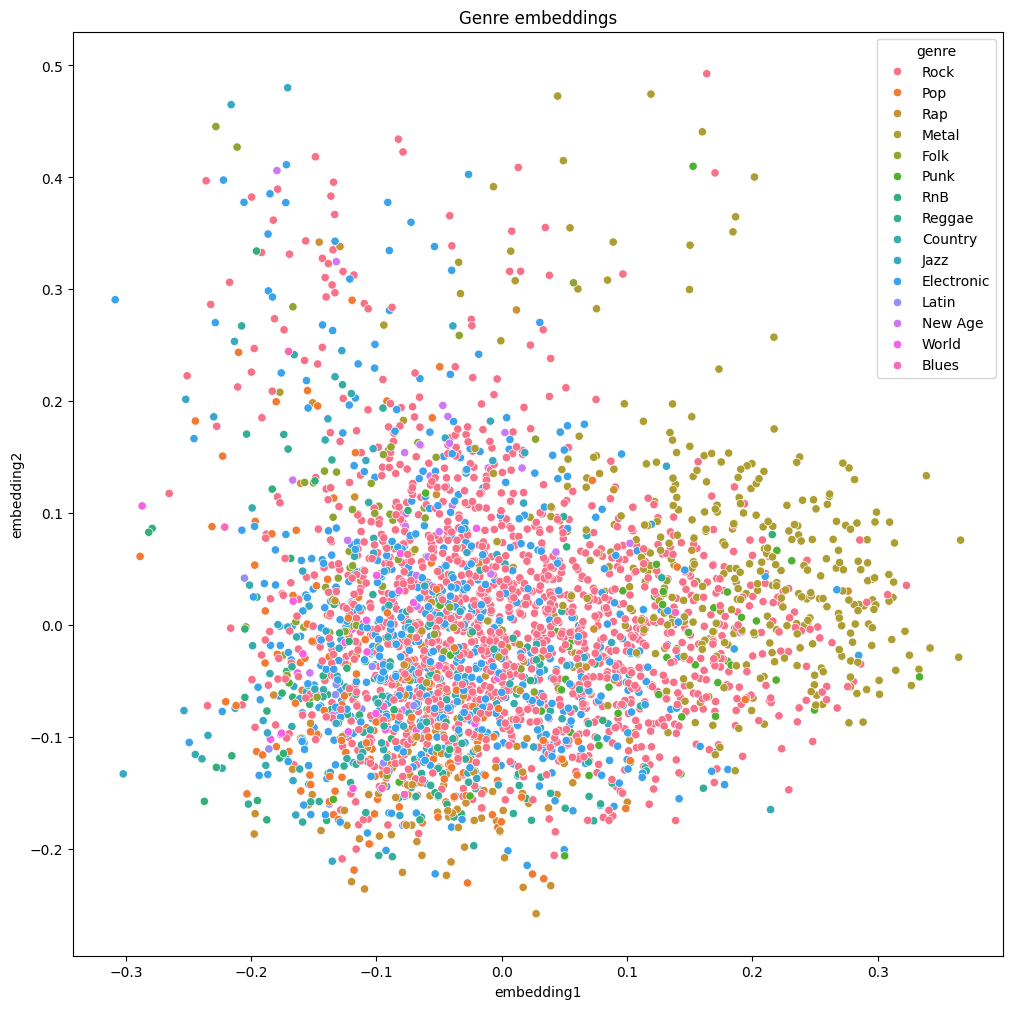

In [114]:
plot_clusters("genre")

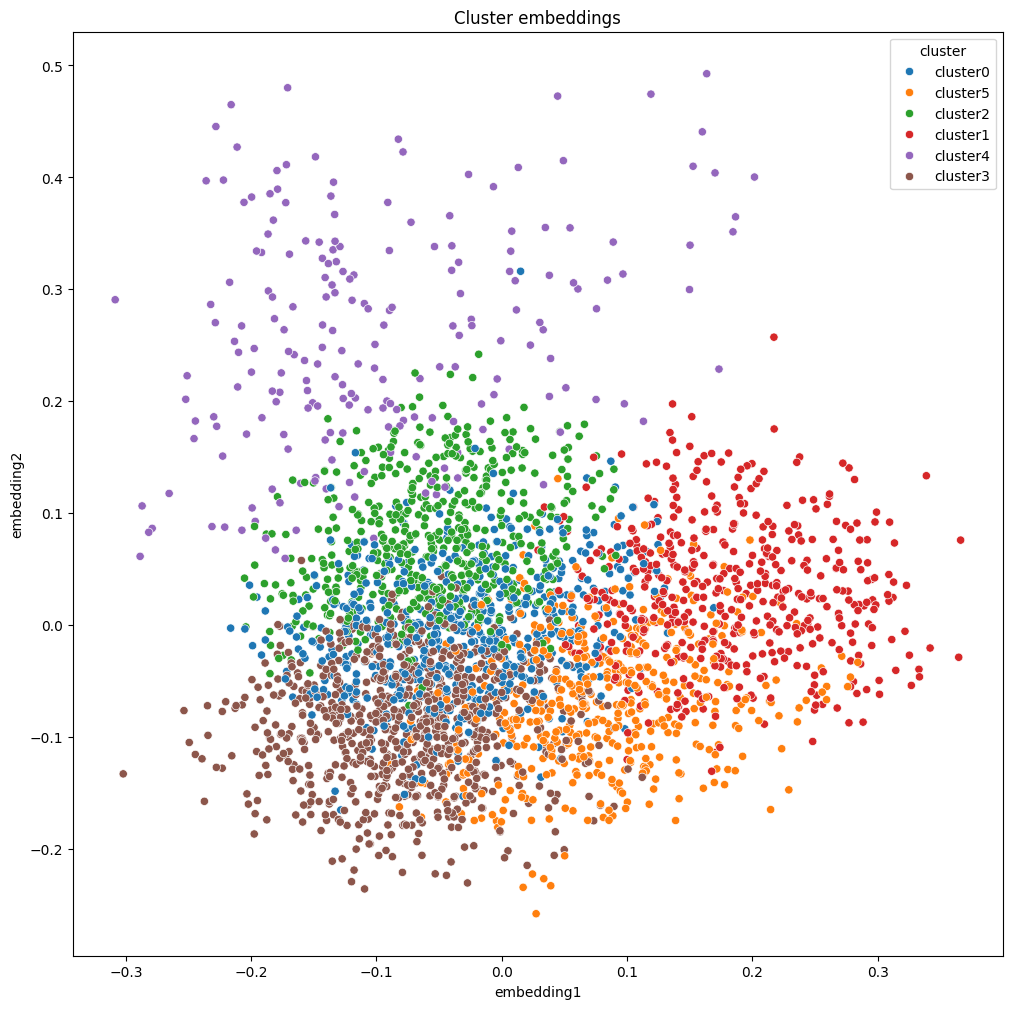

In [115]:
plot_clusters("cluster")

In [118]:
metrics.adjusted_rand_score(plot_df.genre, plot_df.cluster)

0.09183383374851693